# Descriptive analysis and models' features preparation (Sónar by night)

In [ ]:
import os

import re

import numpy as np
import pandas as pd
import duckdb

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.patheffects as path_effects

import folium

import plotly.express as px
import plotly.figure_factory as ff


import geopandas as gpd

import skmob
from skmob.measures.individual import distance_straight_line
from skmob.measures.individual import radius_of_gyration

from kneed import KneeLocator

from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm

from IPython.display import display

In [1]:
import sys
from pathlib import Path

# Adding the project root for module imports
project_root = Path().resolve().parents[1]
sys.path.append(str(project_root))

from attendee_profiling import config, constants, utils, utils_models

Assigning the path to read the trajectories files with their associated events:   

In [4]:
TRAJECTORIES_EVENTS_PATH =  config.TRAJECTORIES_EVENTS_PATH

Assigning the path to write the resulting tables (the input for the models)

In [ ]:
MODEL_INPUTS_PATH =  config.MODEL_INPUTS_PATH

Assigning the path to write the event scores.

In [6]:
TABLES_DESCRIPTION_PATH =  config.TABLES_DESCRIPTION_PATH

Assigning the path to write the plots.

In [9]:
DESCRIPTIVE_ANALYSIS_PLOTS_PATH =  config.DESCRIPTIVE_ANALYSIS_PLOTS_PATH

## Preliminary steps

Reading the data and formatting the time columns.

In [ ]:
trajectories_time_window_night_stops = pd.read_csv(os.path.join(TRAJECTORIES_EVENTS_PATH,'trajectories_events_night_filtered.csv'), 
                                                   dtype={'vendor_name': str},
                                                   parse_dates = ['datetime','start_datetime','end_datetime'])

In [ ]:
trajectories_events_night = pd.read_csv(os.path.join(TRAJECTORIES_EVENTS_PATH,'trajectories_events_night_filtered.csv'), dtype={'vendor_name': str},
                                        parse_dates = ['datetime','start_datetime','end_datetime'])

# Rename columns for clarity
trajectories_events_night.rename(columns={'start_datetime':'start_datetime_event',
                                          'end_datetime':'end_datetime_event'},
                                inplace=True)

# Add the timezone information so that the times are handled correctly
trajectories_events_night['datetime'] = trajectories_events_night['datetime'].dt.tz_convert('Europe/Madrid')
trajectories_events_night['start_datetime_event'] = trajectories_events_night['start_datetime_event'].dt.tz_convert('Europe/Madrid')
trajectories_events_night['end_datetime_event'] = trajectories_events_night['end_datetime_event'].dt.tz_convert('Europe/Madrid')

I compute the duration of the event on the timetable, which is needed later for some computations.

In [11]:
trajectories_events_night['event_duration_timetable_mins'] = (trajectories_events_night['end_datetime_event']-trajectories_events_night['start_datetime_event']).dt.total_seconds() / 60

Check the resulting columns and types.

In [12]:
trajectories_events_night.dtypes

uid                                                         object
macaddr_randomized                                           int64
tid                                                          int64
datetime                             datetime64[ns, Europe/Madrid]
timestamp_ap                                                 int64
lat                                                        float64
lng                                                        float64
vendor_name                                                 object
sonar_type                                                  object
start_datetime_event                 datetime64[ns, Europe/Madrid]
end_datetime_event                   datetime64[ns, Europe/Madrid]
event_title                                                 object
music_type                                                  object
genre_grouped                                               object
views_youtube                                              flo

Adding some columns.

In [13]:
# Create 5-minute time windows
trajectories_events_night['time_window_5min'] = trajectories_events_night['datetime'].dt.floor('5min')

# Create 15-minute time windows
trajectories_events_night['time_window_15min'] = trajectories_events_night['datetime'].dt.floor('15min')

# Rename the stage columns for the plot visualizations
stage_rename_plots = {'NA-Cashless1':'Entrance/Cashless', 'NA-Entrada':'Entrance/Cashless',
                      'NA-Restauración':'Restaurants',
                      'NA-autos_choques':'Bumper cars',
                      'NA-autos_choques_barra':'Bar: Restaurants-Bumper cars'}
trajectories_events_night['stage_renamed'] = trajectories_events_night['stage'].replace(stage_rename_plots)



# Convert the column into a categorical column with the specified order
trajectories_events_night['stage_renamed'] = pd.Categorical(trajectories_events_night['stage_renamed'],
                                                          categories=['SonarClub', 'SonarPub', 'SonarLab x Printworks', 'SonarCar',
                                                                      'Restaurants', 'Bumper cars', 'Bar: Restaurants-Bumper cars', 'Entrance/Cashless'],
                                                                       ordered=True
                                                        )

In [14]:
trajectories_events_night

uid  \
0        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
1        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
2        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
3        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
4        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
...                                                    ...   
1244456  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
1244457  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
1244458  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
1244459  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
1244460  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   

         macaddr_randomized  tid                  datetime  timestamp_ap  \
0                         1    2 2024-06-15 22:38:47+02:00    1718483927   
1                         1    2 2024-06-15 22:39:19+02:00    1718483959   
2                         1    2 2024-06-15 22:40:37+02:00    1718484037   
3                         1    2 2024-06-15 22:49:15+02:00    1718484555   
4                         1    2 2024-06-15 22:49:21+02:00    1718484561   
...                     ...  ...                       ...           ...   
1244456                   1    1 2024-06-15 06:29:12+02:00    1718425752   
1244457                   1    1 2024-06-15 06:29:14+02:00    1718425754   
1244458                   1    1 2024-06-15 06:31:02+02:00    1718425862   
1244459                   1    1 2024-06-15 06:31:04+02:00    1718425864   
1244460                   1    1 2024-06-15 06:31:37+02:00    1718425897   

               lat       lng vendor_name      sonar_type  \
0        41.353501  2.129162         NaN  Sónar by Night   
1        41.353440  2.129005         NaN  Sónar by Night   
2        41.353501  2.129162         NaN  Sónar by Night   
3        41.353426  2.128963         NaN  Sónar by Night   
4        41.353365  2.128970         NaN  Sónar by Night   
...            ...       ...         ...             ...   
1244456  41.354254  2.130618         NaN  Sónar by Night   
1244457  41.354254  2.130618         NaN  Sónar by Night   
1244458  41.354254  2.130618         NaN  Sónar by Night   
1244459  41.354254  2.130618         NaN  Sónar by Night   
1244460  41.353698  2.132315         NaN  Sónar by Night   

             start_datetime_event  ...          h3_cell  \
0       2024-06-14 19:50:00+02:00  ...  8d394461e82b5bf   
1       2024-06-14 19:50:00+02:00  ...  8d394461e82a67f   
2       2024-06-14 19:50:00+02:00  ...  8d394461e82b5bf   
3       2024-06-14 19:50:00+02:00  ...  8d394461e82a67f   
4       2024-06-14 19:50:00+02:00  ...  8d394461e82a6ff   
...                           ...  ...              ...   
1244456 2024-06-15 05:30:00+02:00  ...  8d394461e875cff   
1244457 2024-06-15 05:30:00+02:00  ...  8d394461e875cff   
1244458 2024-06-15 05:30:00+02:00  ...  8d394461e875cff   
1244459 2024-06-15 05:30:00+02:00  ...  8d394461e875cff   
1244460 2024-06-14 19:50:00+02:00  ...  8d394461e84027f   

        observations_user_night_original timespan_minutes_night_original  \
0                                    586                          340.90   
1                                    586                          340.90   
2                                    586                          340.90   
3                                    586                          340.90   
4                                    586                          340.90   
...                                  ...                             ...   
1244456                              714                          510.43   
1244457                              714                          510.43   
1244458                              714                          510.43   
1244459                              714                          510.43   
1244460                              714                          510.43   

        num_distinct_stage_night_original  minutes_per

Setting the style for the plots

In [15]:
sns.set_theme('paper', style="dark")

In [16]:
print(sns.plotting_context())

{'font.size': 9.600000000000001, 'axes.labelsize': 9.600000000000001, 'axes.titlesize': 9.600000000000001, 'xtick.labelsize': 8.8, 'ytick.labelsize': 8.8, 'legend.fontsize': 8.8, 'legend.title_fontsize': 9.600000000000001, 'axes.linewidth': 1.0, 'grid.linewidth': 0.8, 'lines.linewidth': 1.2000000000000002, 'lines.markersize': 4.800000000000001, 'patch.linewidth': 0.8, 'xtick.major.width': 1.0, 'ytick.major.width': 1.0, 'xtick.minor.width': 0.8, 'ytick.minor.width': 0.8, 'xtick.major.size': 4.800000000000001, 'ytick.major.size': 4.800000000000001, 'xtick.minor.size': 3.2, 'ytick.minor.size': 3.2}


In [17]:
plt.rcParams.update({
    "axes.labelsize": 14,
    'legend.fontsize': 11,
    'axes.titlesize': 13,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

### H3 counts (density approximation)

I want to measure how "dense" were the areas visited by the attendees. As this is a continuous measure, one proxy to it would be the counts in the H3 cells within a small time window size. I can try to use the H3 counts for the corresponding 5 minute time window of each observation.

In [18]:
users_h3_time_window_5min = utils.trajectories_to_h3_counts_gdf(trajectories_df=trajectories_events_night, 
                                                                count_type='users', 
                                                                window_duration='5min', 
                                                                sonar_type='night')

In [19]:
# Merge the DataFrames on h3_cell and the corresponding time window
trajectories_events_night = pd.merge(trajectories_events_night, users_h3_time_window_5min[['h3_cell','time_window_5min','counts_per_cell']], 
                                     on=['h3_cell','time_window_5min'], how='inner')

# Rename the counts_per_cell column for clarity
trajectories_events_night.rename(columns={'counts_per_cell':'cell_density'}, inplace=True)

In [20]:
trajectories_events_night

uid  \
0        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
1        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
2        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
3        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
4        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
...                                                    ...   
1244456  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
1244457  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
1244458  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
1244459  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
1244460  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   

         macaddr_randomized  tid                  datetime  timestamp_ap  \
0                         1    2 2024-06-15 22:38:47+02:00    1718483927   
1                         1    2 2024-06-15 22:39:19+02:00    1718483959   
2                         1    2 2024-06-15 22:40:37+02:00    1718484037   
3                         1    2 2024-06-15 22:49:15+02:00    1718484555   
4                         1    2 2024-06-15 22:49:21+02:00    1718484561   
...                     ...  ...                       ...           ...   
1244456                   1    1 2024-06-15 06:29:12+02:00    1718425752   
1244457                   1    1 2024-06-15 06:29:14+02:00    1718425754   
1244458                   1    1 2024-06-15 06:31:02+02:00    1718425862   
1244459                   1    1 2024-06-15 06:31:04+02:00    1718425864   
1244460                   1    1 2024-06-15 06:31:37+02:00    1718425897   

               lat       lng vendor_name      sonar_type  \
0        41.353501  2.129162         NaN  Sónar by Night   
1        41.353440  2.129005         NaN  Sónar by Night   
2        41.353501  2.129162         NaN  Sónar by Night   
3        41.353426  2.128963         NaN  Sónar by Night   
4        41.353365  2.128970         NaN  Sónar by Night   
...            ...       ...         ...             ...   
1244456  41.354254  2.130618         NaN  Sónar by Night   
1244457  41.354254  2.130618         NaN  Sónar by Night   
1244458  41.354254  2.130618         NaN  Sónar by Night   
1244459  41.354254  2.130618         NaN  Sónar by Night   
1244460  41.353698  2.132315         NaN  Sónar by Night   

             start_datetime_event  ... observations_user_night_original  \
0       2024-06-14 19:50:00+02:00  ...                              586   
1       2024-06-14 19:50:00+02:00  ...                              586   
2       2024-06-14 19:50:00+02:00  ...                              586   
3       2024-06-14 19:50:00+02:00  ...                              586   
4       2024-06-14 19:50:00+02:00  ...                              586   
...                           ...  ...                              ...   
1244456 2024-06-15 05:30:00+02:00  ...                              714   
1244457 2024-06-15 05:30:00+02:00  ...                              714   
1244458 2024-06-15 05:30:00+02:00  ...                              714   
1244459 2024-06-15 05:30:00+02:00  ...                              714   
1244460 2024-06-14 19:50:00+02:00  ...                              714   

        timespan_minutes_night_original num_distinct_stage_night_original  \
0                                340.90                                 7   
1                                340.90                                 7   
2                                340.90                                 7   
3                                340.90                                 7   
4                                340.90                                 7   
...                                 ...                               ...   
1244456                          510.43                                 5   
1244457                          510.43                                 5   
1244458                          510.43                                 5   
12444

## Sequence of stops

In [21]:
# Creating a duckDB connection for consistency in the configurations I need
duckdb_conn = duckdb.connect()

# Hiding the progress bar for queries
duckdb_conn.execute("PRAGMA disable_progress_bar;")
# Setting the connection timezone explicitly to avoid any confusions
duckdb_conn.execute("SET TimeZone='Europe/Madrid'")

In [22]:
# Extension to perform spatial operations
duckdb_conn.sql("INSTALL spatial;")
duckdb_conn.sql("LOAD spatial;")

Instead of traditional stay points, in this case the full trajectory for each user and each day of the festival can be segmented by the moments when the user switched stages or events (within the same location). 
That way, the "stops" are tied to a meaning (the event the users were attending apart from the physical location).

The logic to obtain these "stops" is to assign some transition labels to flag when there are `stage` or `event_title` changes.

The duration of a stop is computed as:
- The max-min timestamps that happen between event/stage transitions. 
- In cases when the event changes and the user stays at the same stage, the duration is obtained as the time limits of the events as ending times (it is assumed that the user stayed at the same location if the observations are contiguous).

In [23]:
# Query to flag when there is an event switch and then accumulates the counter (the "id")
query_event_switch_id = """
    WITH event_switches AS (
        SELECT
            *,
            -- Detecting transitions based on stage and event changes
            -- Computing a flag for switches (1 if event or stage changes, 0 otherwise)
            CASE
                WHEN stage <> LAG(stage) OVER (PARTITION BY uid, tid ORDER BY datetime)
                    OR event_title <> LAG(event_title) OVER (PARTITION BY uid, tid ORDER BY datetime)
                THEN 1
                ELSE 0
            END AS transition_flag_event
        FROM trajectories_events_night
    ),
    adjusted_events AS (
    SELECT
        *,
        
        -- Adjust the end time when event changes happen within the same stage
        CASE
            -- When the event changes from an actual event to something else within the same stage,
            -- the adjusted_end_time_stop (used later) becomes the ending time of the event.
            WHEN event_title <> LEAD(event_title) OVER (PARTITION BY uid, tid ORDER BY datetime)
                 AND stage = LEAD(stage) OVER (PARTITION BY uid, tid ORDER BY datetime)
                 AND event_title <> 'No event'
            THEN end_datetime_event

            -- When the event changes from no event to something else within the same stage,
            -- the adjusted_end_time_stop (used later) becomes the starting time of the following event.
            WHEN event_title <> LEAD(event_title) OVER (PARTITION BY uid, tid ORDER BY datetime)
                 AND stage = LEAD(stage) OVER (PARTITION BY uid, tid ORDER BY datetime)
                 AND event_title = 'No event'
            THEN LEAD(start_datetime_event) OVER (PARTITION BY uid, tid ORDER BY datetime)

            -- In all other (non-corner) cases, the adjusted_end_time_stop will be computed afterwards (in the next table)
            -- as the maximum datetime of each stop
            ELSE datetime
        END AS adjusted_end_time_stop,

        -- Adjust the start time when event changes happen within the same stage
        CASE
            -- When the event changes from something to an actual event within the same stage,
            -- the adjusted_start_time_stop (used later) becomes the starting time of the event.
            WHEN event_title <> LAG(event_title) OVER (PARTITION BY uid, tid ORDER BY datetime)
                 AND stage = LAG(stage) OVER (PARTITION BY uid, tid ORDER BY datetime)
                 AND event_title <> 'No event'
            THEN start_datetime_event

            -- When the event changes from an event to no event within the same stage,
            -- the adjusted_start_time_stop (used later) becomes the becomes the end time of the preceding event.
            WHEN event_title <> LAG(event_title) OVER (PARTITION BY uid, tid ORDER BY datetime)
                 AND stage = LAG(stage) OVER (PARTITION BY uid, tid ORDER BY datetime)
                 AND event_title = 'No event'
            THEN LAG(end_datetime_event) OVER (PARTITION BY uid, tid ORDER BY datetime)

            -- In all other (non-corner) cases, the adjusted_start_time_stop will be computed afterwards (in the next table)
            -- as the minimum datetime of each stop
            ELSE datetime
        END AS adjusted_start_time_stop
    FROM event_switches
)

    SELECT
        *,
        -- Assign a unique visit ID based on the cumulative sum of transitions
        CAST(
            SUM(transition_flag_event) OVER (PARTITION BY uid, tid ORDER BY datetime) 
            AS INT
        ) AS stop_id
    FROM adjusted_events
    ORDER BY uid, tid, datetime
    """

trajectories_events_night_switches = duckdb_conn.sql(query_event_switch_id).to_df()

After obtaining the `stop_id` from the flagging step, I can condense the whole trajectory with the sequence of "stops".

With respect to the geographic information, the centroid for each "stop" can be computed. Although it may have a coarser spatial granularity than what might result from a traditional stay point with a fixed radius and stay time, this approach better aligns with the spatial and temporal context of the festival and allows for flexibility with respect to the stay duration.

Also, as this setting is a small, confined region, for simplicity and computational efficience, it is useful to project the coordinates to [UTM](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) (which yields coordinates in a local plane in meters).

In [24]:
# Query to compute the time spent at each stop (event switch) 
sequence_stops_night = duckdb_conn.sql('''
                                    WITH sequence_events_with_centroids AS (
                                          SELECT
                                                macaddr_randomized,
                                                uid,
                                                tid,
                                                stage,
                                                stage_renamed,
                                                stage_area_m2,
                                                event_title,
                                                start_datetime_event,
                                                event_duration_timetable_mins,
                                                music_type,
                                                genre_grouped,
                                                views_youtube,
                                                stop_id,
                                                MIN(adjusted_start_time_stop) AS start_time_stop,
                                                MAX(adjusted_end_time_stop) AS end_time_stop,
                                                (MAX(EXTRACT(EPOCH FROM adjusted_end_time_stop)) - MIN(EXTRACT(EPOCH FROM adjusted_start_time_stop))) / 60 AS duration_stop_mins,
                                       
                                                -- Obtaining the centroids (it requires projecting to UTM for computing the operation on a plane)
                                                ST_Centroid(
                                                            ST_Transform(
                                                                        ST_COLLECT(list(ST_Point(lng, lat))),
                                                                        'EPSG:4326', -- Original crs. Obtained with night_polygons_clipped.crs
                                                                        'EPSG:32631', -- Target crs to compute the centroid. Obtained with night_polygons_clipped.estimate_utm_crs()
                                                                        always_xy := true
                                                                        )
                                                            )
                                                AS centroid_projected
                                       
                                          FROM trajectories_events_night_switches
                                          GROUP BY macaddr_randomized, uid, tid, stop_id, 
                                                stage, stage_renamed, stage_area_m2, event_title, start_datetime_event, event_duration_timetable_mins, music_type, genre_grouped, views_youtube,
                                          ORDER BY uid, tid, stop_id
                                       )



                                       -- Extract the centroid coordinates
                                    SELECT 
                                          *,
                                          -- Extract projected coordinates directly
                                          ST_X(centroid_projected) AS x_centroid_proj,
                                          ST_Y(centroid_projected) AS y_centroid_proj,
                                    
                                          -- Reproject centroid back to original coordinates and extract lat/lng
                                          ST_X(
                                                ST_Transform(
                                                            centroid_projected,
                                                            'EPSG:32631', -- Transforming the coordinates back
                                                            'EPSG:4326',  
                                                            always_xy := true
                                                            )
                                                )
                                          AS lng_centroid,
                                    
                                          ST_Y(
                                                ST_Transform(
                                                            centroid_projected,
                                                            'EPSG:32631', -- Transforming the coordinates back
                                                            'EPSG:4326',  
                                                            always_xy := true
                                                            )
                                                )
                                          AS lat_centroid
                                    FROM sequence_events_with_centroids

                                          ''').to_df()
sequence_stops_night

macaddr_randomized                                                uid  \
0                       1  00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
1                       1  00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
2                       1  00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
3                       1  00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
4                       1  00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
...                   ...                                                ...   
66860                   1  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
66861                   1  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
66862                   1  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
66863                   1  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
66864                   1  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   

       tid                  stage          stage_renamed  stage_area_m2  \
0        2             NA-Entrada      Entrance/Cashless           5438   
1        2              SonarClub              SonarClub          14914   
2        2              SonarClub              SonarClub          14914   
3        2              SonarClub              SonarClub          14914   
4        2  SonarLab x Printworks  SonarLab x Printworks           9171   
...    ...                    ...                    ...            ...   
66860    1       NA-autos_choques            Bumper cars           1522   
66861    1  SonarLab x Printworks  SonarLab x Printworks           9171   
66862    1       NA-autos_choques            Bumper cars           1522   
66863    1  SonarLab x Printworks  SonarLab x Printworks           9171   
66864    1        NA-Restauración            Restaurants           5695   

                    event_title      start_datetime_event  \
0                      No event 2024-06-14 19:50:00+02:00   
1              Paul Kalkbrenner 2024-06-15 22:00:00+02:00   
2                      No event                       NaT   
3                        Anetha 2024-06-15 23:35:00+02:00   
4                   Sepehr live 2024-06-15 23:50:00+02:00   
...                         ...                       ...   
66860                  No event 2024-06-14 19:50:00+02:00   
66861  DJ Flight & MC Chickaboo 2024-06-15 05:30:00+02:00   
66862                  No event 2024-06-14 19:50:00+02:00   
66863  DJ Flight & MC Chickaboo 2024-06-15 05:30:00+02:00   
66864                  No event 2024-06-14 19:50:00+02:00   

       event_duration_timetable_mins music_type  ... views_youtube  stop_id  \
0                             2170.0       None  ...           NaN        0   
1                               90.0       LIVE  ...   370125764.0        1   
2                                NaN       None  ...           NaN        2   
3                               90.0         DJ  ...     1146541.0        3   
4                               60.0       LIVE  ...           0.0        4   
...                              ...        ...  ...           ...      ...   
66860                         2170.0       None  ...           NaN       21   
66861                           90.0         DJ  ...           0.0       22   
66862                         2170.0       None  ...           NaN       23   
66863                           90.0         DJ  ...           0.0       24   
66864                         2170.0       None  ...           NaN       25   

                start_time_stop             end_time_stop duration_stop_mins  \
0     2024-06-15 22:38:47+02:00 2024-06-15 23:08:23+02:00          29.600000   
1     2024-06-15 23:10:38+02:00 2024-06-15 23:30:00+02:00          19.366667   
2     2024-06-15 23:30:00+02:00 2024-06-15 23:35:00+02:00           5.000000   
3     2024-06-15 23:35:00+02:00 2024-06-15 23:44:17+02:00           9.283333   
4     2024-06-16 00:03:29+02:00 2024-06-16 00:07:24+02:00      

In [25]:
# Centroid is not necessary now that I have the coordinates
sequence_stops_night.drop(columns='centroid_projected',inplace=True)

Joining back the computed information to the main trajectories df to verify the procedure.

In [26]:
trajectories_events_night = duckdb_conn.sql("""
                                            SELECT
                                                ten.uid, ten.macaddr_randomized, ten.tid,
                                                ten.observations_user_night_original,
                                                ten.timespan_minutes_night_original,
                                                ten.datetime, ten.timestamp_ap, time_window_5min, ten.time_window_15min,
                                                ten.lat, ten.lng, ten.h3_cell, ten.geometry,
                                                ten.vendor_name, 
                                                ten.sonar_type, 
                                                ten.start_datetime_event, ten.end_datetime_event, ten.event_duration_timetable_mins, ten.event_title, 
                                                ten.music_type, ten.genre_grouped, ten.views_youtube,
                                                ten.stage, ten.polygon_name, ten.stage_area_m2, ten.stage_renamed,
                                                ten.cell_density, 
                                                ten.transition_flag_event, ten.stop_id,
                                                ssn.start_time_stop, ssn.end_time_stop, ssn.duration_stop_mins
                                             
                                            FROM trajectories_events_night_switches ten 
                                                INNER JOIN sequence_stops_night ssn
                                                    ON ten.uid = ssn.uid
                                                        AND ten.tid = ssn.tid
                                                        AND ten.stop_id = ssn.stop_id
                                            ORDER BY ten.uid, ten.tid, ten.datetime
                                            """).to_df()

trajectories_events_night

uid  \
0        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
1        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
2        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
3        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
4        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
...                                                    ...   
1244456  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
1244457  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
1244458  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
1244459  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
1244460  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   

         macaddr_randomized  tid  observations_user_night_original  \
0                         1    2                               586   
1                         1    2                               586   
2                         1    2                               586   
3                         1    2                               586   
4                         1    2                               586   
...                     ...  ...                               ...   
1244456                   1    1                               714   
1244457                   1    1                               714   
1244458                   1    1                               714   
1244459                   1    1                               714   
1244460                   1    1                               714   

         timespan_minutes_night_original                  datetime  \
0                                 340.90 2024-06-15 22:38:47+02:00   
1                                 340.90 2024-06-15 22:39:19+02:00   
2                                 340.90 2024-06-15 22:40:37+02:00   
3                                 340.90 2024-06-15 22:49:15+02:00   
4                                 340.90 2024-06-15 22:49:21+02:00   
...                                  ...                       ...   
1244456                           510.43 2024-06-15 06:29:12+02:00   
1244457                           510.43 2024-06-15 06:29:14+02:00   
1244458                           510.43 2024-06-15 06:31:02+02:00   
1244459                           510.43 2024-06-15 06:31:04+02:00   
1244460                           510.43 2024-06-15 06:31:37+02:00   

         timestamp_ap          time_window_5min         time_window_15min  \
0          1718483927 2024-06-15 22:35:00+02:00 2024-06-15 22:30:00+02:00   
1          1718483959 2024-06-15 22:35:00+02:00 2024-06-15 22:30:00+02:00   
2          1718484037 2024-06-15 22:40:00+02:00 2024-06-15 22:30:00+02:00   
3          1718484555 2024-06-15 22:45:00+02:00 2024-06-15 22:45:00+02:00   
4          1718484561 2024-06-15 22:45:00+02:00 2024-06-15 22:45:00+02:00   
...               ...                       ...                       ...   
1244456    1718425752 2024-06-15 06:25:00+02:00 2024-06-15 06:15:00+02:00   
1244457    1718425754 2024-06-15 06:25:00+02:00 2024-06-15 06:15:00+02:00   
1244458    1718425862 2024-06-15 06:30:00+02:00 2024-06-15 06:30:00+02:00   
1244459    1718425864 2024-06-15 06:30:00+02:00 2024-06-15 06:30:00+02:00   
1244460    1718425897 2024-06-15 06:30:00+02:00 2024-06-15 06:30:00+02:00   

               lat  ...                  stage              polygon_name  \
0        41.353501  ...             NA-Entrada       SONAR NIT - Entrada   
1        41.353440  ...             NA-Entrada       SONAR NIT - Entrada   
2        41.353501  ...             NA-Entrada       SONAR NIT - Entrada   
3        41.353426  ...             NA-Entrada       SONAR NIT - Entrada   
4        41.353365  ...             NA-Entrada       SONAR NIT - Entrada   
...            ...  ...                    ...                       ...   
1244456  41.354254  ...  SonarLab x Printworks      SONAR NIT - SonarLab   
1244457  41.354254  ...  SonarLab x Printworks      SONAR NIT - SonarLab   
1244458  41.354254 

### Substops

I also compute the time spent at each location (`polygon_name`) within each stop. I will call this a substop. The idea behind this is to measure the time people spent at the bar or at the other areas within each stage.

In [27]:
# Query to flag when there is an event switch and then accumulates the counter (the "id")
query_substop_switch_id = """
    WITH substop_switches AS (
        SELECT
            *,
            -- Detecting transitions based on location (polygon_name) changes within the same stop
            -- Computing a flag for switches (1 if polygon_name changes, 0 otherwise)
            CASE
                WHEN polygon_name <> LAG(polygon_name) OVER (PARTITION BY uid, tid, stop_id  ORDER BY datetime)
                THEN 1
                ELSE 0
            END AS transition_flag_substop
        FROM trajectories_events_night
    ),
    adjusted_substops AS (
    SELECT
        *,

        -- Define adjusted_start_time_substop
        CASE
            -- If it is the first substop, it uses the overall start_time_stop 
            WHEN stop_id <> LAG(stop_id) OVER (PARTITION BY uid, tid ORDER BY datetime)
            THEN start_time_stop
            
            -- If it is a different substop, it uses the current datetime (when the polygon switch occurred)
            ELSE datetime
        END AS adjusted_start_time_substop,
        
        -- Define adjusted_end_time_substop
        CASE
            -- If there's a next substop, use its start time as the current substop's end time
            WHEN LEAD(polygon_name) OVER (PARTITION BY uid, tid, stop_id ORDER BY datetime) IS NOT NULL
            THEN LEAD(datetime) OVER (PARTITION BY uid, tid, stop_id ORDER BY datetime)
            
            -- If it's the last substop within this stop, use the stop's end time
            ELSE end_time_stop
        END AS adjusted_end_time_substop
    FROM substop_switches
)

    SELECT
        *,
        -- Assign a unique visit ID based on the cumulative sum of transitions
        CAST(
            SUM(transition_flag_substop) OVER (PARTITION BY uid, tid, stop_id ORDER BY datetime) 
            AS INT
        ) AS substop_id
    FROM adjusted_substops
    ORDER BY uid, tid, datetime
    """

trajectories_events_night_switches_substops = duckdb_conn.sql(query_substop_switch_id).to_df()

In [28]:
# Query to compute the time spent at each substop (polygon_name switch within a stop)
substops_durations_night = duckdb_conn.sql('''
                                                SELECT
                                                   uid,
                                                   tid,
                                                   event_title,
                                                   stage,
                                                   polygon_name,
                                                   start_time_stop, end_time_stop, stop_id,
                                                   substop_id,
                                                   MIN(adjusted_start_time_substop) AS start_time_substop,
                                                   MAX(adjusted_end_time_substop) AS end_time_substop,
                                                   (MAX(EXTRACT(EPOCH FROM adjusted_end_time_substop)) - MIN(EXTRACT(EPOCH FROM adjusted_start_time_substop))) / 60 AS duration_substop_mins 
                                                FROM trajectories_events_night_switches_substops
                                                GROUP BY uid, tid, event_title, stage, polygon_name, start_time_stop, end_time_stop, stop_id, substop_id,
                                                ORDER BY uid, tid, stop_id, substop_id
                                                ''').to_df()
substops_durations_night

uid  tid  \
0       00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
1       00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
2       00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
3       00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
4       00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
...                                                   ...  ...   
127955  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
127956  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
127957  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
127958  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
127959  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   

                     event_title                  stage  \
0                       No event             NA-Entrada   
1               Paul Kalkbrenner              SonarClub   
2                       No event              SonarClub   
3                         Anetha              SonarClub   
4                         Anetha              SonarClub   
...                          ...                    ...   
127955  DJ Flight & MC Chickaboo  SonarLab x Printworks   
127956  DJ Flight & MC Chickaboo  SonarLab x Printworks   
127957  DJ Flight & MC Chickaboo  SonarLab x Printworks   
127958  DJ Flight & MC Chickaboo  SonarLab x Printworks   
127959                  No event        NA-Restauración   

                        polygon_name           start_time_stop  \
0                SONAR NIT - Entrada 2024-06-15 22:38:47+02:00   
1              SONAR NIT - SonarClub 2024-06-15 23:10:38+02:00   
2              SONAR NIT - SonarClub 2024-06-15 23:30:00+02:00   
3              SONAR NIT - SonarClub 2024-06-15 23:35:00+02:00   
4        SONAR NIT - SonarClub Barra 2024-06-15 23:35:00+02:00   
...                              ...                       ...   
127955  SONAR NIT - SonarLab Barra 1 2024-06-15 05:43:35+02:00   
127956          SONAR NIT - SonarLab 2024-06-15 05:43:35+02:00   
127957  SONAR NIT - SonarLab Barra 1 2024-06-15 05:43:35+02:00   
127958          SONAR NIT - SonarLab 2024-06-15 05:43:35+02:00   
127959      SONAR NIT - Restauración 2024-06-15 06:31:37+02:00   

                   end_time_stop  stop_id  substop_id  \
0      2024-06-15 23:08:23+02:00        0           0   
1      2024-06-15 23:30:00+02:00        1           0   
2      2024-06-15 23:35:00+02:00        2           0   
3      2024-06-15 23:44:17+02:00        3           0   
4      2024-06-15 23:44:17+02:00        3           1   
...                          ...      ...         ...   
127955 2024-06-15 06:31:04+02:00       24          15   
127956 2024-06-15 06:31:04+02:00       24          16   
127957 2024-06-15 06:31:04+02:00       24          17   
127958 2024-06-15 06:31:04+02:00       24          18   
127959 2024-06-15 06:31:37+02:00       25           0   

              start_time_substop          end_time_substop  \
0      2024-06-15 22:38:47+02:00 2024-06-15 23:08:23+02:00   
1      2024-06-15 23:10:38+02:00 2024-06-15 23:30:00+02:00   
2      2024-06-15 23:30:00+02:00 2024-06-15 23:35:00+02:00   
3      2024-06-15 23:35:00+02:00 2024-06-15 23:39:10+02:00   
4      2024-06-15 23:39:10+02:00 2024-06-15 23:39:17+02:00   
...                          ...                       ...   
127955 2024-06-15 06:24:50+02:00 2024-06-15 06:26:21+02:00   
127956 2024-06-15 06:26:21+02:00 2024-06-15 06:27:57+02:00   
127957 2024-06-15 06:27:57+02:00 2024-06-15 06:28:41+02:00   
127958 2024-06-15 06:28:41+02:00 2024-06-15 06:31:04+02:00   
127959 2024-06-15 06:31:37+02:00 2024-06-15 06:31:37+02:00   

        duration_substop_mins  
0                   29.600000  
1                   19.366667  
2                    5.000000  
3                    4.166667  
4                    0.116667  
...                       ...  
127955               1.516667  
127956               1.600000  
127957               0.733333  
127958   

#### Creating a label for the type of location (bar/restaurant, stages, entrance)

Each substop will have an explicit label for the type of location.

In [29]:
location_type_dict = {'SONAR NIT - SonarClub':'stage',
                      'SONAR NIT - SonarPub':'stage',
                      'SONAR NIT - SonarPub VIP':'stage',
                      'SONAR NIT - SonarCar':'stage', 
                      'SONAR NIT - SonarLab':'stage',
                      'SONAR NIT - SonarClub Barra':'bar_restaurant',
                      'SONAR NIT - SonarClub Barra la Nueva':'bar_restaurant',
                      'SONAR NIT - SonarClub Barra Catalá':'bar_restaurant',
                      'SONAR NIT - SonarPub Barra No VIP':'bar_restaurant',
                      'SONAR NIT - SonarPub Barra VIP 2':'bar_restaurant',
                      'SONAR NIT - Bar Pub':'bar_restaurant',
                      'SONAR NIT - Bar Pub Barra':'bar_restaurant',
                      'SONAR NIT - SonarLab Barra 1':'bar_restaurant',
                      'SONAR NIT - SonarLab Barra 2':'bar_restaurant',
                      'SONAR NIT - Restauración':'bar_restaurant',
                      'SONAR NIT - Autos de choques Barra':'bar_restaurant',
                      'SONAR NIT - SonarCar Barra':'bar_restaurant',
                      'SONAR NIT - Entrada':'other',
                      'SONAR NIT - Autos de choques':'other',
                      'SONAR NIT - Cashless 1':'other'}

substops_durations_night['location_type'] = substops_durations_night['polygon_name'].map(location_type_dict)

For each stop (visit to an event/stage), I can compute the accumulated time spent for each type of location.

In [30]:
# Pivot data for the time at each location type
duration_location_type_stop = substops_durations_night.pivot_table(index=['uid', 'tid','stop_id'],
                                                                   columns='location_type',
                                                                   values='duration_substop_mins',
                                                                   aggfunc='sum',
                                                                   fill_value=0)

# Reformat the table
duration_location_type_stop.columns = [f'mins_{col}_stop' for col in duration_location_type_stop.columns]
duration_location_type_stop = duration_location_type_stop.reset_index()
duration_location_type_stop

uid  tid  stop_id  \
0      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2        0   
1      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2        1   
2      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2        2   
3      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2        3   
4      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2        4   
...                                                  ...  ...      ...   
66860  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1       21   
66861  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1       22   
66862  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1       23   
66863  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1       24   
66864  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1       25   

       mins_bar_restaurant_stop  mins_other_stop  mins_stage_stop  
0                      0.000000        29.600000         0.000000  
1                      0.000000         0.000000        19.366667  
2                      0.000000         0.000000         5.000000  
3                      4.083333         0.000000         5.200000  
4                      3.916667         0.000000         0.000000  
...                         ...              ...              ...  
66860                  0.000000         0.333333         0.000000  
66861                  0.000000         0.000000         0.000000  
66862                  0.000000         0.033333         0.000000  
66863                 12.200000         0.000000        35.283333  
66864                  0.000000         0.000000         0.000000  

[66865 rows x 6 columns]

Joining back the computed information to the main sequence of stops and the main trajectories df.

In [31]:
# Join back to the sequence of stops
sequence_stops_night = pd.merge(sequence_stops_night,
                                duration_location_type_stop,
                                on=['uid','tid','stop_id'],
                                how='inner')

sequence_stops_night

macaddr_randomized                                                uid  \
0                       1  00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
1                       1  00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
2                       1  00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
3                       1  00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
4                       1  00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
...                   ...                                                ...   
66860                   1  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
66861                   1  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
66862                   1  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
66863                   1  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
66864                   1  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   

       tid                  stage          stage_renamed  stage_area_m2  \
0        2             NA-Entrada      Entrance/Cashless           5438   
1        2              SonarClub              SonarClub          14914   
2        2              SonarClub              SonarClub          14914   
3        2              SonarClub              SonarClub          14914   
4        2  SonarLab x Printworks  SonarLab x Printworks           9171   
...    ...                    ...                    ...            ...   
66860    1       NA-autos_choques            Bumper cars           1522   
66861    1  SonarLab x Printworks  SonarLab x Printworks           9171   
66862    1       NA-autos_choques            Bumper cars           1522   
66863    1  SonarLab x Printworks  SonarLab x Printworks           9171   
66864    1        NA-Restauración            Restaurants           5695   

                    event_title      start_datetime_event  \
0                      No event 2024-06-14 19:50:00+02:00   
1              Paul Kalkbrenner 2024-06-15 22:00:00+02:00   
2                      No event                       NaT   
3                        Anetha 2024-06-15 23:35:00+02:00   
4                   Sepehr live 2024-06-15 23:50:00+02:00   
...                         ...                       ...   
66860                  No event 2024-06-14 19:50:00+02:00   
66861  DJ Flight & MC Chickaboo 2024-06-15 05:30:00+02:00   
66862                  No event 2024-06-14 19:50:00+02:00   
66863  DJ Flight & MC Chickaboo 2024-06-15 05:30:00+02:00   
66864                  No event 2024-06-14 19:50:00+02:00   

       event_duration_timetable_mins music_type  ...  \
0                             2170.0       None  ...   
1                               90.0       LIVE  ...   
2                                NaN       None  ...   
3                               90.0         DJ  ...   
4                               60.0       LIVE  ...   
...                              ...        ...  ...   
66860                         2170.0       None  ...   
66861                           90.0         DJ  ...   
66862                         2170.0       None  ...   
66863                           90.0         DJ  ...   
66864                         2170.0       None  ...   

                start_time_stop             end_time_stop  duration_stop_mins  \
0     2024-06-15 22:38:47+02:00 2024-06-15 23:08:23+02:00           29.600000   
1     2024-06-15 23:10:38+02:00 2024-06-15 23:30:00+02:00           19.366667   
2     2024-06-15 23:30:00+02:00 2024-06-15 23:35:00+02:00            5.000000   
3     2024-06-15 23:35:00+02:00 2024-06-15 23:44:17+02:00            9.283333   
4     2024-06-16 00:03:29+02:00 2024-06-16 00:07:24+02:00            3.916667   
...                         ...                       ...                 ...   
66860 2024-06-15 05:38:44+02:00 2024-06-15 05:39:04+02:00            0.333333   
66861 2024-06-15 05:40:13+02:00 2024-06-15 05:40:13+02:00            0.000000   
66862 2024

In [32]:
# Join back to the trajectories df and selecting the relevant columns 
# (not adding the time by location type on each observation for simplicity)
trajectories_events_night = duckdb_conn.sql("""
                                            SELECT
                                                ten.uid, ten.macaddr_randomized, ten.tid,
                                                ten.observations_user_night_original,
                                                ten.timespan_minutes_night_original, 
                                                ten.datetime, ten.timestamp_ap, time_window_5min, ten.time_window_15min,
                                                ten.lat, ten.lng, ten.h3_cell, ten.geometry,
                                                ten.vendor_name, 
                                                ten.sonar_type, 
                                                ten.start_datetime_event, ten.end_datetime_event, ten.event_duration_timetable_mins, ten.event_title, 
                                                ten.music_type, ten.genre_grouped, ten.views_youtube,
                                                ten.stage, ten.polygon_name, ten.stage_area_m2, ten.stage_renamed,
                                                ten.cell_density, 
                                                ten.transition_flag_event, 
                                                ten.stop_id, ten.start_time_stop, ten.end_time_stop, ten.duration_stop_mins,
                                                sdn.substop_id, sdn.start_time_substop, sdn.end_time_substop, sdn.duration_substop_mins
                                                

                                             
                                            FROM trajectories_events_night_switches_substops ten 
                                                INNER JOIN substops_durations_night sdn
                                                    ON ten.uid = sdn.uid
                                                        AND ten.tid = sdn.tid
                                                        AND ten.stop_id = sdn.stop_id
                                                        AND ten.substop_id = sdn.substop_id
                                            ORDER BY ten.uid, ten.tid, ten.datetime
                                            """).to_df()

trajectories_events_night

uid  \
0        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
1        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
2        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
3        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
4        00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
...                                                    ...   
1244456  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
1244457  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
1244458  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
1244459  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
1244460  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   

         macaddr_randomized  tid  observations_user_night_original  \
0                         1    2                               586   
1                         1    2                               586   
2                         1    2                               586   
3                         1    2                               586   
4                         1    2                               586   
...                     ...  ...                               ...   
1244456                   1    1                               714   
1244457                   1    1                               714   
1244458                   1    1                               714   
1244459                   1    1                               714   
1244460                   1    1                               714   

         timespan_minutes_night_original                  datetime  \
0                                 340.90 2024-06-15 22:38:47+02:00   
1                                 340.90 2024-06-15 22:39:19+02:00   
2                                 340.90 2024-06-15 22:40:37+02:00   
3                                 340.90 2024-06-15 22:49:15+02:00   
4                                 340.90 2024-06-15 22:49:21+02:00   
...                                  ...                       ...   
1244456                           510.43 2024-06-15 06:29:12+02:00   
1244457                           510.43 2024-06-15 06:29:14+02:00   
1244458                           510.43 2024-06-15 06:31:02+02:00   
1244459                           510.43 2024-06-15 06:31:04+02:00   
1244460                           510.43 2024-06-15 06:31:37+02:00   

         timestamp_ap          time_window_5min         time_window_15min  \
0          1718483927 2024-06-15 22:35:00+02:00 2024-06-15 22:30:00+02:00   
1          1718483959 2024-06-15 22:35:00+02:00 2024-06-15 22:30:00+02:00   
2          1718484037 2024-06-15 22:40:00+02:00 2024-06-15 22:30:00+02:00   
3          1718484555 2024-06-15 22:45:00+02:00 2024-06-15 22:45:00+02:00   
4          1718484561 2024-06-15 22:45:00+02:00 2024-06-15 22:45:00+02:00   
...               ...                       ...                       ...   
1244456    1718425752 2024-06-15 06:25:00+02:00 2024-06-15 06:15:00+02:00   
1244457    1718425754 2024-06-15 06:25:00+02:00 2024-06-15 06:15:00+02:00   
1244458    1718425862 2024-06-15 06:30:00+02:00 2024-06-15 06:30:00+02:00   
1244459    1718425864 2024-06-15 06:30:00+02:00 2024-06-15 06:30:00+02:00   
1244460    1718425897 2024-06-15 06:30:00+02:00 2024-06-15 06:30:00+02:00   

               lat  ...  cell_density transition_flag_event stop_id  \
0        41.353501  ...             3                     0       0   
1        41.353440  ...             3                     0       0   
2        41.353501  ...             3                     0       0   
3        41.353426  ...             1                     0       0   
4        41.353365  ...             1                     0       0   
...            ...  ...           ...                   ...     ...   
1244456  41.354254  ...             1                     0      24   
1244457  41.354254  ...             1                     0      24   
1244458  41.354254  ...             1                     0     

### Checking the distribution of the stop durations

In [33]:
sequence_stops_night.columns

Index(['macaddr_randomized', 'uid', 'tid', 'stage', 'stage_renamed',
       'stage_area_m2', 'event_title', 'start_datetime_event',
       'event_duration_timetable_mins', 'music_type', 'genre_grouped',
       'views_youtube', 'stop_id', 'start_time_stop', 'end_time_stop',
       'duration_stop_mins', 'x_centroid_proj', 'y_centroid_proj',
       'lng_centroid', 'lat_centroid', 'mins_bar_restaurant_stop',
       'mins_other_stop', 'mins_stage_stop'],
      dtype='object')

In [34]:
print('Distribution of stop time (in minutes):')
stop_time_distribution = duckdb_conn.query("""
                                                                  SELECT
                                                                    tid,
                                                                    MIN(duration_stop_mins) AS min_duration_at_event,
                                                                    PERCENTILE_CONT(0.05) WITHIN GROUP(ORDER BY duration_stop_mins) AS p05_duration_at_event,
                                                                    PERCENTILE_CONT(0.10) WITHIN GROUP(ORDER BY duration_stop_mins) AS p10_duration_at_event,
                                                                    PERCENTILE_CONT(0.15) WITHIN GROUP(ORDER BY duration_stop_mins) AS p15_duration_at_event,
                                                                    PERCENTILE_CONT(0.25) WITHIN GROUP(ORDER BY duration_stop_mins) AS p25_duration_at_event,
                                                                    PERCENTILE_CONT(0.375) WITHIN GROUP(ORDER BY duration_stop_mins) AS p375_duration_at_event,
                                                                    PERCENTILE_CONT(0.50) WITHIN GROUP(ORDER BY duration_stop_mins) AS median_duration_at_event,
                                                                    PERCENTILE_CONT(0.75) WITHIN GROUP(ORDER BY duration_stop_mins) AS p75_duration_at_event,
                                                                    PERCENTILE_CONT(0.90) WITHIN GROUP(ORDER BY duration_stop_mins) AS p90_duration_at_event,
                                                                    PERCENTILE_CONT(0.95) WITHIN GROUP(ORDER BY duration_stop_mins) AS p95_duration_at_event,
                                                                    PERCENTILE_CONT(0.975) WITHIN GROUP(ORDER BY duration_stop_mins) AS p975_duration_at_event,
                                                                    MAX(duration_stop_mins) AS max_timespan
                                                                  FROM sequence_stops_night
                                                                  WHERE event_title <> 'No event'
                                                                  GROUP BY tid
                                                                  ORDER BY tid""")
stop_time_distribution

Distribution of stop time (in minutes):


┌───────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬────────────────────────┬──────────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬────────────────────────┬──────────────┐
│  tid  │ min_duration_at_event │ p05_duration_at_event │ p10_duration_at_event │ p15_duration_at_event │ p25_duration_at_event │ p375_duration_at_event │ median_duration_at_event │ p75_duration_at_event │ p90_duration_at_event │ p95_duration_at_event │ p975_duration_at_event │ max_timespan │
│ int64 │        double         │        double         │        double         │        double         │        double         │         double         │          double          │        double         │        double         │        double         │         double         │    double    │
├───────┼───────────────────────┼───────────────────────┼───────────────────────┼───────────────────────┼─────────────

In [ ]:
# Creating a histogram
fig = px.histogram(
    sequence_stops_night,
    x="duration_stop_mins",
    color="macaddr_randomized",
    #facet_row="tid",
    nbins=250, 
    title=f"Distribution of the stop durations",
    category_orders={"macaddr_randomized": [0, 1]})

# Updating the layout
fig.update_layout(
    xaxis_title="Stop duration (minutes)",
    yaxis_title="Visits",
    title_font_size=16,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14)

fig.show()
#fig.write_html(os.path.join(DESCRIPTIVE_ANALYSIS_PLOTS_PATH,'time_at_events_hist_log.html'))

### Threshold for the stop duration

Many very short stops may correspond to people moving between stages, brief pauses, or other transient activities. As there appears to be an abrupt break in the left part of the distribution of stop durations, this suggests a natural threshold for filtering out non-significant stops and retaining only more meaningful and intentional stays at a location.

One strategy to identify this break is to compute the empirical cumulative distribution function (ECDF) of stop durations and apply a knee-detection method. The ECDF provides a non-parametric view of the distribution, showing the proportion of stops that fall below a given duration. The knee point marks a transition from a steep increase (where many short stops accumulate rapidly) to a more gradual slope, where stop durations become more evenly spread out rather than being dominated by very short stays. This methodology yields a data-driven method for finding the threshold mentioned above.

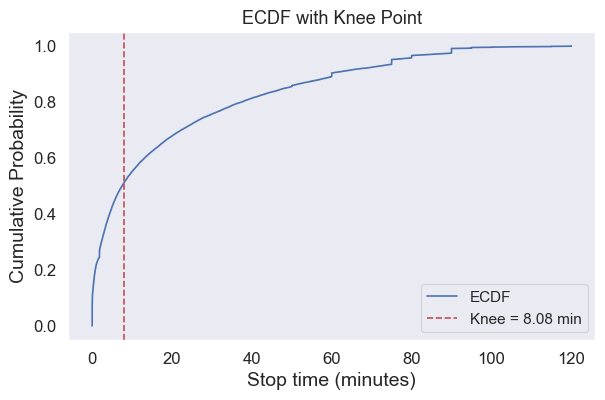

In [36]:
# Assuming df is your DataFrame
df = sequence_stops_night[sequence_stops_night['event_title']!='No event']

# Compute ECDF
sorted_durations = np.sort(df['duration_stop_mins'])
ecdf = np.arange(1, len(sorted_durations) + 1) / len(sorted_durations)

# Find the knee point
kneedle = KneeLocator(sorted_durations, ecdf, curve="concave", direction="increasing",S=1)

# Plot ECDF with knee point
plt.figure(figsize=(6.8, 4))
plt.plot(sorted_durations, ecdf, label="ECDF")
plt.axvline(kneedle.knee, color='r', linestyle='--', label=f"Knee = {kneedle.knee:.2f} min")
plt.xlabel("Stop time (minutes)")
plt.ylabel("Cumulative Probability")
plt.title("ECDF with Knee Point")
plt.legend()
plt.show()

Plots for the document.

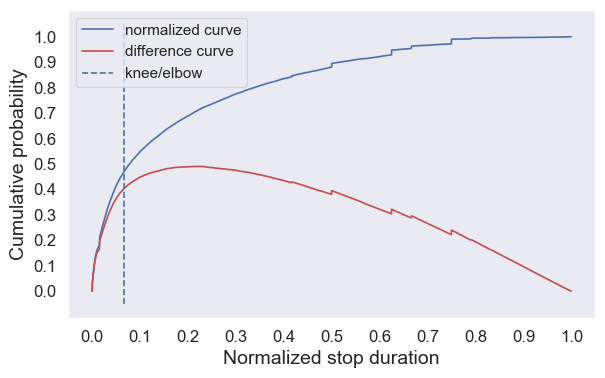

In [37]:
kneedle.plot_knee_normalized(figsize=(6.8, 4),
                             xlabel='Normalized stop duration',
                             ylabel='Cumulative probability',
                             title=None)

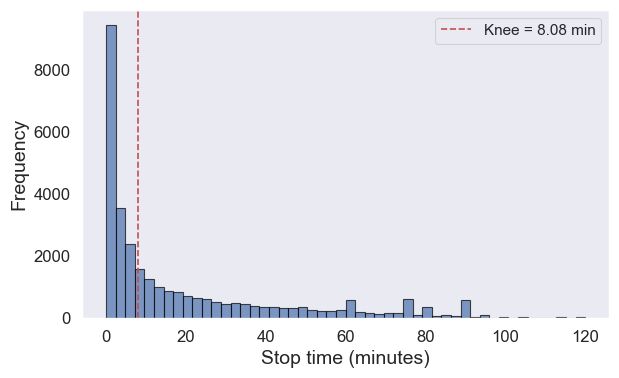

In [38]:
# Create side-by-side plots
plt.figure(figsize=(6.8, 4))

# Histogram with knee point
plt.hist(df['duration_stop_mins'], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(kneedle.knee, color='r', linestyle='--', label=f"Knee = {kneedle.knee:.2f} min")
plt.xlabel("Stop time (minutes)")
plt.ylabel("Frequency")
#plt.title("Histogram of Stop Times")
plt.legend()

The knee point yields a reasonable threshold for a stop (event/stage switch), so I fix that value.

In [39]:
threshold_stop_duration = round(kneedle.knee,2)
threshold_stop_duration

8.08

#### Filtering the tables with the stop duration threshold

In [40]:
sequence_stops_night_filtered = sequence_stops_night.loc[sequence_stops_night['duration_stop_mins']>=threshold_stop_duration]

print(f'Shape of sequence_stops_night: {sequence_stops_night.shape}')
print(f'Records of the sequence_stops_night by night: \n{sequence_stops_night.groupby("tid").size()}')


print(f'\nShape of sequence_stops_night_filtered: {sequence_stops_night_filtered.shape}')
print(f'Records of the sequence_stops_night_filtered by night: \n{sequence_stops_night_filtered.groupby("tid").size()}')

Shape of sequence_stops_night: (66865, 23)
Records of the sequence_stops_night by night: 
tid
1    31671
2    35194
dtype: int64

Shape of sequence_stops_night_filtered: (20987, 23)
Records of the sequence_stops_night_filtered by night: 
tid
1     9845
2    11142
dtype: int64


Applying this filter results in some trajectories being removed. As these trajectories do not provide meaningful information (they don't have a single stop that lasts more than the threshold), they will not be analyzed.

In [41]:
print(f'Number of records Sónar by night (unfiltered table):')
display(duckdb_conn.sql("""
                        SELECT tid, COUNT(*) AS total_records
                        FROM trajectories_events_night
                        GROUP BY tid

                        UNION ALL

                        SELECT 'Total' AS tid, COUNT(*) AS total_records
                        FROM trajectories_events_night
                        """))


print(f'Unique macadresses Sónar by night (unfiltered table):')
display(duckdb_conn.sql("""
                        SELECT tid, COUNT(DISTINCT uid) AS unique_user_count
                        FROM trajectories_events_night
                        GROUP BY tid

                        UNION ALL

                        SELECT 'Total' AS tid, COUNT(DISTINCT uid) AS unique_user_count
                        FROM trajectories_events_night
                        """))

print(f'Number of unique uid-tid (trajectories - filtered table):')

n_trajectories_unfiltered = duckdb_conn.sql("""
                                            SELECT COUNT(DISTINCT CONCAT(uid, '-', tid)) AS unique_trajectory_count
                                            FROM trajectories_events_night
                                            """).fetchone()[0]
print(n_trajectories_unfiltered)

Number of records Sónar by night (unfiltered table):


┌─────────┬───────────────┐
│   tid   │ total_records │
│ varchar │     int64     │
├─────────┼───────────────┤
│ 1       │        575242 │
│ 2       │        669219 │
│ Total   │       1244461 │
└─────────┴───────────────┘

Unique macadresses Sónar by night (unfiltered table):


┌─────────┬───────────────────┐
│   tid   │ unique_user_count │
│ varchar │       int64       │
├─────────┼───────────────────┤
│ 2       │              1977 │
│ 1       │              1869 │
│ Total   │              2795 │
└─────────┴───────────────────┘

Number of unique uid-tid (trajectories - filtered table):
3846


In [42]:
trajectories_events_night_filtered = pd.merge(trajectories_events_night,
                                              sequence_stops_night_filtered[['uid','tid']],
                                              on=['uid','tid'],
                                              how='inner')

print(f'Number of records Sónar by night (filtered table):')
display(duckdb_conn.sql("""
                        SELECT tid, COUNT(*) AS total_records
                        FROM trajectories_events_night_filtered
                        GROUP BY tid

                        UNION ALL

                        SELECT 'Total' AS tid, COUNT(*) AS total_records
                        FROM trajectories_events_night_filtered
                        """))


print(f'Unique macadresses Sónar by night (filtered table):')
display(duckdb_conn.sql("""
                        SELECT tid, COUNT(DISTINCT uid) AS unique_user_count
                        FROM trajectories_events_night_filtered
                        GROUP BY tid

                        UNION ALL

                        SELECT 'Total' AS tid, COUNT(DISTINCT uid) AS unique_user_count
                        FROM trajectories_events_night_filtered
                        """))


print(f'Number of unique uid-tid (trajectories - filtered table):')
display()
n_trajectories_filtered = duckdb_conn.sql("""
                                            SELECT COUNT(DISTINCT CONCAT(uid, '-', tid)) AS unique_trajectory_count
                                            FROM trajectories_events_night_filtered
                                            """).fetchone()[0]
print(n_trajectories_filtered)

Number of records Sónar by night (filtered table):


┌─────────┬───────────────┐
│   tid   │ total_records │
│ varchar │     int64     │
├─────────┼───────────────┤
│ 2       │       5712501 │
│ 1       │       4681560 │
│ Total   │      10394061 │
└─────────┴───────────────┘

Unique macadresses Sónar by night (filtered table):


┌─────────┬───────────────────┐
│   tid   │ unique_user_count │
│ varchar │       int64       │
├─────────┼───────────────────┤
│ 2       │              1907 │
│ 1       │              1780 │
│ Total   │              2731 │
└─────────┴───────────────────┘

Number of unique uid-tid (trajectories - filtered table):
3687


In [43]:
print(f'Difference in number of trajectories: \n{n_trajectories_unfiltered-n_trajectories_filtered}')

Difference in number of trajectories: 
159


Checking how the summarized sequence of event looks with respect to the original trajectories.

In [44]:
def visualize_sequence_stops_tdf(full_trajectories_df, sequence_stops_df,
                                  example_idx=0, given_uid=None, background_sonar='night',
                                  **kwargs):
    
    # Selecting a single user
    if given_uid is None:
        example_uid = sequence_stops_df['uid'].unique()[example_idx]
    else:
        example_uid = given_uid

    full_trajectories_example_uid = full_trajectories_df[full_trajectories_df['uid']==example_uid]
    sequence_events_example_uid = sequence_stops_df[sequence_stops_df['uid']==example_uid]
    
    
    tdf_full_example_id = skmob.TrajDataFrame(full_trajectories_example_uid,
                                     longitude='lng', latitude='lat',
                                     datetime='datetime',
                                     user_id='uid',
                                     trajectory_id='tid')

    tdf_sequence_events_example_id = skmob.TrajDataFrame(sequence_events_example_uid,
                                                         longitude='lng_centroid', latitude='lat_centroid',
                                                         datetime='start_time_stop',
                                                         user_id='uid',
                                                         trajectory_id='tid')
    
    # Plotting the sequence of events on top of the full trajectory
    tdf_full_map = utils.plot_trajectories_in_context(tdf=tdf_full_example_id,
                                                        background=background_sonar, max_users=1,
                                                        weight=8, hex_color='black', opacity=0.5)
    tdf_sequence_events_map = utils.plot_trajectories_in_context(tdf=tdf_sequence_events_example_id,
                                                                 background=tdf_full_map,
                                                                 max_users=1,
                                                                 **kwargs)
    display(tdf_sequence_events_map)

In [45]:
visualize_sequence_stops_tdf(full_trajectories_df=trajectories_events_night, 
                              sequence_stops_df=sequence_stops_night,
                              example_idx=1,
                              start_end_markers=False)

c:\Users\camal\anaconda3\envs\skmob_updated_h3\lib\site-packages\geopandas\geoseries.py:643: FutureWarning:

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.

c:\Users\camal\anaconda3\envs\skmob_updated_h3\lib\site-packages\skmob\core\trajectorydataframe.py:569: UserWarning:

If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.

c:\Users\camal\anaconda3\envs\skmob_updated_h3\lib\site-packages\skmob\core\trajectorydataframe.py:569: UserWarning:

If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.



In [46]:
visualize_sequence_stops_tdf(full_trajectories_df=trajectories_events_night, 
                              sequence_stops_df=sequence_stops_night_filtered,
                              example_idx=1,
                              start_end_markers=False)

c:\Users\camal\anaconda3\envs\skmob_updated_h3\lib\site-packages\geopandas\geoseries.py:643: FutureWarning:

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.

c:\Users\camal\anaconda3\envs\skmob_updated_h3\lib\site-packages\skmob\core\trajectorydataframe.py:569: UserWarning:

If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.

c:\Users\camal\anaconda3\envs\skmob_updated_h3\lib\site-packages\skmob\core\trajectorydataframe.py:569: UserWarning:

If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.



## Accumulated time spent at each event

The previous computations correspond to a single "visit" to an event, but a single user may have multiple "visits" to the same event in case thay went away and came back. 

To check the distribution of time spent at each event, I will accumulate all visits for each event to account for people who may have stepped out of the stages and came back to the event. This can be seen as a complete "attendance" to an event

In [47]:
events_acc_visits_durations_night = sequence_stops_night_filtered.groupby(['uid', 'tid',
                                                                           'macaddr_randomized',
                                                                           'stage',
                                                                           'stage_area_m2',
                                                                           'event_duration_timetable_mins',
                                                                           'music_type', 'genre_grouped', 'views_youtube', 
                                                                           'event_title'], as_index=False).agg({'duration_stop_mins':'sum'})
events_acc_visits_durations_night.rename(columns={'duration_stop_mins':'time_at_event_mins'}, inplace=True)
events_acc_visits_durations_night.shape

(13806, 11)

In [ ]:
# Creating a histogram
fig = px.histogram(
    events_acc_visits_durations_night,
    x="time_at_event_mins",
    color="macaddr_randomized",
    #facet_row="tid",
    nbins=200, 
    title=f"Distribution of the time at an event",
    category_orders={"macaddr_randomized": [0, 1]})

# Updating the layout
fig.update_layout(
    xaxis_title="Time at an event (minutes)",
    yaxis_title="Visits",
    title_font_size=16,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14)

fig.show()
#fig.write_html(os.path.join(DESCRIPTIVE_ANALYSIS_PLOTS_PATH,'time_at_events_hist_log.html'))

## Descriptive analysis of the clean data

Grouping by the day (tid), stage_renamed and time_window to compute the number of unique uids for each group (time window), as this will be used in more than one plot.

In [49]:
people_counts_window_stage = (trajectories_events_night.groupby(['tid', 'stage_renamed', 'time_window_15min'], observed=True)
                              .agg(num_people=('uid', 'nunique'))
                              .reset_index())

### People counts by hour and stage label

#### Barplots

In [94]:
def stacked_bars_hour_stage(grouped_df, sonar_type='night'):

    # Pivot data for stacked bar plotting
    pivoted = grouped_df.pivot_table(index=['tid', 'time_window_15min'],
                                     columns='stage_renamed',
                                     values='num_people',
                                     fill_value=0,
                                     observed=True
                                     )

    # Plot for each day/night (represented by tid)
    unique_tids = grouped_df['tid'].unique()

    # Limiting the plot axis to force the alignment between the plots for each day
    min_time_windows = grouped_df.groupby('tid')['time_window_15min'].nunique().min()

    for tid in unique_tids:
        # Filter data for the current day
        tid_data = pivoted.loc[tid]

        # Truncate data to match the minimum number of time windows
        tid_data = tid_data.iloc[:min_time_windows]
        
        # Plot stacked bar chart
        ax = tid_data.plot(kind='bar',
                           stacked=True,
                           figsize=(12, 5),
                           colormap='tab20'
                           )
        
        # Formatting
        ax.set_title(f"Number of people at each stage on {sonar_type} {tid} (Sónar by {sonar_type})")
        ax.set_xlabel("Time window")
        ax.set_ylabel("Unique MAC addresses")
        ax.set_xticks(ticks=range(len(tid_data.index)),
                      labels=tid_data.index.strftime('%H:%M'), 
                      rotation=90)
        ax.legend(title="Stage", loc='upper left')
        plt.tight_layout()
        plt.show()

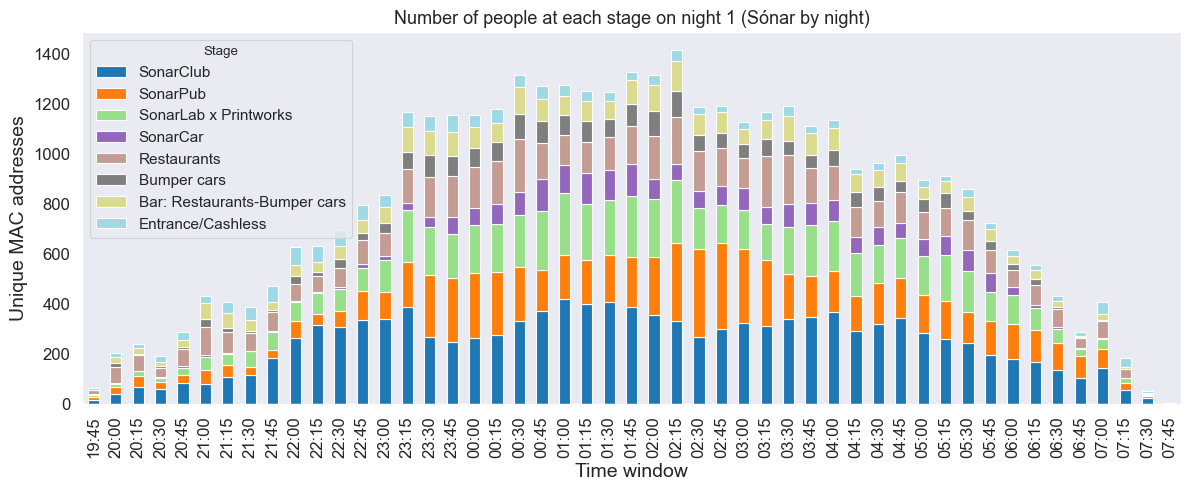

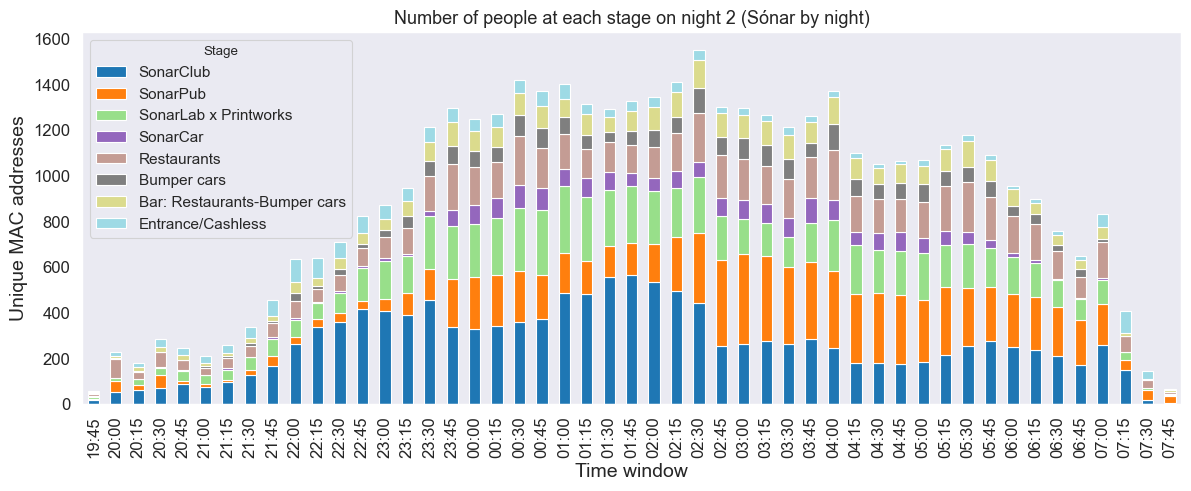

In [95]:
stacked_bars_hour_stage(grouped_df=people_counts_window_stage, sonar_type='night')

#### Heatmaps

I plot the heatmaps with the time windows as x axis and the stages as the y axis. In this case, each cell will represent the proportion of people that are at each stage, relative to the total people at the festival.

In [52]:
people_counts_window_stage_heatmap = utils.proportion_people_stage(trajectories_events_night)

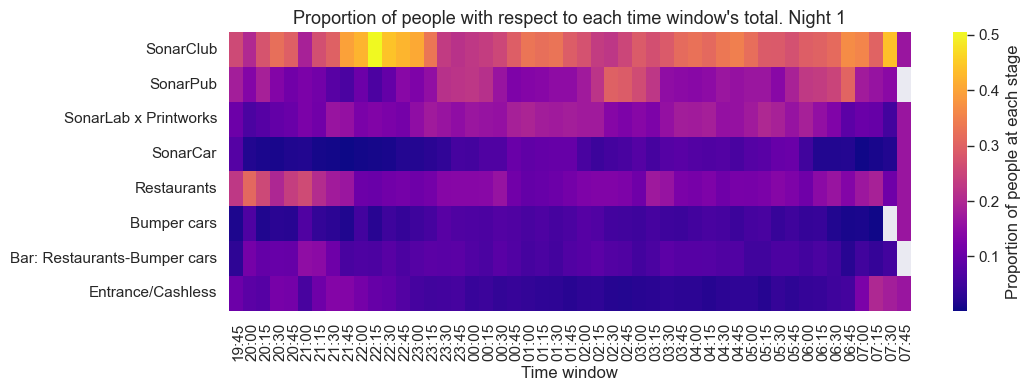

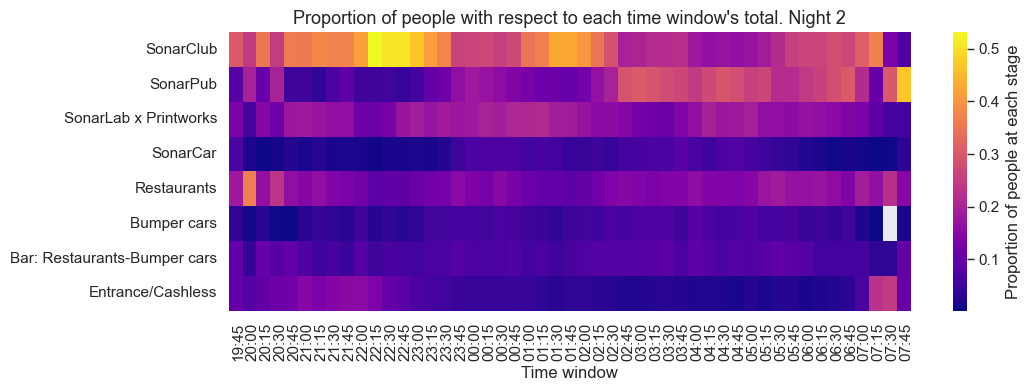

In [53]:
utils.plot_stage_proportion_heatmaps(people_counts_window_stage_heatmap)

#### Audience evolution in each stage (over the time of events)

I compute the amount of unique users that were seen during each event.

In [54]:
# Grouping by event and counting the number of unique MAC addresses
grouped_people_at_events_night = (sequence_stops_night_filtered.groupby(['tid', 'stage_renamed', 'event_title','start_datetime_event'], observed=True)
                                  .agg(num_people=('uid', 'nunique'))
                                  .reset_index())

# Selecting only the cases where there was an event occurring
grouped_people_at_events_night = grouped_people_at_events_night.loc[grouped_people_at_events_night['event_title']!='No event'].reset_index(drop=True)

grouped_people_at_events_night

tid          stage_renamed  \
0     1              SonarClub   
1     1              SonarClub   
2     1              SonarClub   
3     1              SonarClub   
4     1              SonarClub   
5     1              SonarClub   
6     1              SonarClub   
7     1               SonarPub   
8     1               SonarPub   
9     1               SonarPub   
10    1               SonarPub   
11    1               SonarPub   
12    1               SonarPub   
13    1  SonarLab x Printworks   
14    1  SonarLab x Printworks   
15    1  SonarLab x Printworks   
16    1  SonarLab x Printworks   
17    1  SonarLab x Printworks   
18    1  SonarLab x Printworks   
19    1               SonarCar   
20    1               SonarCar   
21    1               SonarCar   
22    1               SonarCar   
23    1               SonarCar   
24    2              SonarClub   
25    2              SonarClub   
26    2              SonarClub   
27    2              SonarClub   
28    2              SonarClub   
29    2              SonarClub   
30    2              SonarClub   
31    2               SonarPub   
32    2               SonarPub   
33    2               SonarPub   
34    2               SonarPub   
35    2               SonarPub   
36    2               SonarPub   
37    2  SonarLab x Printworks   
38    2  SonarLab x Printworks   
39    2  SonarLab x Printworks   
40    2  SonarLab x Printworks   
41    2  SonarLab x Printworks   
42    2  SonarLab x Printworks   
43    2  SonarLab x Printworks   
44    2               SonarCar   
45    2               SonarCar   
46    2               SonarCar   
47    2               SonarCar   
48    2               SonarCar   
49    2               SonarCar   

                                          event_title  \
0                                          Adriatique   
1                              Air play ‘Moon Safari’   
2                                        Arnau Obiols   
3                                     Ben Böhmer live   
4                           Jennifer Cardini b2b HAAi   
5                           Richie Hawtin DEX EFX X0X   
6                                                VTSS   
7                                           DJ Tennis   
8                                      Danny Tenaglia   
9                                         Jessie Ware   
10                                         Kaytranada   
11                                             Spacer   
12              Toy Tonics Jam: Kapote & Sam Ruffillo   
13                                  C.FRIM b2b BAMBII   
14                                          CASISDEAD   
15                           DJ Flight & MC Chickaboo   
16               Eliza Rose b2b Dan Shake b2b Sally C   
17                                               TNTC   
18                                             salute   
19                                   GAZZI b2b DALILA   
20                                    La Goony Chonga   
21  TAYHANA presents Club Latinx w/ Simona, Slim S...   
22                                           Verushka   
23                                              Yosef   
24                                             Anetha   
25            Charlotte de Witte presents 'Overdrive'   
26                         Héctor Oaks b2b Partiboi69   
27               Marlon Hoffstadt aka DJ Daddy Trance   
28                                   Paul Kalkbrenner   
29                                              Raxon   
30                             Reinier Zonneveld live   
31                                               Drea   
32                                    Floating Points   
33         Kerri Chandler presents ‘Reel-2-Reel’ live   
34                                         River Moon   
35                              The Martinez Brothers   
36                                      Vince Staples   
37                                       Cinthie live   
38                                            

Computing the maximum number of attendees seen during an event for each of the stages.

In [55]:
# Group by `tid` and `stage_renamed` to compute the total number of people at each time window
total_people_stage_event_night = (grouped_people_at_events_night.groupby(['tid', 'stage_renamed'], observed=True)
                                  .agg(max_people_stage_event=('num_people', 'max'))
                                  .reset_index()
                                  )

# Merge the total counts back into the grouped data
grouped_people_at_events_night = pd.merge(grouped_people_at_events_night, total_people_stage_event_night, on=['tid', 'stage_renamed'])

# Compute the proportion of people at each stage
grouped_people_at_events_night['proportion_people_stage_event'] = grouped_people_at_events_night['num_people'] / grouped_people_at_events_night['max_people_stage_event']

# Sorting the values for easier visualization
grouped_people_at_events_night = grouped_people_at_events_night.sort_values(by=['tid','stage_renamed','start_datetime_event'])

grouped_people_at_events_night

tid          stage_renamed  \
2     1              SonarClub   
1     1              SonarClub   
4     1              SonarClub   
3     1              SonarClub   
0     1              SonarClub   
5     1              SonarClub   
6     1              SonarClub   
11    1               SonarPub   
9     1               SonarPub   
12    1               SonarPub   
10    1               SonarPub   
7     1               SonarPub   
8     1               SonarPub   
17    1  SonarLab x Printworks   
14    1  SonarLab x Printworks   
16    1  SonarLab x Printworks   
18    1  SonarLab x Printworks   
13    1  SonarLab x Printworks   
15    1  SonarLab x Printworks   
22    1               SonarCar   
20    1               SonarCar   
23    1               SonarCar   
21    1               SonarCar   
19    1               SonarCar   
29    2              SonarClub   
28    2              SonarClub   
24    2              SonarClub   
25    2              SonarClub   
27    2              SonarClub   
30    2              SonarClub   
26    2              SonarClub   
31    2               SonarPub   
36    2               SonarPub   
34    2               SonarPub   
32    2               SonarPub   
35    2               SonarPub   
33    2               SonarPub   
43    2  SonarLab x Printworks   
41    2  SonarLab x Printworks   
42    2  SonarLab x Printworks   
37    2  SonarLab x Printworks   
40    2  SonarLab x Printworks   
39    2  SonarLab x Printworks   
38    2  SonarLab x Printworks   
48    2               SonarCar   
45    2               SonarCar   
47    2               SonarCar   
49    2               SonarCar   
46    2               SonarCar   
44    2               SonarCar   

                                          event_title  \
2                                        Arnau Obiols   
1                              Air play ‘Moon Safari’   
4                           Jennifer Cardini b2b HAAi   
3                                     Ben Böhmer live   
0                                          Adriatique   
5                           Richie Hawtin DEX EFX X0X   
6                                                VTSS   
11                                             Spacer   
9                                         Jessie Ware   
12              Toy Tonics Jam: Kapote & Sam Ruffillo   
10                                         Kaytranada   
7                                           DJ Tennis   
8                                      Danny Tenaglia   
17                                               TNTC   
14                                          CASISDEAD   
16               Eliza Rose b2b Dan Shake b2b Sally C   
18                                             salute   
13                                  C.FRIM b2b BAMBII   
15                           DJ Flight & MC Chickaboo   
22                                           Verushka   
20                                    La Goony Chonga   
23                                              Yosef   
21  TAYHANA presents Club Latinx w/ Simona, Slim S...   
19                                   GAZZI b2b DALILA   
29                                              Raxon   
28                                   Paul Kalkbrenner   
24                                             Anetha   
25            Charlotte de Witte presents 'Overdrive'   
27               Marlon Hoffstadt aka DJ Daddy Trance   
30                             Reinier Zonneveld live   
26                         Héctor Oaks b2b Partiboi69   
31                                               Drea   
36                                      Vince Staples   
34                                         River Moon   
32                                    Floating Points   
35                              The Martinez Brothers   
33         Kerri Chandler presents ‘Reel-2-Reel’ live   
43                                             Swoose   
41                                    Octave O

Definition of the function that plots the audience evolution for each stage.

In [102]:
def plot_bubble_stage_proportions(data, event_renaming_dict=None, sonar_type='night'):
    
    # Get unique days (tids)
    unique_tids = data['tid'].unique()

    for tid in unique_tids:
        # Filter data for the current day (tid)
        tid_data = data[data['tid'] == tid].copy()

        # Create the plot
        plt.figure(figsize=(13, 6))

        # Seaborn scatterplot
        with sns.axes_style("darkgrid"):
            scatter = sns.scatterplot(
                data=tid_data,
                x="start_datetime_event", 
                y="stage_renamed", 
                size="num_people",  # Bubble size
                hue="proportion_people_stage_event",  # Bubble color
                palette="plasma",
                sizes=(100, 2000),  # Bubble size range
                alpha=0.8,
                edgecolor="w", 
                linewidth=0.5,
                legend=False
            )

        # Add event titles as labels to the bubbles

        # Manually modifying some specific labels
        if event_renaming_dict:
            tid_data['event_title'] = tid_data['event_title'].replace(event_renaming_dict)
        
        for i, row in tid_data.iterrows():
            # Regex for splitting long labels
            formatted_title = re.sub(r'\b( & |b2b|presents|aka)\b', r'\n\1\n', row['event_title'], flags=re.IGNORECASE)
            text = plt.text(
                row['start_datetime_event'], 
                row['stage_renamed'], 
                formatted_title, 
                fontsize=12, 
                ha='center', 
                va='center', 
                color='black'
            )
        
            # Add an outline effect to the text
            text.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='white'),
                path_effects.Normal()
            ])

        # General formatting
        plt.title(f"Event attendees for {sonar_type} {tid}")
        plt.xlabel("Start time of events")
        plt.ylabel(None)


        # Format x-axis
        # Generate custom ticks starting 10 minutes after the first event
        min_time = tid_data['start_datetime_event'].min() + pd.Timedelta(minutes=10)
        max_time = tid_data['start_datetime_event'].max()
        custom_ticks = pd.date_range(start=min_time, end=max_time, freq="30min")

        scatter.set_xticks(custom_ticks)
        scatter.set_xticklabels(
            custom_ticks.strftime('%H:%M'), 
            rotation=45
        )

        # Add a color bar for the proportions
        norm = Normalize(tid_data['proportion_people_stage_event'].min(), 
                         tid_data['proportion_people_stage_event'].max())
        sm = cm.ScalarMappable(cmap="plasma", norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.05, pad=0.1)
        cbar.set_label("Proportion of attendees w.r.t. the stage's maximum")


        plt.tight_layout()
        plt.show()

Executing the function.

The size of the bubbles represent the total number of unique MAC addresses (attendees) seen at each event. The color of the bubble is the proportion of attendees at each event with respect to the maximum of each stage in the corresponding day.

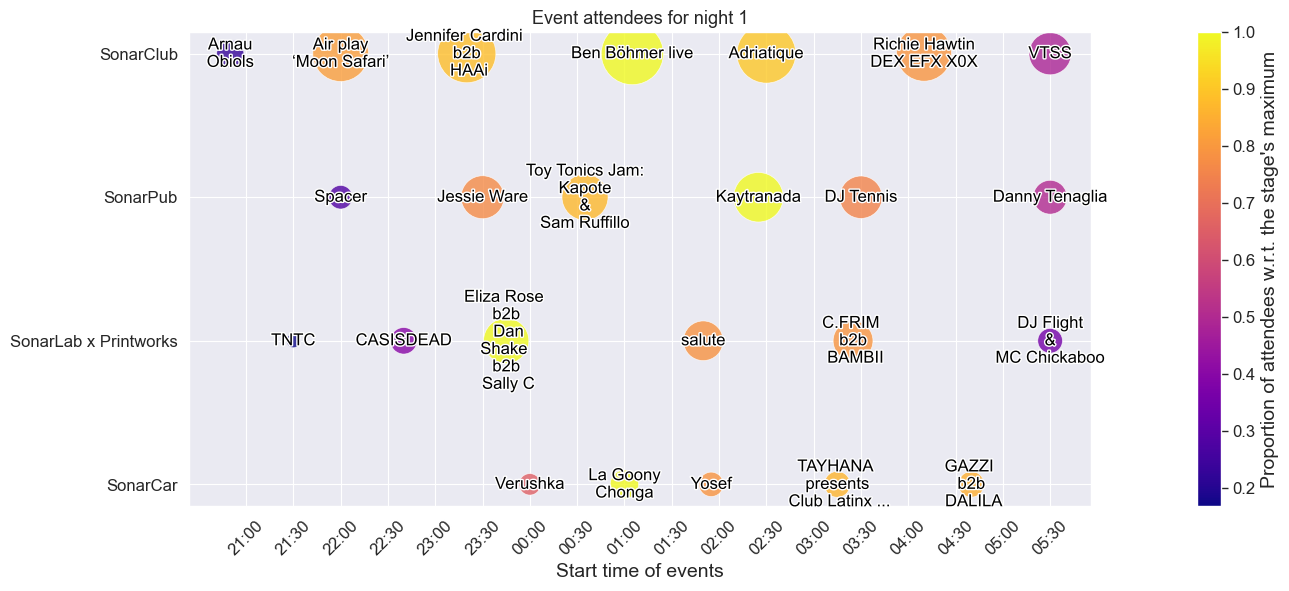

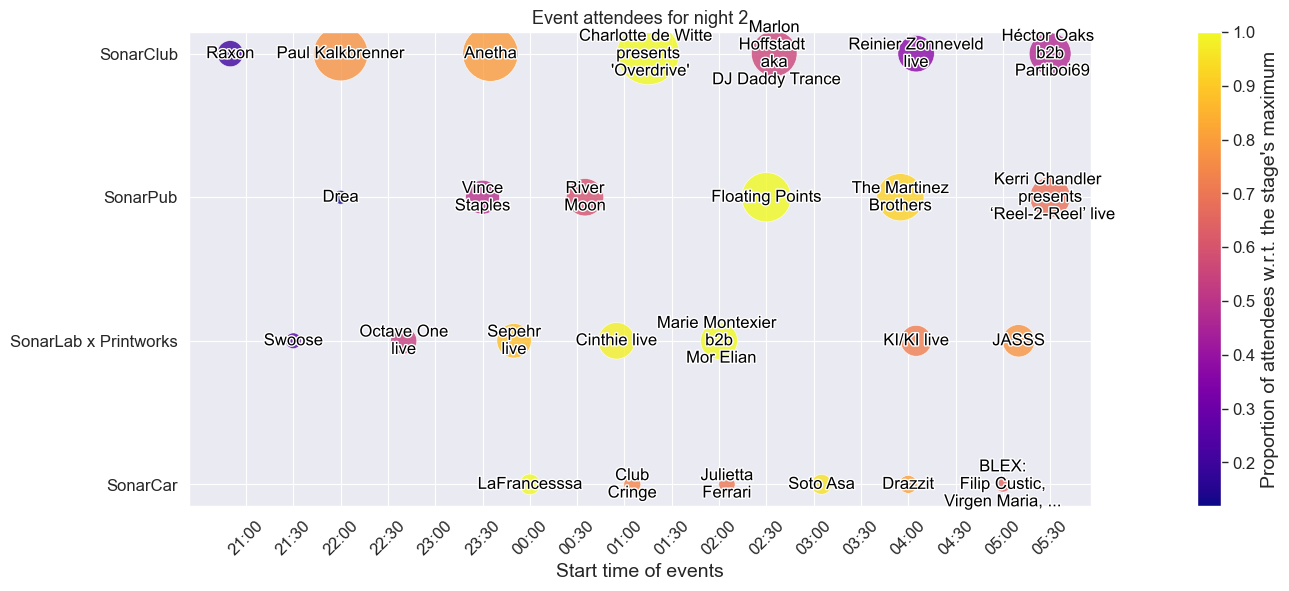

In [103]:
event_renaming_dict_night = {'TAYHANA presents Club Latinx w/ Simona, Slim Soledad & Mare Advertencia':'TAYHANA presents Club Latinx ...',
                             'BLEX: Filip Custic, Virgen Maria, Naive Supreme & Hundred Tauro':'BLEX:\nFilip Custic,\nVirgen Maria, ...',
                             'Toy Tonics Jam: Kapote & Sam Ruffillo':'Toy Tonics Jam:\nKapote & Sam Ruffillo',
                             'Richie Hawtin DEX EFX X0X':'Richie Hawtin\nDEX EFX X0X',
                             'La Goony Chonga':'La Goony\nChonga',
                             'Air play ‘Moon Safari’':'Air play\n‘Moon Safari’',
                             'Reinier Zonneveld live':'Reinier Zonneveld\nlive',
                             'Marlon Hoffstadt aka DJ Daddy Trance':'Marlon\nHoffstadt aka DJ Daddy Trance',
                             'The Martinez Brothers':'The Martinez\nBrothers',
                             'Club Cringe':'Club\nCringe', 
                             'Julietta Ferrari':'Julietta\nFerrari',
                             'Arnau Obiols':'Arnau\nObiols',
                             'Eliza Rose b2b Dan Shake b2b Sally C':'Eliza Rose b2b Dan\nShake b2b Sally C',
                             'Octave One live':'Octave One\nlive',
                             'Vince Staples':'Vince\nStaples', 'River Moon':'River\nMoon',
                             'Sepehr live':'Sepehr\nlive'}

# Call the function with your DataFrame

plot_bubble_stage_proportions(grouped_people_at_events_night, event_renaming_dict=event_renaming_dict_night)

### H3 counts (descriptive)

Obtaining the cloropleth map with counts for the clean data (after the trajectory preprocessing).

In [58]:
records_per_cell_clean_night = utils.trajectories_to_h3_counts_gdf(trajectories_df=trajectories_events_night,
                                                                    count_type='records',
                                                                    window_duration=None,
                                                                    sonar_type='night')

In [ ]:
utils.plot_counts_per_cell(sonar_type='night', h3_cells_counts=records_per_cell_clean_night,
                           caption=f"Observation count per H3 Cell (with preprocessed trajectories)",
                           filename_to_save=None)
#filename_to_save=os.path.join(DESCRIPTIVE_ANALYSIS_PLOTS_PATH,'cell_total_observations_static.html')'''

#### H3 counts evolution

Plotting the evolution of unique MAC addresses spatial distribution over time. I will use a 5 minute time window and plot it over time with the function defined in `utils.py`.

##### Both nights in one figure (5 mins)

In [10]:
'''utils.plot_counts_per_cell_timeline(h3_cells_counts=users_h3_time_window_5min, sonar_type='night',
                                    caption='Unique MAC addresses per H3 cell. Sónar by Night', 
                                    filename_to_save=None, 
                                    return_map=True)
#filename_to_save=os.path.join(DESCRIPTIVE_ANALYSIS_PLOTS_PATH,'cell_people_counts_5min_windows.html')'''

"utils.plot_counts_per_cell_timeline(h3_cells_counts=users_h3_time_window_5min, sonar_type='night',\n                                    caption='Unique MAC addresses per H3 cell. Sónar by Night', \n                                    filename_to_save=None, \n                                    return_map=True)\n#filename_to_save=os.path.join(DESCRIPTIVE_ANALYSIS_PLOTS_PATH,'cell_people_counts_5min_windows.html')"

##### Cloropleth evolution for night 1 (15 mins)

I also draw one figure for each of the nights. This time I use the 15 min windows.

In [61]:
users_h3_time_window_15min_night1 = utils.trajectories_to_h3_counts_gdf(trajectories_df=trajectories_events_night.loc[trajectories_events_night['tid']==1],
                                                                        count_type='users',
                                                                        window_duration='15min',
                                                                        sonar_type='night')

In [11]:
'''utils.plot_counts_per_cell_timeline(h3_cells_counts=users_h3_time_window_15min_night1, sonar_type='night', window_duration='15min',
                                    caption='Unique MAC addresses per H3 cell. Night 1', 
                                    filename_to_save=None, 
                                    return_map=True)
#filename_to_save=os.path.join(DESCRIPTIVE_ANALYSIS_PLOTS_PATH,'cell_people_counts_15min_windows_n1.html')'''

"utils.plot_counts_per_cell_timeline(h3_cells_counts=users_h3_time_window_15min_night1, sonar_type='night', window_duration='15min',\n                                    caption='Unique MAC addresses per H3 cell. Night 1', \n                                    filename_to_save=None, \n                                    return_map=True)\n#filename_to_save=os.path.join(DESCRIPTIVE_ANALYSIS_PLOTS_PATH,'cell_people_counts_15min_windows_n1.html')"

##### Cloropleth evolution for night 2  (15 mins)

I also draw one figure for each of the nights. This time I use the 15 min windows.

In [63]:
users_h3_time_window_15min_night = utils.trajectories_to_h3_counts_gdf(trajectories_df=trajectories_events_night.loc[trajectories_events_night['tid']==2],
                                                                        count_type='users',
                                                                        window_duration='15min',
                                                                        sonar_type='night')

In [12]:
'''utils.plot_counts_per_cell_timeline(h3_cells_counts=users_h3_time_window_15min_night2, sonar_type='night', window_duration='15min', 
                                    caption='Unique MAC addresses per H3 cell. Night 2', 
                                    filename_to_save=None, 
                                    return_map=True)
#filename_to_save=os.path.join(DESCRIPTIVE_ANALYSIS_PLOTS_PATH,'cell_people_counts_15min_windows_n2.html')'''

"utils.plot_counts_per_cell_timeline(h3_cells_counts=users_h3_time_window_15min_night2, sonar_type='night', window_duration='15min', \n                                    caption='Unique MAC addresses per H3 cell. Night 2', \n                                    filename_to_save=None, \n                                    return_map=True)\n#filename_to_save=os.path.join(DESCRIPTIVE_ANALYSIS_PLOTS_PATH,'cell_people_counts_15min_windows_n2.html')"

### Event scores and rankings

#### Score computation

I follow the score proposed in the previous Sónar paper, which can be written as follows:

$$
   score_{u,e} = \frac{1}{\sum_{\tilde{e} \in s(e)} duration_{u,\tilde{e}}} \left( \frac{duration_{u,e}}{\sum_{e \in E} duration_{u,e}} \right)
$$

Where $duration_{u,e}$ is the duration of user $u$ at event $e$, $E$ is the set of events and ${\sum_{\tilde{e} \in s(e)} duration_{u,\tilde{e}}}$ is the total amount of time a user $u$ spent in the stage $s$ where event $e$ ocurred.

To make the ranking, they use a "general factor", $\log \left( \frac{duration_e}{l_e \cdot c_{s,e}} \right)$, that weighs each score based on:
- The total time spent by all users at event $e$, $duration_e$
- The amount of time allocated for the event $e$, $l_e$
- The capacity of the stage $s$ where event $e$ ocurred, $c_{s,e}$

After incorporating the general factor, the factor-adjusted score becomes:
 $$
   adj\_score_{u,e} = \frac{1}{\sum_{\tilde{e} \in s(e)} duration_{u,\tilde{e}}} \left( \frac{duration_{u,e}}{\sum_{e \in E} duration_{u,e}} \right) \log \left( \frac{duration_e}{l_e \cdot c_{s,e}} \right)
$$

In [65]:
events_acc_visits_durations_night.dtypes

uid                               object
tid                                int64
macaddr_randomized                 int64
stage                             object
stage_area_m2                      int64
event_duration_timetable_mins    float64
music_type                        object
genre_grouped                     object
views_youtube                    float64
event_title                       object
time_at_event_mins               float64
dtype: object

In [66]:
def compute_user_event_scores(events_acc_visits_durations_df):
    # Compute total duration per stage for each user and trajectory
    stage_time_totals = events_acc_visits_durations_df.groupby(['uid', 'tid', 'stage'])['time_at_event_mins'].sum().reset_index()
    stage_time_totals.rename(columns={'time_at_event_mins': 'total_time_at_stage_mins'}, inplace=True)

    # Compute total duration across all events for each user and trajectory
    user_event_time_totals = events_acc_visits_durations_df.groupby(['uid', 'tid'])['time_at_event_mins'].sum().reset_index()
    user_event_time_totals.rename(columns={'time_at_event_mins': 'total_time_at_events_mins'}, inplace=True)

    # Merge complete "attendances" table to obtain the computed values for each 
    # singular example (a combination of uid-tid-event_title).
    event_scores = pd.merge(events_acc_visits_durations_df, user_event_time_totals, on=['uid','tid'], how='left')
    event_scores = pd.merge(event_scores, stage_time_totals, on=['uid','tid','stage'], how='left')

    # Compute the score
    event_scores['score'] = ((1 / event_scores['total_time_at_stage_mins']) * (event_scores['time_at_event_mins'] / event_scores['total_time_at_events_mins']))

    #--------------------------------------------------------------
    # "General factor" computations

    # Audience total durations at event e
    audience_event_time_totals =  events_acc_visits_durations_df.groupby('event_title')['time_at_event_mins'].sum().reset_index()
    audience_event_time_totals.rename(columns={'time_at_event_mins': 'total_audience_time_at_event_mins'}, inplace=True)

    # Merge the audience total times to the scores table
    event_scores = pd.merge(event_scores, audience_event_time_totals, on='event_title')

    # Compute the general factor
    event_scores['general_factor'] = np.log(event_scores['total_audience_time_at_event_mins'] /
                                            (event_scores['event_duration_timetable_mins']*(event_scores['stage_area_m2']*1e-4))) # Area in cm2 for better readability of the general factor

    # Compute the adjusted score
    event_scores['adj_score'] = event_scores['score'] * event_scores['general_factor'] # I added a factor for easier visualization

    return event_scores

In [67]:
# Execute the function to compute the score
user_event_scores_durations_night = compute_user_event_scores(events_acc_visits_durations_df=events_acc_visits_durations_night)
user_event_scores_durations_night

uid  tid  \
0      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
1      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
2      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
3      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
4      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
...                                                  ...  ...   
13801  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
13802  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
13803  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
13804  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
13805  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   

       macaddr_randomized                  stage  stage_area_m2  \
0                       1               SonarCar           2688   
1                       1               SonarCar           2688   
2                       1              SonarClub          14914   
3                       1              SonarClub          14914   
4                       1              SonarClub          14914   
...                   ...                    ...            ...   
13801                   1  SonarLab x Printworks           9171   
13802                   1  SonarLab x Printworks           9171   
13803                   1  SonarLab x Printworks           9171   
13804                   1  SonarLab x Printworks           9171   
13805                   1  SonarLab x Printworks           9171   

       event_duration_timetable_mins music_type          genre_grouped  \
0                               50.0       LIVE           other_genres   
1                               55.0       LIVE    electronic_hypnotic   
2                               75.0       LIVE    electronic_hypnotic   
3                               90.0         DJ    electronic_hypnotic   
4                               90.0       LIVE    electronic_hypnotic   
...                              ...        ...                    ...   
13801                           60.0       LIVE           other_genres   
13802                           90.0         DJ  electronic_accessible   
13803                           90.0         DJ    electronic_hypnotic   
13804                          120.0         DJ  electronic_accessible   
13805                          120.0         DJ    electronic_hypnotic   

       views_youtube                              event_title  \
0        153053094.0                                 Soto Asa   
1            10274.0                             LaFrancesssa   
2        164591762.0  Charlotte de Witte presents 'Overdrive'   
3          1146541.0                                   Anetha   
4        370125764.0                         Paul Kalkbrenner   
...              ...                                      ...   
13801     29812785.0                                CASISDEAD   
13802      3334941.0                                   salute   
13803            0.0                 DJ Flight & MC Chickaboo   
13804     82644275.0     Eliza Rose b2b Dan Shake b2b Sally C   
13805       382833.0                        C.FRIM b2b BAMBII   

       time_at_event_mins  total_time_at_events_mins  \
0               21.400000                 157.500000   
1               23.483333                 157.500000   
2               26.350000                 157.500000   
3                9.283333                 157.500000   
4               19.366667                 157.500000   
...                   ...                        ...   
13801           46.516667                 419.716667   
13802           85.083333                 419.716667   
13803           55.866667                 419.716667   
13804          120.000000                 419.716667   
13805          112.250000                 419.716667   

       total_time_at_stage_mins     score  total_audience_time_at_event_mins  \
0                     44.883333  0.003027   

#### Rankings

The ranking is based on the sum of the individual adjusted scores for each event (these functions are computed in `utils.py` as they may be reused in other scripts):

$$
ranking\_points_e = \sum_{e \in {E}}{adj\_score_{u,e}}
$$

In [68]:
event_final_scores = utils.compute_event_final_scores(user_event_scores_durations_df=user_event_scores_durations_night)
event_final_scores

event_title                  stage  \
8             Charlotte de Witte presents 'Overdrive'              SonarClub   
32                                   Paul Kalkbrenner              SonarClub   
1                              Air play ‘Moon Safari’              SonarClub   
5                                     Ben Böhmer live              SonarClub   
17                                    Floating Points               SonarPub   
2                                              Anetha              SonarClub   
25                                         Kaytranada               SonarPub   
35                          Richie Hawtin DEX EFX X0X              SonarClub   
0                                          Adriatique              SonarClub   
21                          Jennifer Cardini b2b HAAi              SonarClub   
43                              The Martinez Brothers               SonarPub   
26         Kerri Chandler presents ‘Reel-2-Reel’ live               SonarPub   
16               Eliza Rose b2b Dan Shake b2b Sally C  SonarLab x Printworks   
22                                        Jessie Ware               SonarPub   
19                         Héctor Oaks b2b Partiboi69              SonarClub   
45                                               VTSS              SonarClub   
44              Toy Tonics Jam: Kapote & Sam Ruffillo               SonarPub   
30               Marlon Hoffstadt aka DJ Daddy Trance              SonarClub   
9                                        Cinthie live  SonarLab x Printworks   
20                                              JASSS  SonarLab x Printworks   
29                      Marie Montexier b2b Mor Elian  SonarLab x Printworks   
47                                      Vince Staples               SonarPub   
6                                   C.FRIM b2b BAMBII  SonarLab x Printworks   
34                             Reinier Zonneveld live              SonarClub   
27                                    La Goony Chonga               SonarCar   
12                                          DJ Tennis               SonarPub   
37                                        Sepehr live  SonarLab x Printworks   
36                                         River Moon               SonarPub   
18                                   GAZZI b2b DALILA               SonarCar   
49                                             salute  SonarLab x Printworks   
41  TAYHANA presents Club Latinx w/ Simona, Slim S...               SonarCar   
13                                     Danny Tenaglia               SonarPub   
24                                         KI/KI live  SonarLab x Printworks   
28                                       LaFrancesssa               SonarCar   
3                                        Arnau Obiols              SonarClub   
10                                        Club Cringe               SonarCar   
31                                    Octave One live  SonarLab x Printworks   
46                                           Verushka               SonarCar   
38                                           Soto Asa               SonarCar   
48                                              Yosef               SonarCar   
33                                              Raxon              SonarClub   
7                                           CASISDEAD  SonarLab x Printworks   
14                                            Drazzit               SonarCar   
23                                   Julietta Ferrari               SonarCar   
39                                             Spacer               SonarPub   
11                           DJ Flight & MC Chickaboo  SonarLab x Printworks   
4   BLEX: Filip Custic, Virgen Maria, Naive Suprem...               SonarCar   
15                                               Drea               SonarPub   
40                                             Swoose  SonarLab x Printworks   
42                                        

C:\Camilo\Estudio\Padova\Master thesis\master-thesis-code\utils.py:553: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



Ranking plot saved in ..\reports\figures\6-descriptive-analysis-plots\rankings_general.pdf


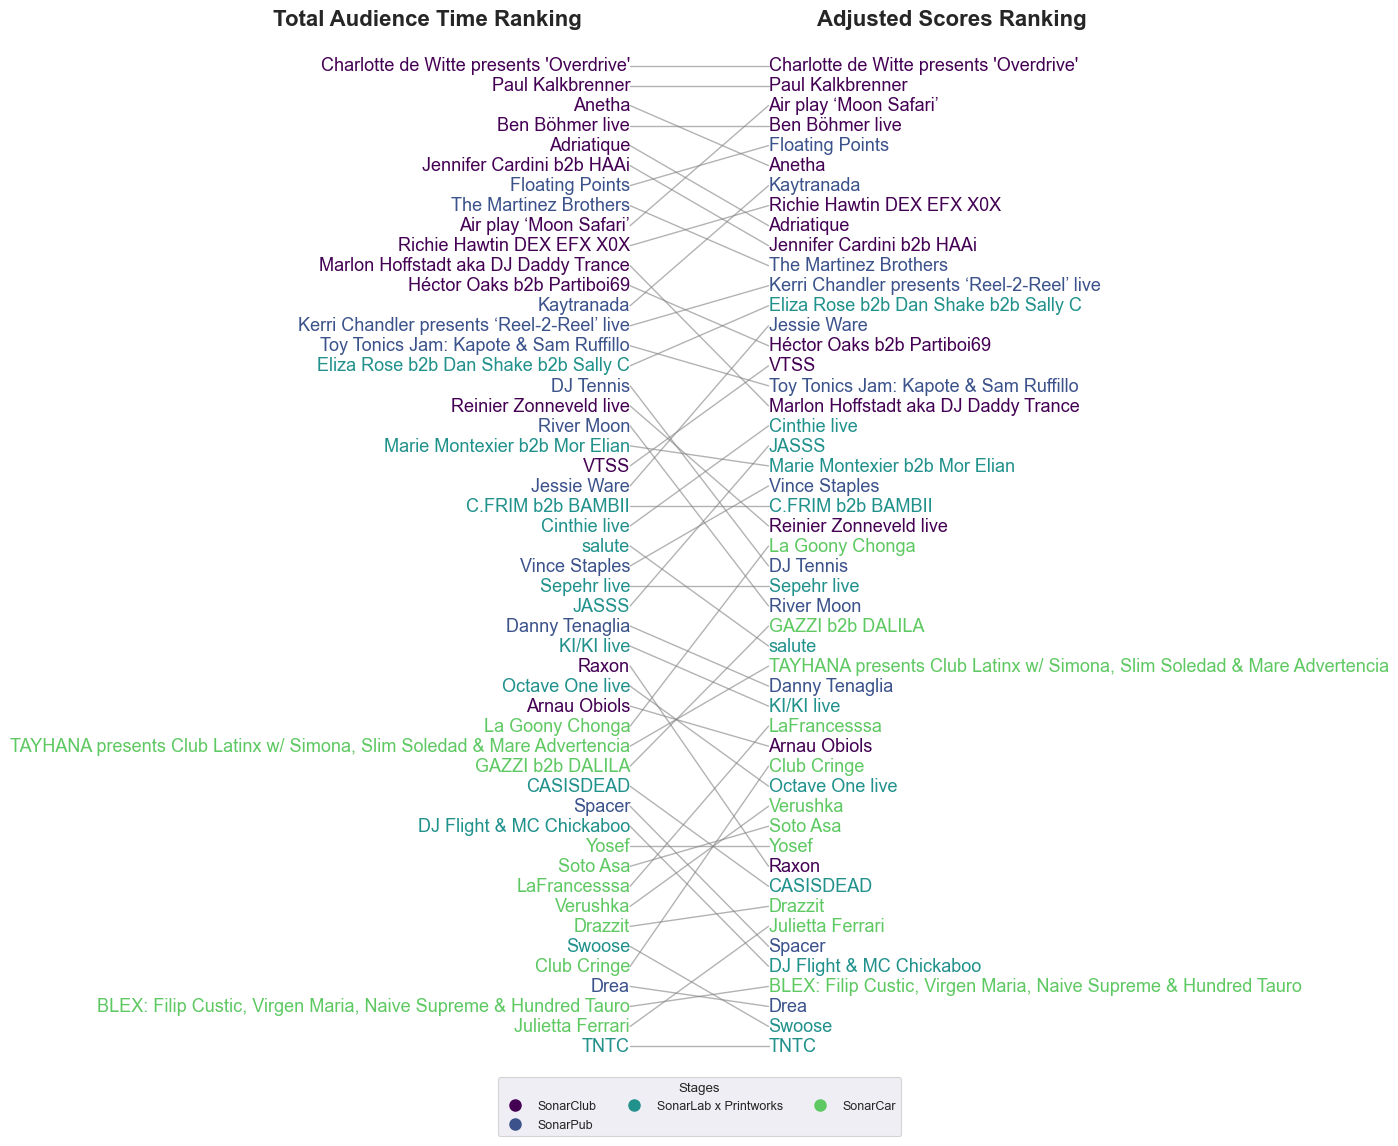

In [ ]:
utils.plot_rankings(scores_df=event_final_scores, filename_to_save = os.path.join(DESCRIPTIVE_ANALYSIS_PLOTS_PATH,'rankings_general.pdf'))

## Model's features computations

### General calculations per trajectory

Grouping the complete (noise-filtered) trajectories to make the computations. This trajectory better captures the whole mobility of attendands during the festival, while the `sequence_stops_night_filtered` captuers the "behavioral" part of the trajectory in a more summarized way, but loses movement granularity.

In [70]:
trajectories_events_grouped_night_filtered = trajectories_events_night_filtered.groupby(['uid', 'tid'])

#### Total time at the festival, arrival/departure times, average density

In [71]:
trajectory_general_measures_night = (trajectories_events_grouped_night_filtered
                                     .agg(observations_user_night_original=('observations_user_night_original','max'), # There is only one value per trajectory. I use max to yield an int
                                          timespan_festival_mins=("timestamp_ap", lambda x: (x.max() - x.min()) / 60),
                                          average_cell_density=('cell_density','mean'),
                                          arrival_festival_epoch=("timestamp_ap", "min"),
                                          departure_festival_epoch=("timestamp_ap", "max"))
                                    .reset_index()
                                    .sort_values(by=['uid','arrival_festival_epoch']))

trajectory_general_measures_night.shape

(3687, 7)

I want to compute the time of arrival/departure of the attendees. However, in case I wanted to perform any analysis that includes the two days I should not use the raw timestamp, as it is tied with the day of attendance. For clustering, for example, it would split the trajectories into groups related to each day. 

For this reason, these times are computed as relative to the start of events for each day and converted to minutes, as it is easier to read and more informative.

In [72]:
# Convert the start time constants to epoch timestamps
start_night_1_epoch = pd.Timestamp(constants.START_NIGHT_1_STRING, tz='Europe/Madrid').timestamp()
start_night_2_epoch = pd.Timestamp(constants.START_NIGHT_2_STRING, tz='Europe/Madrid').timestamp()

# Create a mapping of start times for each night
start_times = {1: start_night_1_epoch, 2: start_night_2_epoch}

In [73]:
# Substract and convert to minutes
start_times_array = trajectory_general_measures_night['tid'].map(start_times).to_numpy()
trajectory_general_measures_night['arrival_festival_mins'] = (trajectory_general_measures_night['arrival_festival_epoch'] - start_times_array) / 60
trajectory_general_measures_night['departure_festival_mins'] = (trajectory_general_measures_night['departure_festival_epoch'] - start_times_array) / 60

trajectory_general_measures_night

uid  tid  \
0     00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
1     00172b78731070270dce8dedf92bbdf28e6de7fda23a80...    1   
2     00172b78731070270dce8dedf92bbdf28e6de7fda23a80...    2   
3     00239ab9980168742b141e32cfaa2e4de212b15b84edd8...    2   
4     005c6a47a37ff89bf901c710d8e9fea6e0e4c906e6be07...    2   
...                                                 ...  ...   
3682  ffd9ebc84071104723c5762121c0bde4905de265f7716b...    1   
3683  ffd9ebc84071104723c5762121c0bde4905de265f7716b...    2   
3684  ffdcc358cd7202ecd02a44e6d6d69b358c6d5ee4b59fa7...    1   
3685  ffdcc358cd7202ecd02a44e6d6d69b358c6d5ee4b59fa7...    2   
3686  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   

      observations_user_night_original  timespan_festival_mins  \
0                                  586              340.900000   
1                                  185              443.533333   
2                                   84              341.883333   
3                                  921              218.116667   
4                                   76              613.450000   
...                                ...                     ...   
3682                               847              401.116667   
3683                               414              311.300000   
3684                               425              235.366667   
3685                               714              412.050000   
3686                               714              510.433333   

      average_cell_density  arrival_festival_epoch  departure_festival_epoch  \
0                 6.263383              1718483927                1718504381   
1                 5.654762              1718401292                1718427904   
2                 5.825000              1718494178                1718514691   
3                10.038905              1718494588                1718507675   
4                 1.739130              1718474962                1718511769   
...                    ...                     ...                       ...   
3682              3.970173              1718395247                1718419314   
3683              5.343750              1718481702                1718500380   
3684              3.718644              1718402982                1718417104   
3685              5.086207              1718486608                1718511331   
3686              5.737097              1718395271                1718425897   

      arrival_festival_mins  departure_festival_mins  
0                168.783333               509.683333  
1                231.533333               675.066667  
2                339.633333               681.516667  
3                346.466667               564.583333  
4                 19.366667               632.816667  
...                     ...                      ...  
3682             130.783333               531.900000  
3683             131.700000               443.000000  
3684             259.700000               495.066667  
3685             213.466667               625.516667  
3686             131.183333               641.616667  

[3687 rows x 9 columns]

#### Number of attended events

The number of attended events is computed from the `sequence_stops_night_filtered`, as it removed people "passing" through the stages.

In [74]:
# Function to compute the number of attended events by a trajectory
# It only considers actual events ('No event' is not included)
def count_attended_events(sequence_stops_filtered):
    sequence_stops_only_events = sequence_stops_filtered.loc[sequence_stops_filtered['event_title']!='No event']
    num_attended_events = sequence_stops_only_events['event_title'].nunique()
    return num_attended_events

In [75]:
# Applying the function to count events
trajectory_attended_events = (sequence_stops_night_filtered.groupby(['uid', 'tid']).apply(count_attended_events, include_groups=False)
                              .reset_index(name='num_attended_events'))

# Joining back to the general df
trajectory_general_measures_night = pd.merge(trajectory_general_measures_night, trajectory_attended_events,
                                             how = 'inner', on=['uid','tid'])

trajectory_general_measures_night.shape

(3687, 10)

#### Overall durations by genre (type of event)

The `genre_grouped` is a column that was manually added to the timetables based on the Sónar descriptions and the information from the internet. Although the genres of the festival are mostly electronic music, this column might be a little more informative than the `music_type` feature.

In [76]:
# Pivot the table for obtaining the duration at each stage for each trajectory (uid,tid).  
general_durations_genre = sequence_stops_night_filtered.pivot_table(index=['uid', 'tid'],
                                                                    columns='genre_grouped',
                                                                    values='duration_stop_mins',
                                                                    aggfunc='sum',
                                                                    fill_value=0)

# Reformat the table
general_durations_genre_columns = [f'mins_{col}' for col in general_durations_genre.columns]
general_durations_genre.columns = general_durations_genre_columns
general_durations_genre = general_durations_genre.reset_index()


# Joining back to the general df
# I use left join because there are some trajectories that don't have music_type observations, so they would be left unjoined
trajectory_general_measures_night = pd.merge(trajectory_general_measures_night, general_durations_genre,
                                             how = 'left', on=['uid','tid'])

# Fill the duration unmatched durations with 0
trajectory_general_measures_night[general_durations_genre_columns] = trajectory_general_measures_night[general_durations_genre_columns].fillna(0)

trajectory_general_measures_night.shape


(3687, 13)

##### Overall durations with no event

Computing the time of no events separately and adding them to the general df (it is computed like this to avoid adding rows mistakenly).

In [77]:
general_durations_no_event = (sequence_stops_night_filtered.loc[sequence_stops_night_filtered['event_title']=='No event']
                              .groupby(['uid','tid'])
                              .agg(mins_no_event=("duration_stop_mins", "sum"))
                              .reset_index())

# Joining back to the general df
# I use left join because there are some trajectories that don't have 'No event' observations, so they would be left unjoined
trajectory_general_measures_night = pd.merge(trajectory_general_measures_night, general_durations_no_event,
                                             how = 'left', on=['uid','tid'])

# Fill the unmatched durations with 0
trajectory_general_measures_night['mins_no_event'] = trajectory_general_measures_night['mins_no_event'].fillna(0)

trajectory_general_measures_night.shape

(3687, 14)

##### Duration normalization

The durations by type of activity/music could be more informative if they are normalized with respect to the total durations of the user's visits. 

I use this instead of the total time spent by the user at the festival because of the way I computed the visits. As the time for the visit when the users switch stages was computed as the difference of timestamps between the first and last observation within the stages, there are gaps where the stage of the user is unknown and not assumed. By using the sum of the visits durations, the sum of the normalized features is 1 for each trajectory.

In [78]:
duration_cols = ['mins_electronic_accessible', 'mins_electronic_hypnotic', 'mins_other_genres', 'mins_no_event']

# Calculate the total sum of the selected columns
trajectory_general_measures_night['total_stops_duration_mins'] = trajectory_general_measures_night[duration_cols].sum(axis=1)

In [79]:
for col in duration_cols:
    trajectory_general_measures_night[col.replace('mins','duration') + '_share'] = (trajectory_general_measures_night[col] 
                                                                                    / trajectory_general_measures_night['total_stops_duration_mins'])
    del trajectory_general_measures_night[col]

print(f'Shape: {trajectory_general_measures_night.shape}')
print(f'Renamed columns: \n{trajectory_general_measures_night.columns}')

Shape: (3687, 15)
Renamed columns: 
Index(['uid', 'tid', 'observations_user_night_original',
       'timespan_festival_mins', 'average_cell_density',
       'arrival_festival_epoch', 'departure_festival_epoch',
       'arrival_festival_mins', 'departure_festival_mins',
       'num_attended_events', 'total_stops_duration_mins',
       'duration_electronic_accessible_share',
       'duration_electronic_hypnotic_share', 'duration_other_genres_share',
       'duration_no_event_share'],
      dtype='object')


If I use the proportion I get a balanced feature but I lose information about the time the users were observed, so by keeping total_visits_duration I can still measure this.

In [80]:
sequence_stops_night.dtypes

macaddr_randomized                                       int64
uid                                                     object
tid                                                      int64
stage                                                   object
stage_renamed                                         category
stage_area_m2                                            int64
event_title                                             object
start_datetime_event             datetime64[us, Europe/Madrid]
event_duration_timetable_mins                          float64
music_type                                              object
genre_grouped                                           object
views_youtube                                          float64
stop_id                                                  int32
start_time_stop                  datetime64[us, Europe/Madrid]
end_time_stop                    datetime64[us, Europe/Madrid]
duration_stop_mins                                     

#### Overall durations for each location type

In [81]:
# Pivot the table for obtaining the duration at each location type for each trajectory (uid,tid).  
general_durations_locations_type = (sequence_stops_night_filtered
                                    .groupby(by=['uid', 'tid'])
                                    .agg(mins_bar_restaurant=('mins_bar_restaurant_stop','sum'),
                                         mins_stage=('mins_stage_stop','sum'),
                                         mins_other=('mins_other_stop','sum')))

# Reformat the table
general_durations_locations_type_columns = general_durations_locations_type.columns
general_durations_locations_type = general_durations_locations_type.reset_index()


# Joining back to the general df
trajectory_general_measures_night = pd.merge(trajectory_general_measures_night, general_durations_locations_type,
                                             how = 'left', on=['uid','tid'])


trajectory_general_measures_night.shape
print(f'Renamed columns: \n{trajectory_general_measures_night.columns}')

Renamed columns: 
Index(['uid', 'tid', 'observations_user_night_original',
       'timespan_festival_mins', 'average_cell_density',
       'arrival_festival_epoch', 'departure_festival_epoch',
       'arrival_festival_mins', 'departure_festival_mins',
       'num_attended_events', 'total_stops_duration_mins',
       'duration_electronic_accessible_share',
       'duration_electronic_hypnotic_share', 'duration_other_genres_share',
       'duration_no_event_share', 'mins_bar_restaurant', 'mins_stage',
       'mins_other'],
      dtype='object')


##### Duration normalization

The durations by location type could be more informative if they are normalized with respect to the total durations of the user's visits, as in the previous section. 

In [83]:
for col in general_durations_locations_type_columns:
    trajectory_general_measures_night[col.replace('mins','duration') + '_share'] = (trajectory_general_measures_night[col] 
                                                                                    / trajectory_general_measures_night['total_stops_duration_mins'])
    del trajectory_general_measures_night[col]

print(f'Shape: {trajectory_general_measures_night.shape}')
print(f'Renamed columns: \n{trajectory_general_measures_night.columns}')

Shape: (3687, 18)
Renamed columns: 
Index(['uid', 'tid', 'observations_user_night_original',
       'timespan_festival_mins', 'average_cell_density',
       'arrival_festival_epoch', 'departure_festival_epoch',
       'arrival_festival_mins', 'departure_festival_mins',
       'num_attended_events', 'total_stops_duration_mins',
       'duration_electronic_accessible_share',
       'duration_electronic_hypnotic_share', 'duration_other_genres_share',
       'duration_no_event_share', 'duration_bar_restaurant_share',
       'duration_stage_share', 'duration_other_share'],
      dtype='object')


#### Overall durations for each stage

In [84]:
# Pivot the table for obtaining the duration at each location type for each trajectory (uid,tid).  
general_durations_stage = sequence_stops_night.pivot_table(index=['uid', 'tid'],
                                                           columns='stage_renamed',
                                                           values='duration_stop_mins',
                                                           aggfunc='sum',
                                                           fill_value=0,
                                                           observed=False)

# Reformat the table
general_durations_stage_columns = [f'mins_{col}' for col in general_durations_stage.columns]
general_durations_stage.columns = general_durations_stage_columns
general_durations_stage = general_durations_stage.reset_index()


# Joining back to the general df
# I use left join because there are some trajectories that don't have music_type observations, so they would be left unjoined
trajectory_general_measures_night = pd.merge(trajectory_general_measures_night, general_durations_stage,
                                             how = 'left', on=['uid','tid'])


print(f'Shape: {trajectory_general_measures_night.shape}')
print(f'Renamed columns: \n{trajectory_general_measures_night.columns}')

Shape: (3687, 26)
Renamed columns: 
Index(['uid', 'tid', 'observations_user_night_original',
       'timespan_festival_mins', 'average_cell_density',
       'arrival_festival_epoch', 'departure_festival_epoch',
       'arrival_festival_mins', 'departure_festival_mins',
       'num_attended_events', 'total_stops_duration_mins',
       'duration_electronic_accessible_share',
       'duration_electronic_hypnotic_share', 'duration_other_genres_share',
       'duration_no_event_share', 'duration_bar_restaurant_share',
       'duration_stage_share', 'duration_other_share', 'mins_SonarClub',
       'mins_SonarPub', 'mins_SonarLab x Printworks', 'mins_SonarCar',
       'mins_Restaurants', 'mins_Bumper cars',
       'mins_Bar: Restaurants-Bumper cars', 'mins_Entrance/Cashless'],
      dtype='object')


##### Duration normalization

The durations by location type could be more informative if they are normalized with respect to the total durations of the user's visits, as in the previous section. 

In [85]:
for col in general_durations_stage_columns:
    trajectory_general_measures_night[col.replace('mins','duration') + '_share'] = (trajectory_general_measures_night[col] 
                                                                                    / trajectory_general_measures_night['timespan_festival_mins'])
    del trajectory_general_measures_night[col]

print(f'Shape: {trajectory_general_measures_night.shape}')
print(f'Renamed columns: \n{trajectory_general_measures_night.columns}')

Shape: (3687, 26)
Renamed columns: 
Index(['uid', 'tid', 'observations_user_night_original',
       'timespan_festival_mins', 'average_cell_density',
       'arrival_festival_epoch', 'departure_festival_epoch',
       'arrival_festival_mins', 'departure_festival_mins',
       'num_attended_events', 'total_stops_duration_mins',
       'duration_electronic_accessible_share',
       'duration_electronic_hypnotic_share', 'duration_other_genres_share',
       'duration_no_event_share', 'duration_bar_restaurant_share',
       'duration_stage_share', 'duration_other_share',
       'duration_SonarClub_share', 'duration_SonarPub_share',
       'duration_SonarLab x Printworks_share', 'duration_SonarCar_share',
       'duration_Restaurants_share', 'duration_Bumper cars_share',
       'duration_Bar: Restaurants-Bumper cars_share',
       'duration_Entrance/Cashless_share'],
      dtype='object')


#### Confidence metric and time spent at the event vs visits duration

##### Time spent at the event vs visits duration

These are several sparse trajectories with few observations and a long time spent at the festival. In these cases, it might happen that users have a single oservation at a stage, so no duration is computed in such cases.

In [86]:
# Example of a trajectory with some visit durations equal to 0
trajectories_events_night.loc[(trajectories_events_night['uid']=='00c9b097215e7c9c09d2e6cad04b7dc7cd7cf939481c9b6080e9e065f932146e') &
                              (trajectories_events_night['tid']==1)]

uid  macaddr_randomized  \
3739  00c9b097215e7c9c09d2e6cad04b7dc7cd7cf939481c9b...                   0   
3740  00c9b097215e7c9c09d2e6cad04b7dc7cd7cf939481c9b...                   0   
3741  00c9b097215e7c9c09d2e6cad04b7dc7cd7cf939481c9b...                   0   
3742  00c9b097215e7c9c09d2e6cad04b7dc7cd7cf939481c9b...                   0   
3743  00c9b097215e7c9c09d2e6cad04b7dc7cd7cf939481c9b...                   0   
3744  00c9b097215e7c9c09d2e6cad04b7dc7cd7cf939481c9b...                   0   
3745  00c9b097215e7c9c09d2e6cad04b7dc7cd7cf939481c9b...                   0   
3746  00c9b097215e7c9c09d2e6cad04b7dc7cd7cf939481c9b...                   0   
3747  00c9b097215e7c9c09d2e6cad04b7dc7cd7cf939481c9b...                   0   
3748  00c9b097215e7c9c09d2e6cad04b7dc7cd7cf939481c9b...                   0   

      tid  observations_user_night_original  timespan_minutes_night_original  \
3739    1                                10                            301.8   
3740    1                                10                            301.8   
3741    1                                10                            301.8   
3742    1                                10                            301.8   
3743    1                                10                            301.8   
3744    1                                10                            301.8   
3745    1                                10                            301.8   
3746    1                                10                            301.8   
3747    1                                10                            301.8   
3748    1                                10                            301.8   

                      datetime  timestamp_ap          time_window_5min  \
3739 2024-06-14 23:17:44+02:00    1718399864 2024-06-14 23:15:00+02:00   
3740 2024-06-15 00:26:13+02:00    1718403973 2024-06-15 00:25:00+02:00   
3741 2024-06-15 00:40:56+02:00    1718404856 2024-06-15 00:40:00+02:00   
3742 2024-06-15 00:51:01+02:00    1718405461 2024-06-15 00:50:00+02:00   
3743 2024-06-15 01:22:41+02:00    1718407361 2024-06-15 01:20:00+02:00   
3744 2024-06-15 02:04:51+02:00    1718409891 2024-06-15 02:00:00+02:00   
3745 2024-06-15 02:26:15+02:00    1718411175 2024-06-15 02:25:00+02:00   
3746 2024-06-15 02:35:43+02:00    1718411743 2024-06-15 02:35:00+02:00   
3747 2024-06-15 02:45:45+02:00    1718412345 2024-06-15 02:45:00+02:00   
3748 2024-06-15 04:19:32+02:00    1718417972 2024-06-15 04:15:00+02:00   

             time_window_15min        lat  ...  cell_density  \
3739 2024-06-14 23:15:00+02:00  41.353848  ...             9   
3740 2024-06-15 00:15:00+02:00  41.354442  ...            13   
3741 2024-06-15 00:30:00+02:00  41.353852  ...             6   
3742 2024-06-15 00:45:00+02:00  41.353852  ...             2   
3743 2024-06-15 01:15:00+02:00  41.353602  ...            11   
3744 2024-06-15 02:00:00+02:00  41.354071  ...             7   
3745 2024-06-15 02:15:00+02:00  41.354313  ...             3   
3746 2024-06-15 02:30:00+02:00  41.354440  ...            30   
3747 2024-06-15 02:45:00+02:00  41.354440  ...            36   
3748 2024-06-15 04:15:00+02:00  41.353888  ...             2   

     transition_flag_event stop_id           start_time_stop  \
3739                     0       0 2024-06-14 23:17:44+02:00   
3740                     1       1 2024-06-15 00:26:13+02:00   
3741                     1       2 2024-06-15 00:40:56+02:00   
3742                     0       2 2024-06-15 00:40:56+02:00   
3743                     1       3 2024-06-15 01:22:41+02:00   
3744                     1       4 2024-06-15 02:04:51+02:00   
3745                     1       5 2024-06-15 02:26:15+02:00   
3746                     1       6 2024-06-15 02:35:43+02:00   
3747                     0       6 2024-06-15 02:35:43+02:00   
3748                     1       7 2024-06-15 04:19:32+02:00   

                 end_time_stop duration_stop_mins substop_id  \
3739 2024-06

In these cases much of their behavior is unknown (the sum of the durations calculated differs significantly from the time spent at the festival).

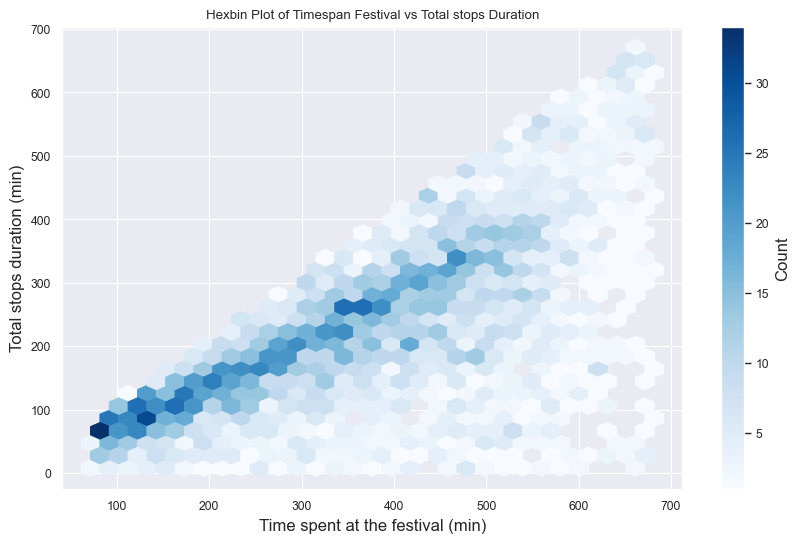

In [87]:
plt.figure(figsize=(10, 6))
plt.hexbin(trajectory_general_measures_night['timespan_festival_mins'],
           trajectory_general_measures_night['total_stops_duration_mins'],
           gridsize=30, cmap='Blues', mincnt=1)
cb = plt.colorbar(label='Count')
plt.title('Hexbin Plot of Timespan Festival vs Total stops Duration')
plt.xlabel('Time spent at the festival (min)')
plt.ylabel('Total stops duration (min)')
plt.grid(True)
plt.show()

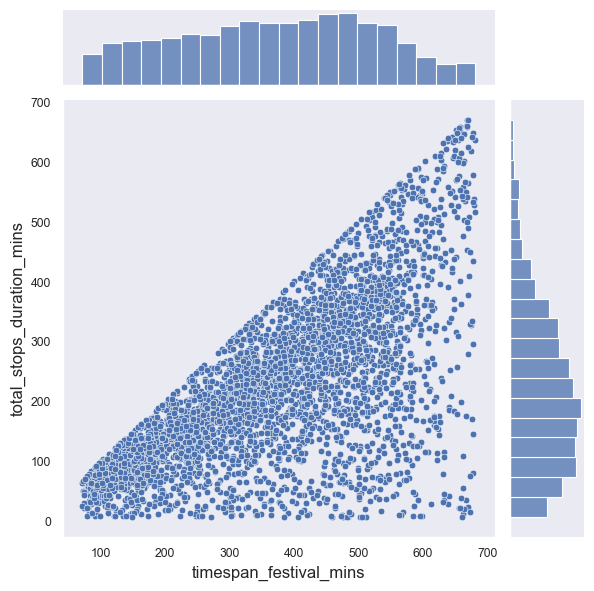

In [88]:
# Create a jointplot with marginal density plots
sns.jointplot(
    data=trajectory_general_measures_night,
    x='timespan_festival_mins',
    y='total_stops_duration_mins',
    kind='scatter', # You can change this to 'hex' for hexbin plot
    marginal_kws=dict(bins=20, fill=True)
)

# Show the plot
plt.show()

A linear regression approach to flag outliers would not work in this case, as these are not really outliers, instead, they might be just cases with incomplete information. Additionally, the regression would not coincide with the main diagonal (the cases where there is more confidence about where the users spent their time) and would be biased towards the lower part of the plot, which are less meaningful instances.

##### Confidence metric

It might be useful to obtain a measure of how "confident" we are about the information from a trajectory. The key idea is to assign a greater weight to the trajectories where the total stops duration is close to the total time spent at the festival (most of the trajectory was captured by the Wi-Fi). A natural candidate for this is $\frac{time_{observed}}{time_{spent}}$. However, to avoid a bias towards giving higher scores for attendees that spent very short times at the vestival (but most of what they did was captured with the Wi-Fi traces), I multiply by a the number of observations, which increases the `confidence_metric` for long trajectories that have many trajectories in comparison to shorter trajectories (that will likely have less observations). THe metric is:

$$
confidence\_metric = time\_observed * \frac{n\_observations}{expected\_observations}
$$

The $expected\_observations$ can be computed as a "typical sample rate" multiplied by the time spent by each user. For that, I can compute the difference between observations of the full (noise-filtered) trajectories.

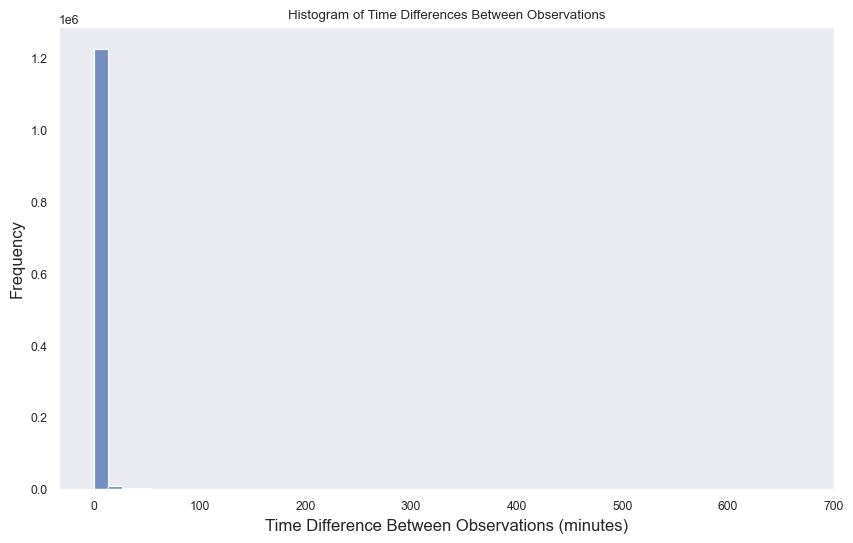

In [89]:
tdf_night_sample_rate_inverse = duckdb_conn.sql("""
                                            SELECT 
                                                *,
                                                (timestamp_ap - LAG(timestamp_ap) OVER (
                                                    PARTITION BY uid, tid
                                                    ORDER BY timestamp_ap
                                                )) / 60.0 AS time_diff_minutes
                                            FROM 
                                                trajectories_events_night
                                            ORDER BY 
                                                uid, tid, timestamp_ap
                                            """)

# Load data into a Pandas DataFrame
tdf_night_sample_rate_inverse_df = duckdb_conn.sql("""
    SELECT time_diff_minutes FROM tdf_night_sample_rate_inverse
    WHERE time_diff_minutes IS NOT NULL
""").to_df()

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(tdf_night_sample_rate_inverse_df['time_diff_minutes'], bins=50, kde=False)

# Labels and title
plt.xlabel("Time Difference Between Observations (minutes)")
plt.ylabel("Frequency")
plt.title("Histogram of Time Differences Between Observations")
#plt.yscale("log")  # Optional: log scale if distribution is highly skewed

plt.show()

In [90]:
print('Distribution of the time difference between observations (in minutes):')
duckdb_conn.sql("""
                    SELECT macaddr_randomized,
                        MIN(time_diff_minutes) AS min_time_diff_minutes,
                        PERCENTILE_CONT(0.05) WITHIN GROUP(ORDER BY time_diff_minutes) AS p05_time_diff_minutes,
                        PERCENTILE_CONT(0.10) WITHIN GROUP(ORDER BY time_diff_minutes) AS p10_time_diff_minutes,
                        PERCENTILE_CONT(0.25) WITHIN GROUP(ORDER BY time_diff_minutes) AS p25_time_diff_minutes,
                        PERCENTILE_CONT(0.50) WITHIN GROUP(ORDER BY time_diff_minutes) AS median_time_diff_minutes,
                        PERCENTILE_CONT(0.75) WITHIN GROUP(ORDER BY time_diff_minutes) AS p75_time_diff_minutes,
                        PERCENTILE_CONT(0.90) WITHIN GROUP(ORDER BY time_diff_minutes) AS p90_time_diff_minutes,
                        PERCENTILE_CONT(0.95) WITHIN GROUP(ORDER BY time_diff_minutes) AS p95_time_diff_minutes,
                        MAX(time_diff_minutes) AS max_time_diff_minutes,
                        AVG(time_diff_minutes) AS mean_time_diff_minutes
                    FROM tdf_night_sample_rate_inverse
                    GROUP BY macaddr_randomized
                    
                    UNION ALL

                    SELECT 'General' AS macaddr_randomized,
                        MIN(time_diff_minutes) AS min_time_diff_minutes,
                        PERCENTILE_CONT(0.05) WITHIN GROUP(ORDER BY time_diff_minutes) AS p05_time_diff_minutes,
                        PERCENTILE_CONT(0.10) WITHIN GROUP(ORDER BY time_diff_minutes) AS p10_time_diff_minutes,
                        PERCENTILE_CONT(0.25) WITHIN GROUP(ORDER BY time_diff_minutes) AS p25_time_diff_minutes,
                        PERCENTILE_CONT(0.50) WITHIN GROUP(ORDER BY time_diff_minutes) AS median_time_diff_minutes,
                        PERCENTILE_CONT(0.75) WITHIN GROUP(ORDER BY time_diff_minutes) AS p75_time_diff_minutes,
                        PERCENTILE_CONT(0.90) WITHIN GROUP(ORDER BY time_diff_minutes) AS p90_time_diff_minutes,
                        PERCENTILE_CONT(0.95) WITHIN GROUP(ORDER BY time_diff_minutes) AS p95_time_diff_minutes,
                        MAX(time_diff_minutes) AS max_time_diff_minutes,
                        AVG(time_diff_minutes) AS mean_time_diff_minutes
                    FROM tdf_night_sample_rate_inverse
                    """)

Distribution of the time difference between observations (in minutes):


┌────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬──────────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬────────────────────────┐
│ macaddr_randomized │ min_time_diff_minutes │ p05_time_diff_minutes │ p10_time_diff_minutes │ p25_time_diff_minutes │ median_time_diff_minutes │ p75_time_diff_minutes │ p90_time_diff_minutes │ p95_time_diff_minutes │ max_time_diff_minutes │ mean_time_diff_minutes │
│      varchar       │        double         │        double         │        double         │        double         │          double          │        double         │        double         │        double         │        double         │         double         │
├────────────────────┼───────────────────────┼───────────────────────┼───────────────────────┼───────────────────────┼──────────────────────────┼───────────────────────┼───────────────────────┼──────

As the distribution is very skewed, the typical sample rate can be the inverse of the median difference between observations from a trajectory.

In [91]:
median_diff_observations_mins = tdf_night_sample_rate_inverse_df.median().values[0]
typical_sample_rate = 1 / median_diff_observations_mins

print(f'The median difference between observations of a trajectory is {median_diff_observations_mins} min')
print(f'The typical_sample_rate is {typical_sample_rate} observations per minute')
del tdf_night_sample_rate_inverse_df

The median difference between observations of a trajectory is 0.18333333333333332 min
The typical_sample_rate is 5.454545454545455 observations per minute


In [92]:
trajectory_general_measures_night['expected_observations'] = trajectory_general_measures_night['timespan_festival_mins'] * typical_sample_rate

trajectory_general_measures_night['confidence_metric'] = trajectory_general_measures_night['total_stops_duration_mins'] * (trajectory_general_measures_night['observations_user_night_original']
                                                                                                                           / trajectory_general_measures_night['expected_observations']) 

trajectory_general_measures_night[['confidence_metric']]

confidence_metric
0             58.963851
1             20.789443
2              9.456364
3             93.604856
4             10.931044
...                 ...
3682         104.530905
3683          55.724205
3684          39.824565
3685         107.656421
3686         107.635823

[3687 rows x 1 columns]

The resulting confidence metric has a very wide range, so to refine the metric further, I apply a sigmoid function that compresses the range and avoid skewing by extreme values. As the sigmoid function saturates for large absolute values, I need to normalize it first. The final metric is:

$$
confidence\_metric\_adj = \sigma \left( confidence\_metric_{normalized} \right)
$$,

where $\sigma(x) = \frac{1}{1 + e^{-x}}$.

In [93]:
# Min-Max normalization
scaler = MinMaxScaler()
trajectory_general_measures_night['confidence_metric_normalized'] = scaler.fit_transform(trajectory_general_measures_night[['confidence_metric']])

# Apply the sigmoid function to the normalized values
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

trajectory_general_measures_night['confidence_metric_adj'] = sigmoid(trajectory_general_measures_night['confidence_metric_normalized'])

trajectory_general_measures_night[['observations_user_night_original',
                                   'timespan_festival_mins','total_stops_duration_mins',
                                   'confidence_metric_adj']].sort_values(by='confidence_metric_adj',ascending=False)

observations_user_night_original  timespan_festival_mins  \
390                               4990              451.533333   
3640                              3573              264.466667   
1110                              3788              509.133333   
3395                              3556              546.983333   
954                               3653              604.233333   
...                                ...                     ...   
2020                                19              301.800000   
1095                                30              477.100000   
1527                                15              342.250000   
2905                                24              506.633333   
730                                 21              584.383333   

      total_stops_duration_mins  confidence_metric_adj  
390                  369.183333               0.731059  
3640                 252.183333               0.697424  
1110                 420.483333               0.682821  
3395                 466.416667               0.677692  
954                  468.100000               0.666770  
...                         ...                    ...  
2020                   8.633333               0.500014  
1095                   8.483333               0.500013  
1527                  11.533333               0.500012  
2905                   8.250000               0.500005  
730                    8.716667               0.500000  

[3687 rows x 4 columns]

In [94]:
# Delete intermediate columns 
del trajectory_general_measures_night['expected_observations']
del trajectory_general_measures_night['confidence_metric'], trajectory_general_measures_night['confidence_metric_normalized']

#### Average score by genre

Given the effectiveness shown by the score proposed in the previous paper at combining multiple aspects into a single metric and finding a way to calculate "preference" for an event, it is reasonable to test how this measure affects clustering.

Similar to what was done for computing the rankings, an average score per user and event type can be computed as a sum of the individual adjusted scores for each event corresponding to each category:
$$
avg\_adj\_score_{u,g} = \sum_{e_g \in {E_g}}{adj\_score_{u,e_g}}
$$

In [95]:
# Compute the average adjusted score for each trajectory and music_type
user_genre_scores_night = (user_event_scores_durations_night
                           .groupby(['uid','tid','genre_grouped'], as_index=False)
                           .agg(avg_adj_score=('adj_score','sum')))

# Pivot the table for obtaining the duration at each stage for each time window (and each trajectory (uid,tid)).  
user_genre_scores_night = user_genre_scores_night.pivot_table(index=['uid', 'tid'],
                                                              columns='genre_grouped',
                                                              values='avg_adj_score',
                                                              aggfunc='max', # There is only one value per trajectory and category. I use max to yield an int
                                                              fill_value=0)

# Reformat the table
user_genre_scores_night_columns = [f'avg_adj_score_{col}' for col in user_genre_scores_night.columns]
user_genre_scores_night.columns = user_genre_scores_night_columns
user_genre_scores_night = user_genre_scores_night.reset_index()

user_genre_scores_night

uid  tid  \
0     00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
1     00172b78731070270dce8dedf92bbdf28e6de7fda23a80...    1   
2     00172b78731070270dce8dedf92bbdf28e6de7fda23a80...    2   
3     00239ab9980168742b141e32cfaa2e4de212b15b84edd8...    2   
4     005c6a47a37ff89bf901c710d8e9fea6e0e4c906e6be07...    2   
...                                                 ...  ...   
3270  ffd9ebc84071104723c5762121c0bde4905de265f7716b...    1   
3271  ffd9ebc84071104723c5762121c0bde4905de265f7716b...    2   
3272  ffdcc358cd7202ecd02a44e6d6d69b358c6d5ee4b59fa7...    1   
3273  ffdcc358cd7202ecd02a44e6d6d69b358c6d5ee4b59fa7...    2   
3274  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   

      avg_adj_score_electronic_accessible  avg_adj_score_electronic_hypnotic  \
0                                0.000000                           0.086298   
1                                0.037402                           0.020554   
2                                0.025903                           0.052380   
3                                0.029709                           0.061411   
4                                0.007936                           0.015408   
...                                   ...                                ...   
3270                             0.017921                           0.024746   
3271                             0.000000                           0.047960   
3272                             0.013574                           0.011570   
3273                             0.000000                           0.063814   
3274                             0.005504                           0.004071   

      avg_adj_score_other_genres  
0                       0.016220  
1                       0.000000  
2                       0.000000  
3                       0.000000  
4                       0.000000  
...                          ...  
3270                    0.021306  
3271                    0.000000  
3272                    0.040293  
3273                    0.000000  
3274                    0.001114  

[3275 rows x 5 columns]

In [96]:
# Joining back to the general df
# I use left join because there are some trajectories that don't have music_type observations, so they would be left unjoined
trajectory_general_measures_night = pd.merge(trajectory_general_measures_night, user_genre_scores_night,
                                             how = 'left', on=['uid','tid'])

# Fill the unmatched durations with 0
trajectory_general_measures_night[user_genre_scores_night_columns] = trajectory_general_measures_night[user_genre_scores_night_columns].fillna(0)

trajectory_general_measures_night.shape

(3687, 30)

#### Event scores as features

If I analyze the events on each day, it may be useful to get the score of each trajectory (user, as there is only a trajectory by day).

The `user_event_scores` table already contains the score each user "assigned" to each event. I just need to pivot the table. 
However, for readability and correctness, I assign a unique id to each event (it is easier to visualize as a column).

In [97]:
events_acc_visits_durations_night.columns

Index(['uid', 'tid', 'macaddr_randomized', 'stage', 'stage_area_m2',
       'event_duration_timetable_mins', 'music_type', 'genre_grouped',
       'views_youtube', 'event_title', 'time_at_event_mins'],
      dtype='object')

In [98]:
sequence_stops_night_filtered.columns

Index(['macaddr_randomized', 'uid', 'tid', 'stage', 'stage_renamed',
       'stage_area_m2', 'event_title', 'start_datetime_event',
       'event_duration_timetable_mins', 'music_type', 'genre_grouped',
       'views_youtube', 'stop_id', 'start_time_stop', 'end_time_stop',
       'duration_stop_mins', 'x_centroid_proj', 'y_centroid_proj',
       'lng_centroid', 'lat_centroid', 'mins_bar_restaurant_stop',
       'mins_other_stop', 'mins_stage_stop'],
      dtype='object')

In [99]:
id_events_lookup = (sequence_stops_night_filtered[['tid','start_datetime_event','stage_renamed','event_title']]
                     .loc[sequence_stops_night_filtered['event_title']!='No event']
                     .drop_duplicates()
                     .sort_values(by=['start_datetime_event','stage_renamed'])
                     .reset_index(drop=True))

id_events_lookup['event_id'] = 'ev_' + (id_events_lookup.index+1).astype(str)

id_events_lookup

tid      start_datetime_event          stage_renamed  \
0     1 2024-06-14 20:50:00+02:00              SonarClub   
1     1 2024-06-14 21:30:00+02:00  SonarLab x Printworks   
2     1 2024-06-14 22:00:00+02:00              SonarClub   
3     1 2024-06-14 22:00:00+02:00               SonarPub   
4     1 2024-06-14 22:40:00+02:00  SonarLab x Printworks   
5     1 2024-06-14 23:20:00+02:00              SonarClub   
6     1 2024-06-14 23:30:00+02:00               SonarPub   
7     1 2024-06-14 23:45:00+02:00  SonarLab x Printworks   
8     1 2024-06-15 00:00:00+02:00               SonarCar   
9     1 2024-06-15 00:35:00+02:00               SonarPub   
10    1 2024-06-15 01:00:00+02:00               SonarCar   
11    1 2024-06-15 01:05:00+02:00              SonarClub   
12    1 2024-06-15 01:50:00+02:00  SonarLab x Printworks   
13    1 2024-06-15 01:55:00+02:00               SonarCar   
14    1 2024-06-15 02:25:00+02:00               SonarPub   
15    1 2024-06-15 02:30:00+02:00              SonarClub   
16    1 2024-06-15 03:15:00+02:00               SonarCar   
17    1 2024-06-15 03:25:00+02:00  SonarLab x Printworks   
18    1 2024-06-15 03:30:00+02:00               SonarPub   
19    1 2024-06-15 04:10:00+02:00              SonarClub   
20    1 2024-06-15 04:40:00+02:00               SonarCar   
21    1 2024-06-15 05:30:00+02:00              SonarClub   
22    1 2024-06-15 05:30:00+02:00               SonarPub   
23    1 2024-06-15 05:30:00+02:00  SonarLab x Printworks   
24    2 2024-06-15 20:50:00+02:00              SonarClub   
25    2 2024-06-15 21:30:00+02:00  SonarLab x Printworks   
26    2 2024-06-15 22:00:00+02:00              SonarClub   
27    2 2024-06-15 22:00:00+02:00               SonarPub   
28    2 2024-06-15 22:40:00+02:00  SonarLab x Printworks   
29    2 2024-06-15 23:30:00+02:00               SonarPub   
30    2 2024-06-15 23:35:00+02:00              SonarClub   
31    2 2024-06-15 23:50:00+02:00  SonarLab x Printworks   
32    2 2024-06-16 00:00:00+02:00               SonarCar   
33    2 2024-06-16 00:35:00+02:00               SonarPub   
34    2 2024-06-16 00:55:00+02:00  SonarLab x Printworks   
35    2 2024-06-16 01:05:00+02:00               SonarCar   
36    2 2024-06-16 01:15:00+02:00              SonarClub   
37    2 2024-06-16 02:00:00+02:00  SonarLab x Printworks   
38    2 2024-06-16 02:05:00+02:00               SonarCar   
39    2 2024-06-16 02:30:00+02:00               SonarPub   
40    2 2024-06-16 02:35:00+02:00              SonarClub   
41    2 2024-06-16 03:05:00+02:00               SonarCar   
42    2 2024-06-16 03:55:00+02:00               SonarPub   
43    2 2024-06-16 04:00:00+02:00               SonarCar   
44    2 2024-06-16 04:05:00+02:00              SonarClub   
45    2 2024-06-16 04:05:00+02:00  SonarLab x Printworks   
46    2 2024-06-16 05:00:00+02:00               SonarCar   
47    2 2024-06-16 05:10:00+02:00  SonarLab x Printworks   
48    2 2024-06-16 05:30:00+02:00              SonarClub   
49    2 2024-06-16 05:30:00+02:00               SonarPub   

                                          event_title event_id  
0                                        Arnau Obiols     ev_1  
1                                                TNTC     ev_2  
2                              Air play ‘Moon Safari’     ev_3  
3                                              Spacer     ev_4  
4                                           CASISDEAD     ev_5  
5                           Jennifer Cardini b2b HAAi     ev_6  
6                                         Jessie Ware     ev_7  
7                Eliza Rose b2b Dan Shake b2b Sally C     ev_8  
8                                            Verushka     ev_9  
9               Toy Tonics Jam: Kapote & Sam Ruffillo    ev_10  
10                                    La Goony Chonga    ev_11  
11                                    Ben Böhmer live    ev_12  
12                                             salute    ev_13  
13                               

Now I join the new id to the scores table and pivot it.

In [100]:
# Merge the event_id
user_event_scores_durations_night = pd.merge(user_event_scores_durations_night, id_events_lookup[['event_title','event_id']],
                                             how='left', on='event_title')
user_event_scores_durations_night.shape

(13806, 18)

In [101]:
# Pivot the table
user_event_scores_pivot_night = (user_event_scores_durations_night
                                 .pivot_table(index=['uid', 'tid'],
                                              columns='event_id',
                                              values='adj_score',
                                              aggfunc='sum',
                                              fill_value=0))

# Extract the numeric part of the event_id and sort it
sorted_event_ids = sorted(id_events_lookup['event_id'], key=lambda x: int(x.split('_')[1]))

# Reindex the columns of the pivot table to match the sorted order of event_id
user_event_scores_pivot_night = user_event_scores_pivot_night.reindex(columns=sorted_event_ids)

# Rename the columns and reset the index
user_event_scores_pivot_night_columns = ['adj_score_'+col for col in user_event_scores_pivot_night.columns]
user_event_scores_pivot_night.columns = user_event_scores_pivot_night_columns

user_event_scores_pivot_night = user_event_scores_pivot_night.reset_index()

user_event_scores_pivot_night

uid  tid  adj_score_ev_1  \
0     00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2             0.0   
1     00172b78731070270dce8dedf92bbdf28e6de7fda23a80...    1             0.0   
2     00172b78731070270dce8dedf92bbdf28e6de7fda23a80...    2             0.0   
3     00239ab9980168742b141e32cfaa2e4de212b15b84edd8...    2             0.0   
4     005c6a47a37ff89bf901c710d8e9fea6e0e4c906e6be07...    2             0.0   
...                                                 ...  ...             ...   
3270  ffd9ebc84071104723c5762121c0bde4905de265f7716b...    1             0.0   
3271  ffd9ebc84071104723c5762121c0bde4905de265f7716b...    2             0.0   
3272  ffdcc358cd7202ecd02a44e6d6d69b358c6d5ee4b59fa7...    1             0.0   
3273  ffdcc358cd7202ecd02a44e6d6d69b358c6d5ee4b59fa7...    2             0.0   
3274  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1             0.0   

      adj_score_ev_2  adj_score_ev_3  adj_score_ev_4  adj_score_ev_5  \
0                0.0             0.0             0.0        0.000000   
1                0.0             0.0             0.0        0.000000   
2                0.0             0.0             0.0        0.000000   
3                0.0             0.0             0.0        0.000000   
4                0.0             0.0             0.0        0.000000   
...              ...             ...             ...             ...   
3270             0.0             0.0             0.0        0.000000   
3271             0.0             0.0             0.0        0.000000   
3272             0.0             0.0             0.0        0.000000   
3273             0.0             0.0             0.0        0.000000   
3274             0.0             0.0             0.0        0.001114   

      adj_score_ev_6  adj_score_ev_7  adj_score_ev_8  ...  adj_score_ev_41  \
0                0.0        0.000000        0.000000  ...         0.000000   
1                0.0        0.000000        0.014475  ...         0.000000   
2                0.0        0.000000        0.000000  ...         0.025903   
3                0.0        0.000000        0.000000  ...         0.000000   
4                0.0        0.000000        0.000000  ...         0.007936   
...              ...             ...             ...  ...              ...   
3270             0.0        0.021306        0.000000  ...         0.000000   
3271             0.0        0.000000        0.000000  ...         0.000000   
3272             0.0        0.000000        0.000000  ...         0.000000   
3273             0.0        0.000000        0.000000  ...         0.000000   
3274             0.0        0.000000        0.003240  ...         0.000000   

      adj_score_ev_42  adj_score_ev_43  adj_score_ev_44  adj_score_ev_45  \
0             0.01622         0.000000         0.000000          0.00000   
1             0.00000         0.000000         0.000000          0.00000   
2             0.00000         0.000000         0.000000          0.00000   
3             0.00000         0.029709         0.000000          0.01745   
4             0.00000         0.000000         0.000000          0.00000   
...               ...              ...              ...              ...   
3270          0.00000         0.000000         0.000000          0.00000   
3271          0.00000         0.000000         0.000000          0.00000   
3272          0.00000         0.000000         0.000000          0.00000   
3273          0.00000         0.000000         0.015012          0.00000   
3274          0.00000         0.000000         0.000000          0.00000   

      adj_score_ev_46  adj_score_ev_47  adj_score_ev_48  adj_score_ev_49  \
0            0.000000         0.000000         0.000000         0.000000   
1            0.000000         0.000000         0.000000         0.000000   
2            0.008761         0.000000         0.014491         0.000000   
3            0.000000         0.000000         0.000000         0.000000

In [102]:
# Joining back to the general df
# I use left join because there are some trajectories that only have 
# "No event" as event_tile (see next section), so they would be left unjoined
trajectory_general_measures_night = pd.merge(trajectory_general_measures_night, user_event_scores_pivot_night,
                                             how = 'left', on=['uid','tid'])

# Fill the unmatched durations with 0
trajectory_general_measures_night[user_event_scores_pivot_night_columns] = trajectory_general_measures_night[user_event_scores_pivot_night_columns].fillna(0)

trajectory_general_measures_night.shape

(3687, 80)

#### Trajectories with no events

From the previous section, I noticed that there are several trajectories where there was no event (at least after filtering the short stops). I can check that a little more in detail.

In [103]:
sequence_stops_night_filtered.dtypes

macaddr_randomized                                       int64
uid                                                     object
tid                                                      int64
stage                                                   object
stage_renamed                                         category
stage_area_m2                                            int64
event_title                                             object
start_datetime_event             datetime64[us, Europe/Madrid]
event_duration_timetable_mins                          float64
music_type                                              object
genre_grouped                                           object
views_youtube                                          float64
stop_id                                                  int32
start_time_stop                  datetime64[us, Europe/Madrid]
end_time_stop                    datetime64[us, Europe/Madrid]
duration_stop_mins                                     

In [104]:
def check_trajectories_no_events():
    # Group by 'uid' and 'tid' and check if all 'event_title' values are "No event"
    uid_tid_no_event = (sequence_stops_night_filtered.groupby(['uid', 'tid'])['event_title']
                        .apply(lambda x: (x == "No event").all())
                        .reset_index())

    # Filter the groups where all 'event_title' values are "No event"
    uid_tid_no_event = uid_tid_no_event[uid_tid_no_event['event_title']]

    # Select only 'uid' and 'tid' columns
    uid_tid_no_event = uid_tid_no_event[['uid', 'tid']]

    trajectories_no_events = pd.merge(trajectories_events_night_filtered,
                                      uid_tid_no_event,
                                      how='inner',
                                      on=['uid','tid'])
    
    return trajectories_no_events

# Checking the histogram from the data wrangler, it seems that many of these spent a lot of time at the festival
trajectories_no_events = check_trajectories_no_events()
trajectories_no_events

uid  macaddr_randomized  \
0      00a7444a40c1bd8b3b2a145fd44cdcce0d37c07bc9a3e8...                   1   
1      00a7444a40c1bd8b3b2a145fd44cdcce0d37c07bc9a3e8...                   1   
2      00a7444a40c1bd8b3b2a145fd44cdcce0d37c07bc9a3e8...                   1   
3      00a7444a40c1bd8b3b2a145fd44cdcce0d37c07bc9a3e8...                   1   
4      00a7444a40c1bd8b3b2a145fd44cdcce0d37c07bc9a3e8...                   1   
...                                                  ...                 ...   
40734  ff8f67c639fe4f7690be4880d22a429814b6c543dcf87b...                   1   
40735  ff8f67c639fe4f7690be4880d22a429814b6c543dcf87b...                   1   
40736  ff8f67c639fe4f7690be4880d22a429814b6c543dcf87b...                   1   
40737  ff8f67c639fe4f7690be4880d22a429814b6c543dcf87b...                   1   
40738  ff8f67c639fe4f7690be4880d22a429814b6c543dcf87b...                   1   

       tid  observations_user_night_original  timespan_minutes_night_original  \
0        1                                20                           617.87   
1        1                                20                           617.87   
2        1                                20                           617.87   
3        1                                20                           617.87   
4        1                                20                           617.87   
...    ...                               ...                              ...   
40734    1                                 9                           242.72   
40735    1                                 9                           242.72   
40736    1                                 9                           242.72   
40737    1                                 9                           242.72   
40738    1                                 9                           242.72   

                       datetime  timestamp_ap          time_window_5min  \
0     2024-06-14 20:57:35+02:00    1718391455 2024-06-14 20:55:00+02:00   
1     2024-06-14 20:58:36+02:00    1718391516 2024-06-14 20:55:00+02:00   
2     2024-06-14 21:00:26+02:00    1718391626 2024-06-14 21:00:00+02:00   
3     2024-06-15 02:51:23+02:00    1718412683 2024-06-15 02:50:00+02:00   
4     2024-06-15 02:53:13+02:00    1718412793 2024-06-15 02:50:00+02:00   
...                         ...           ...                       ...   
40734 2024-06-14 20:05:50+02:00    1718388350 2024-06-14 20:05:00+02:00   
40735 2024-06-14 20:07:39+02:00    1718388459 2024-06-14 20:05:00+02:00   
40736 2024-06-14 20:07:41+02:00    1718388461 2024-06-14 20:05:00+02:00   
40737 2024-06-14 23:59:27+02:00    1718402367 2024-06-14 23:55:00+02:00   
40738 2024-06-15 00:01:20+02:00    1718402480 2024-06-15 00:00:00+02:00   

              time_window_15min        lat  ...  cell_density  \
0     2024-06-14 20:45:00+02:00  41.354117  ...             4   
1     2024-06-14 20:45:00+02:00  41.354117  ...             4   
2     2024-06-14 21:00:00+02:00  41.354117  ...             4   
3     2024-06-15 02:45:00+02:00  41.354012  ...             2   
4     2024-06-15 02:45:00+02:00  41.354012  ...             2   
...                         ...        ...  ...           ...   
40734 2024-06-14 20:00:00+02:00  41.354297  ...             1   
40735 2024-06-14 20:00:00+02:00  41.354297  ...             1   
40736 2024-06-14 20:00:00+02:00  41.354297  ...             1   
40737 2024-06-14 23:45:00+02:00  41.354590  ...             3   
40738 2024-06-15 00:00:00+02:00  41.354590  ...             1   

      transition_flag_event stop_id           start_time_stop  \
0                         0       0 2024-06-14 20:57:35+02:00   
1                         0       0 2024-06-14 20:57:35+02:00   
2                         0       0 2024-06-14 20:57:35+02:00   
3                         0       0 2024-06-14 20:57:35+02:00   
4                         0       0 2024-06-14 20:57:35+02:00   
...                     ...     ...            

In [105]:
# Most of the observations occur at areas not correspoding to the stages
trajectories_no_events.groupby(['stage','polygon_name']).size().sort_values(ascending=False)

stage                   polygon_name                        
NA-Restauración         SONAR NIT - Restauración                19927
NA-autos_choques_barra  SONAR NIT - Autos de choques Barra       8668
NA-Entrada              SONAR NIT - Entrada                      4989
SonarClub               SONAR NIT - SonarClub                    2314
SonarPub                SONAR NIT - SonarPub                      946
NA-autos_choques        SONAR NIT - Autos de choques              913
SonarLab x Printworks   SONAR NIT - SonarLab                      620
SonarCar                SONAR NIT - SonarCar                      457
SonarPub                SONAR NIT - Bar Pub                       449
SonarClub               SONAR NIT - SonarClub Barra               415
SonarLab x Printworks   SONAR NIT - SonarLab Barra 1              288
                        SONAR NIT - SonarLab Barra 2              274
SonarClub               SONAR NIT - SonarClub Barra la Nueva      159
                        SONAR

I can keep track of these trajectories and see how they affect the results. It seems that these are devices from the people working at the bar/restaurant/entrance areas.

#### User mobility metrics

I will compute two measures related to the mobility behaviors, which will be computed with scikit-mobility. I checked the library code and, in these cases, unlike what was done in the trajectory preproceessing, the functions are not made to work with `tid` automatically, so I need a tdf for each user (`uid`) and night of the festival (`tid`).

I use the full (noise-filtered) trajectories to make the computations. This trajectory better captures the whole mobility of attendands during the festival, while the `sequence_stops_night_filtered` captuers the "behavioral" part of the trajectory in a more summarized way, but loses movement granularity.

In [106]:
tdf_night1 = skmob.TrajDataFrame(
    trajectories_events_night.loc[trajectories_events_night['tid']==1], 
    longitude='lng', latitude='lat',
    datetime='datetime', 
    user_id='uid').sort_values(by=['uid', 'datetime'])

tdf_night2 = skmob.TrajDataFrame(
    trajectories_events_night.loc[trajectories_events_night['tid']==2], 
    longitude='lng', latitude='lat',
    datetime='datetime', 
    user_id='uid').sort_values(by=['uid', 'datetime'])

##### Distance straight line

Using the skmob function to compute the distance as a straight line in km for each trajectory.

In [107]:
dsl_night1 = distance_straight_line(tdf_night1)

dsl_night2 = distance_straight_line(tdf_night2)

100%|██████████| 1977/1977 [00:23<00:00, 83.47it/s] 


In [108]:
# Adding the tid to identify which day the computation corresponds to
dsl_night1['tid'] = 1
dsl_night2['tid'] = 2

# Concatenating the two distance df into one
dsl_night = pd.concat([dsl_night1, dsl_night2])
dsl_night

uid  \
0     00172b78731070270dce8dedf92bbdf28e6de7fda23a80...   
1     0060d3d08715dd2a8a81c7f1ba55f09a5e8fc9d3c6c6f8...   
2     00640f3fda25972330d6b1bf097a1d9f48c5a6af256108...   
3     0093cef17a50cf3656796d913f454d47c118e27cd77a0d...   
4     0097eac9e7f67d68b2d7538abc51a76a465f9daba1fb6a...   
...                                                 ...   
1972  ff7c1e7190aae9173691033e653aaf7b7ee15fe44fb019...   
1973  ff8f67c639fe4f7690be4880d22a429814b6c543dcf87b...   
1974  ffb3d39d9f5bc6f26e5ac0b0498bc9238f9611cfaf4461...   
1975  ffd9ebc84071104723c5762121c0bde4905de265f7716b...   
1976  ffdcc358cd7202ecd02a44e6d6d69b358c6d5ee4b59fa7...   

      distance_straight_line  tid  
0                   2.832308    1  
1                   2.085552    1  
2                   0.821649    1  
3                   3.814192    1  
4                   9.431455    1  
...                      ...  ...  
1972                3.186727    2  
1973                0.580961    2  
1974                5.509786    2  
1975                2.885795    2  
1976                6.038614    2  

[3846 rows x 3 columns]

##### Radius of gyration

Using the skmob function to compute the radius of giration in km for each trajectory.

In [109]:
rg_night1 = radius_of_gyration(tdf_night1)

rg_night2 = radius_of_gyration(tdf_night2)

100%|██████████| 1977/1977 [00:17<00:00, 113.27it/s]


In [110]:
# Adding the tid to identify which day the computation corresponds to
rg_night1['tid'] = 1
rg_night2['tid'] = 2

# Concatenating the two distance df into one
rg_night = pd.concat([rg_night1, rg_night2])
rg_night

uid  radius_of_gyration  \
0     00172b78731070270dce8dedf92bbdf28e6de7fda23a80...            0.125931   
1     0060d3d08715dd2a8a81c7f1ba55f09a5e8fc9d3c6c6f8...            0.101496   
2     00640f3fda25972330d6b1bf097a1d9f48c5a6af256108...            0.051599   
3     0093cef17a50cf3656796d913f454d47c118e27cd77a0d...            0.102432   
4     0097eac9e7f67d68b2d7538abc51a76a465f9daba1fb6a...            0.072942   
...                                                 ...                 ...   
1972  ff7c1e7190aae9173691033e653aaf7b7ee15fe44fb019...            0.086636   
1973  ff8f67c639fe4f7690be4880d22a429814b6c543dcf87b...            0.077468   
1974  ffb3d39d9f5bc6f26e5ac0b0498bc9238f9611cfaf4461...            0.097537   
1975  ffd9ebc84071104723c5762121c0bde4905de265f7716b...            0.094850   
1976  ffdcc358cd7202ecd02a44e6d6d69b358c6d5ee4b59fa7...            0.111161   

      tid  
0       1  
1       1  
2       1  
3       1  
4       1  
...   ...  
1972    2  
1973    2  
1974    2  
1975    2  
1976    2  

[3846 rows x 3 columns]

##### Joining the per trajectory measures

In [111]:
mobility_features = pd.merge(dsl_night, rg_night,
                             how = 'inner', on=['uid','tid'])



trajectory_general_measures_night = pd.merge(trajectory_general_measures_night, mobility_features,
                                       how = 'left', on=['uid','tid'])

print(f'Shape: {trajectory_general_measures_night.shape}')
print(f'Renamed columns: \n{trajectory_general_measures_night.columns}')

Shape: (3687, 82)
Renamed columns: 
Index(['uid', 'tid', 'observations_user_night_original',
       'timespan_festival_mins', 'average_cell_density',
       'arrival_festival_epoch', 'departure_festival_epoch',
       'arrival_festival_mins', 'departure_festival_mins',
       'num_attended_events', 'total_stops_duration_mins',
       'duration_electronic_accessible_share',
       'duration_electronic_hypnotic_share', 'duration_other_genres_share',
       'duration_no_event_share', 'duration_bar_restaurant_share',
       'duration_stage_share', 'duration_other_share',
       'duration_SonarClub_share', 'duration_SonarPub_share',
       'duration_SonarLab x Printworks_share', 'duration_SonarCar_share',
       'duration_Restaurants_share', 'duration_Bumper cars_share',
       'duration_Bar: Restaurants-Bumper cars_share',
       'duration_Entrance/Cashless_share', 'confidence_metric_adj',
       'avg_adj_score_electronic_accessible',
       'avg_adj_score_electronic_hypnotic', 'avg_adj_sc

### Time-window features (broad bands)

More than half of the users spent just one day of the festival, so I have to devise a methodology for clustering the users' trajectories by making them comparable to one another. 

In [112]:
print('Number of users by number of attended days:')
(trajectories_events_night.groupby('uid', as_index=False).agg(num_days_attended=('tid','nunique'))
 .groupby('num_days_attended', as_index=False).agg(num_users=('uid','size')))

Number of users by number of attended days:


num_days_attended  num_users
0                  1       1744
1                  2       1051

I can obtain a fixed array of features with time windows that span over the whole duration of the festival and aggregate key aspects of the individuals' trajectories within that time window.

First, I generate the arrays of time windows. I generate them by looking at the plot of people counts and checking the points were there are abrupt jumps. The breaks in the two plots tend to coincide with small differences (usually 15 minute gaps). This way, the time windows represent different "phases" of each night of the festival.

In [113]:
# Generate the intervals for each night/day
def generate_time_windows_night():

    # Organize the bounding timestamps   
    dict_bounding_dates = {
                        1: [pd.Timestamp(constants.START_NIGHT_1_STRING, tz='Europe/Madrid'),
                             pd.Timestamp('2024-06-14 22:00:00', tz='Europe/Madrid'),
                             pd.Timestamp('2024-06-14 23:15:00', tz='Europe/Madrid'),
                             pd.Timestamp('2024-06-15 00:30:00', tz='Europe/Madrid'),
                             pd.Timestamp('2024-06-15 02:15:00', tz='Europe/Madrid'),
                             pd.Timestamp('2024-06-15 04:00:00', tz='Europe/Madrid'),
                             pd.Timestamp('2024-06-15 05:15:00', tz='Europe/Madrid'),
                             pd.Timestamp(constants.END_NIGHT_1_STRING, tz='Europe/Madrid')],
                        2: [pd.Timestamp(constants.START_NIGHT_2_STRING, tz='Europe/Madrid'),
                            pd.Timestamp('2024-06-15 22:00:00', tz='Europe/Madrid'),
                            pd.Timestamp('2024-06-15 23:30:00', tz='Europe/Madrid'),
                            pd.Timestamp('2024-06-16 00:30:00', tz='Europe/Madrid'),
                            pd.Timestamp('2024-06-16 02:30:00', tz='Europe/Madrid'),
                            pd.Timestamp('2024-06-16 04:00:00', tz='Europe/Madrid'),
                            pd.Timestamp('2024-06-16 05:30:00', tz='Europe/Madrid'),
                            pd.Timestamp(constants.END_NIGHT_2_STRING, tz='Europe/Madrid')]
                        }
    
    # Create the time windows and append them for organizing them afterwards
    time_windows_list = []
    tid_list = []

    for night, bounding_dates in dict_bounding_dates.items():     
        night_windows = pd.date_range(bounding_dates[0], bounding_dates[1], freq='15min')

        # Create the time windows for the current night
        start_times = pd.Series(bounding_dates[:-1])
        end_times = pd.Series(bounding_dates[1:])
        
        # Append to the lists
        time_windows_list.append(pd.DataFrame({'start_time_tw': start_times, 
                                               'end_time_tw': end_times}))
        tid_list.append(pd.Series(night, index=start_times.index))
    
    # Combine the time windows into a single DataFrame
    time_windows_df = pd.concat([pd.concat(time_windows_list).reset_index(drop=True),
                                 pd.concat(tid_list).reset_index(drop=True).rename('tid')],
                                 axis=1)

    return time_windows_df

In [114]:
night_time_windows = generate_time_windows_night()
night_time_windows

start_time_tw               end_time_tw  tid
0  2024-06-14 19:50:00+02:00 2024-06-14 22:00:00+02:00    1
1  2024-06-14 22:00:00+02:00 2024-06-14 23:15:00+02:00    1
2  2024-06-14 23:15:00+02:00 2024-06-15 00:30:00+02:00    1
3  2024-06-15 00:30:00+02:00 2024-06-15 02:15:00+02:00    1
4  2024-06-15 02:15:00+02:00 2024-06-15 04:00:00+02:00    1
5  2024-06-15 04:00:00+02:00 2024-06-15 05:15:00+02:00    1
6  2024-06-15 05:15:00+02:00 2024-06-15 08:00:00+02:00    1
7  2024-06-15 19:50:00+02:00 2024-06-15 22:00:00+02:00    2
8  2024-06-15 22:00:00+02:00 2024-06-15 23:30:00+02:00    2
9  2024-06-15 23:30:00+02:00 2024-06-16 00:30:00+02:00    2
10 2024-06-16 00:30:00+02:00 2024-06-16 02:30:00+02:00    2
11 2024-06-16 02:30:00+02:00 2024-06-16 04:00:00+02:00    2
12 2024-06-16 04:00:00+02:00 2024-06-16 05:30:00+02:00    2
13 2024-06-16 05:30:00+02:00 2024-06-16 08:00:00+02:00    2

##### Duration at stages and location type per time window

In this case I work with the sequence of stops instead of the time spent at each event because the latter might not consider cases when there are contiguous observations within the same stage, and a whole event passed between the two observations. 

In that case, the time at the intermediate event would be 0, but as it is assumed that attendees did not move between contiguous observations within the same stage, the time at the stage should not be 0.

There are few cases when this happens, and I make this decision for consistency regarding the assumption and the difference is less than 2%.

In [115]:
def compute_stage_location_type_duration_tw(sequence_stops_df, time_windows_df):
    # Explode the sequence_stops_df table into rows for each time window
    # by merging it with time_windows based on the corresponding day/night (tid)
    # It results in one row per stop and time_window 
    # (I leave the non-overlapping stops in the table for mantaining all the time windows, leaving fixed size arrays)
    exploded_stops = pd.merge(sequence_stops_df, time_windows_df,
                               on='tid', how='inner')

    # Compute durations of the overlap between the stop time span and the time window
    exploded_stops['overlap_stop_tw_start'] = exploded_stops[['start_time_stop', 'start_time_tw']].max(axis=1)
    exploded_stops['overlap_stop_tw_end'] = exploded_stops[['end_time_stop', 'end_time_tw']].min(axis=1)
    exploded_stops['duration_stop_tw_mins'] = (((exploded_stops['overlap_stop_tw_end'] - exploded_stops['overlap_stop_tw_start']).
                                                dt.total_seconds() / 60) # Convert to minutes
                                                .clip(lower=0)) # Trim negative durations to be equal to 0

    # Group by uid, tid, and time window to compute the total overlap duration
    trajectories_time_window_stops = (exploded_stops.groupby(['uid', 'tid',
                                                              'start_time_tw', 'end_time_tw',
                                                              'stage','event_title','start_time_stop','end_time_stop'], as_index=False)
                                                              ['duration_stop_tw_mins'].sum())
    
    return trajectories_time_window_stops

In [116]:
sequence_stops_night_filtered.dtypes

macaddr_randomized                                       int64
uid                                                     object
tid                                                      int64
stage                                                   object
stage_renamed                                         category
stage_area_m2                                            int64
event_title                                             object
start_datetime_event             datetime64[us, Europe/Madrid]
event_duration_timetable_mins                          float64
music_type                                              object
genre_grouped                                           object
views_youtube                                          float64
stop_id                                                  int32
start_time_stop                  datetime64[us, Europe/Madrid]
end_time_stop                    datetime64[us, Europe/Madrid]
duration_stop_mins                                     

In [117]:
# Function execution
trajectories_time_window_night_stops = compute_stage_location_type_duration_tw(sequence_stops_df=sequence_stops_night_filtered, time_windows_df=night_time_windows)

In [118]:
trajectories_time_window_night_stops

uid  tid  \
0       00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
1       00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
2       00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
3       00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
4       00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
...                                                   ...  ...   
146904  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
146905  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
146906  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
146907  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
146908  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   

                   start_time_tw               end_time_tw  \
0      2024-06-15 19:50:00+02:00 2024-06-15 22:00:00+02:00   
1      2024-06-15 19:50:00+02:00 2024-06-15 22:00:00+02:00   
2      2024-06-15 19:50:00+02:00 2024-06-15 22:00:00+02:00   
3      2024-06-15 19:50:00+02:00 2024-06-15 22:00:00+02:00   
4      2024-06-15 19:50:00+02:00 2024-06-15 22:00:00+02:00   
...                          ...                       ...   
146904 2024-06-15 05:15:00+02:00 2024-06-15 08:00:00+02:00   
146905 2024-06-15 05:15:00+02:00 2024-06-15 08:00:00+02:00   
146906 2024-06-15 05:15:00+02:00 2024-06-15 08:00:00+02:00   
146907 2024-06-15 05:15:00+02:00 2024-06-15 08:00:00+02:00   
146908 2024-06-15 05:15:00+02:00 2024-06-15 08:00:00+02:00   

                        stage                              event_title  \
0                  NA-Entrada                                 No event   
1                    SonarCar                             LaFrancesssa   
2                    SonarCar                                 Soto Asa   
3                   SonarClub                                   Anetha   
4                   SonarClub  Charlotte de Witte presents 'Overdrive'   
...                       ...                                      ...   
146904  SonarLab x Printworks                 DJ Flight & MC Chickaboo   
146905  SonarLab x Printworks                 DJ Flight & MC Chickaboo   
146906  SonarLab x Printworks     Eliza Rose b2b Dan Shake b2b Sally C   
146907  SonarLab x Printworks                                   salute   
146908  SonarLab x Printworks                                   salute   

                 start_time_stop             end_time_stop  \
0      2024-06-15 22:38:47+02:00 2024-06-15 23:08:23+02:00   
1      2024-06-16 00:10:54+02:00 2024-06-16 00:34:23+02:00   
2      2024-06-16 03:33:36+02:00 2024-06-16 03:55:00+02:00   
3      2024-06-15 23:35:00+02:00 2024-06-15 23:44:17+02:00   
4      2024-06-16 01:27:28+02:00 2024-06-16 01:40:01+02:00   
...                          ...                       ...   
146904 2024-06-15 05:30:00+02:00 2024-06-15 05:38:23+02:00   
146905 2024-06-15 05:43:35+02:00 2024-06-15 06:31:04+02:00   
146906 2024-06-14 23:45:00+02:00 2024-06-15 01:45:00+02:00   
146907 2024-06-15 01:50:00+02:00 2024-06-15 02:53:12+02:00   
146908 2024-06-15 02:58:07+02:00 2024-06-15 03:20:00+02:00   

        duration_stop_tw_mins  
0                    0.000000  
1                    0.000000  
2                    0.000000  
3                    0.000000  
4                    0.000000  
...                       ...  
146904               8.383333  
146905              47.483333  
146906               0.000000  
146907               0.000000  
146908               0.000000  

[146909 rows x 9 columns]

From the time spent at location type within the time windows, I can reformat the the table to obtain accumulated durations as features for each trajectory (uid,tid) and time window of analysis.

- Duration at stages per time window

In [119]:
# Pivot the table for obtaining the duration at each stage for each time window (and each trajectory (uid,tid)).  
tw_durations_stage_night = trajectories_time_window_night_stops.pivot_table(index=['uid', 'tid','start_time_tw', 'end_time_tw'],
                                                                            columns='stage',
                                                                            values='duration_stop_tw_mins',
                                                                            aggfunc='sum',
                                                                            fill_value=0)

# Reformat the table
tw_durations_stage_night.columns = [f'mins_{col}' for col in tw_durations_stage_night.columns]
tw_durations_stage_night = tw_durations_stage_night.reset_index()
tw_durations_stage_night

uid  tid  \
0      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
1      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
2      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
3      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
4      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
...                                                  ...  ...   
25804  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
25805  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
25806  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
25807  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
25808  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   

                  start_time_tw               end_time_tw  mins_NA-Cashless1  \
0     2024-06-15 19:50:00+02:00 2024-06-15 22:00:00+02:00                0.0   
1     2024-06-15 22:00:00+02:00 2024-06-15 23:30:00+02:00                0.0   
2     2024-06-15 23:30:00+02:00 2024-06-16 00:30:00+02:00                0.0   
3     2024-06-16 00:30:00+02:00 2024-06-16 02:30:00+02:00                0.0   
4     2024-06-16 02:30:00+02:00 2024-06-16 04:00:00+02:00                0.0   
...                         ...                       ...                ...   
25804 2024-06-14 23:15:00+02:00 2024-06-15 00:30:00+02:00                0.0   
25805 2024-06-15 00:30:00+02:00 2024-06-15 02:15:00+02:00                0.0   
25806 2024-06-15 02:15:00+02:00 2024-06-15 04:00:00+02:00                0.0   
25807 2024-06-15 04:00:00+02:00 2024-06-15 05:15:00+02:00                0.0   
25808 2024-06-15 05:15:00+02:00 2024-06-15 08:00:00+02:00                0.0   

       mins_NA-Entrada  mins_NA-Restauración  mins_NA-autos_choques  \
0                  0.0                   0.0                    0.0   
1                 29.6                   0.0                    0.0   
2                  0.0                   0.0                    0.0   
3                  0.0                   0.0                    0.0   
4                  0.0                   0.0                    0.0   
...                ...                   ...                    ...   
25804              0.0                   0.0                    0.0   
25805              0.0                   0.0                    0.0   
25806              0.0                   0.0                    0.0   
25807              0.0                   0.0                    0.0   
25808              0.0                   0.0                    0.0   

       mins_NA-autos_choques_barra  mins_SonarCar  mins_SonarClub  \
0                              0.0       0.000000        0.000000   
1                              0.0       0.000000       19.366667   
2                              0.0      19.100000        9.283333   
3                              0.0       4.383333       26.350000   
4                              0.0      21.400000        0.000000   
...                            ...            ...             ...   
25804                          0.0       0.000000        0.000000   
25805                          0.0       0.000000        0.000000   
25806                          0.0       0.000000        0.000000   
25807                          0.0       0.000000        0.000000   
25808                          0.0       0.000000        0.000000   

       mins_SonarLab x Printworks  mins_SonarPub  
0                        0.000000       0.000000  
1                        0.000000       0.000000  
2                        0.000000       0.000000  
3                        0.000000      31.233333  
4                        0.000000      26.383333  
...                           ...            ...  
25804                   70.000000       0.000000  
25805                  100.000000       0.000000  
25806                   95.083333       0.000000  
25807                   67.250000       0.000000  
25808                   65.866667       0.000000  

[25809 rows x 13

### Sequence of stops features

In [120]:
sequence_stops_night_filtered.dtypes

macaddr_randomized                                       int64
uid                                                     object
tid                                                      int64
stage                                                   object
stage_renamed                                         category
stage_area_m2                                            int64
event_title                                             object
start_datetime_event             datetime64[us, Europe/Madrid]
event_duration_timetable_mins                          float64
music_type                                              object
genre_grouped                                           object
views_youtube                                          float64
stop_id                                                  int32
start_time_stop                  datetime64[us, Europe/Madrid]
end_time_stop                    datetime64[us, Europe/Madrid]
duration_stop_mins                                     

If I want to use the datetime columns as features for the models somehow, it is more practical to store them as the epoch (a plain number). I do this for every datetime column in case it is useful afterwards.

In [121]:
def datetime_columns_to_epoch(df, datetime_columns):
    for col in datetime_columns:
        epoch_col = col + '_epoch'
        df[epoch_col] = (df[col] - pd.Timestamp("1970-01-01", tz='UTC')) // pd.Timedelta("1s")

In [122]:
# Select the columns to convert
datetime_columns = ['start_datetime_event', 'start_time_stop', 'end_time_stop']

# Execute the function to add the converted columns inplace
datetime_columns_to_epoch(df=sequence_stops_night_filtered, 
                          datetime_columns=datetime_columns)


As in the case of the the general trajectory features, it is more informative to see these time stamps relative to the start of the festival on each day.

In [123]:
# Join the start time of the festival to the df (the start_times 
# dictionary was defined in the General calculations per trajectory section)
start_times_array_stops = sequence_stops_night_filtered['tid'].map(start_times).to_numpy()


# Substract the start time and convert to minutes
sequence_stops_night_filtered['start_datetime_event_mins'] = (sequence_stops_night_filtered['start_datetime_event_epoch'] - start_times_array_stops) / 60
sequence_stops_night_filtered['start_time_stop_mins'] = (sequence_stops_night_filtered['start_time_stop_epoch'] - start_times_array_stops) / 60
sequence_stops_night_filtered['end_time_stop_mins'] = (sequence_stops_night_filtered['end_time_stop_epoch'] - start_times_array_stops) / 60

sequence_stops_night_filtered

macaddr_randomized                                                uid  \
0                       1  00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
1                       1  00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
3                       1  00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
5                       1  00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
8                       1  00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...   
...                   ...                                                ...   
66850                   1  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
66852                   1  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
66858                   1  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
66859                   1  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   
66863                   1  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...   

       tid                  stage          stage_renamed  stage_area_m2  \
0        2             NA-Entrada      Entrance/Cashless           5438   
1        2              SonarClub              SonarClub          14914   
3        2              SonarClub              SonarClub          14914   
5        2               SonarCar               SonarCar           2688   
8        2               SonarPub               SonarPub           8818   
...    ...                    ...                    ...            ...   
66850    1  SonarLab x Printworks  SonarLab x Printworks           9171   
66852    1  SonarLab x Printworks  SonarLab x Printworks           9171   
66858    1  SonarLab x Printworks  SonarLab x Printworks           9171   
66859    1  SonarLab x Printworks  SonarLab x Printworks           9171   
66863    1  SonarLab x Printworks  SonarLab x Printworks           9171   

                    event_title      start_datetime_event  \
0                      No event 2024-06-14 19:50:00+02:00   
1              Paul Kalkbrenner 2024-06-15 22:00:00+02:00   
3                        Anetha 2024-06-15 23:35:00+02:00   
5                  LaFrancesssa 2024-06-16 00:00:00+02:00   
8                    River Moon 2024-06-16 00:35:00+02:00   
...                         ...                       ...   
66850                    salute 2024-06-15 01:50:00+02:00   
66852         C.FRIM b2b BAMBII 2024-06-15 03:25:00+02:00   
66858         C.FRIM b2b BAMBII 2024-06-15 03:25:00+02:00   
66859  DJ Flight & MC Chickaboo 2024-06-15 05:30:00+02:00   
66863  DJ Flight & MC Chickaboo 2024-06-15 05:30:00+02:00   

       event_duration_timetable_mins music_type  ... lat_centroid  \
0                             2170.0       None  ...    41.353225   
1                               90.0       LIVE  ...    41.353942   
3                               90.0         DJ  ...    41.353685   
5                               55.0       LIVE  ...    41.355805   
8                              105.0         DJ  ...    41.354157   
...                              ...        ...  ...          ...   
66850                           90.0         DJ  ...    41.354594   
66852                          120.0         DJ  ...    41.354283   
66858                          120.0         DJ  ...    41.354168   
66859                           90.0         DJ  ...    41.354498   
66863                           90.0         DJ  ...    41.354236   

       mins_bar_restaurant_stop  mins_other_stop mins_stage_stop  \
0                      0.000000             29.6        0.000000   
1                      0.000000              0.0       19.366667   
3                      4.083333              0.0        5.200000   
5                      0.000000              0.0       23.483333   
8                      0.733333              0.0       30.500000   
...                         ...              ...             ...   
66850                  0.000000              0.0       21.883333   
66852                 25.033333        

## Writing the resulting tables

#### General trajectory features 

In [124]:
trajectory_general_measures_night.columns

Index(['uid', 'tid', 'observations_user_night_original',
       'timespan_festival_mins', 'average_cell_density',
       'arrival_festival_epoch', 'departure_festival_epoch',
       'arrival_festival_mins', 'departure_festival_mins',
       'num_attended_events', 'total_stops_duration_mins',
       'duration_electronic_accessible_share',
       'duration_electronic_hypnotic_share', 'duration_other_genres_share',
       'duration_no_event_share', 'duration_bar_restaurant_share',
       'duration_stage_share', 'duration_other_share',
       'duration_SonarClub_share', 'duration_SonarPub_share',
       'duration_SonarLab x Printworks_share', 'duration_SonarCar_share',
       'duration_Restaurants_share', 'duration_Bumper cars_share',
       'duration_Bar: Restaurants-Bumper cars_share',
       'duration_Entrance/Cashless_share', 'confidence_metric_adj',
       'avg_adj_score_electronic_accessible',
       'avg_adj_score_electronic_hypnotic', 'avg_adj_score_other_genres',
       'adj_score

Explicitly sorting the data to ensure index consistency

In [125]:
trajectory_general_measures_night.sort_values(by=['uid','tid'], inplace=True)

Final table shape, and stucture:

In [126]:
# Reorganize columns for better visualization
reordered_colums_general_measures = (['uid', 'tid',
                                    'observations_user_night_original', 'confidence_metric_adj',
                                    'timespan_festival_mins',
                                    'arrival_festival_mins', 'departure_festival_mins',
                                    'average_cell_density', 'num_attended_events',
                                    'distance_straight_line', 'radius_of_gyration',
                                    'total_stops_duration_mins',
                                    'duration_electronic_accessible_share', 'duration_electronic_hypnotic_share', 'duration_other_genres_share', 'duration_no_event_share',
                                    'duration_bar_restaurant_share','duration_other_share','duration_stage_share',
                                    'duration_SonarClub_share','duration_SonarPub_share','duration_SonarLab x Printworks_share','duration_SonarCar_share', 
                                    'duration_Restaurants_share', 'duration_Bumper cars_share','duration_Bar: Restaurants-Bumper cars_share',
                                    'duration_Entrance/Cashless_share', 
                                    'avg_adj_score_electronic_accessible', 'avg_adj_score_electronic_hypnotic', 'avg_adj_score_other_genres']
                                    + user_event_scores_pivot_night_columns)

trajectory_general_measures_night = trajectory_general_measures_night[reordered_colums_general_measures]

trajectory_general_measures_night

uid  tid  \
0     00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
1     00172b78731070270dce8dedf92bbdf28e6de7fda23a80...    1   
2     00172b78731070270dce8dedf92bbdf28e6de7fda23a80...    2   
3     00239ab9980168742b141e32cfaa2e4de212b15b84edd8...    2   
4     005c6a47a37ff89bf901c710d8e9fea6e0e4c906e6be07...    2   
...                                                 ...  ...   
3682  ffd9ebc84071104723c5762121c0bde4905de265f7716b...    1   
3683  ffd9ebc84071104723c5762121c0bde4905de265f7716b...    2   
3684  ffdcc358cd7202ecd02a44e6d6d69b358c6d5ee4b59fa7...    1   
3685  ffdcc358cd7202ecd02a44e6d6d69b358c6d5ee4b59fa7...    2   
3686  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   

      observations_user_night_original  confidence_metric_adj  \
0                                  586               0.519680   
1                                  185               0.506929   
2                                   84               0.503142   
3                                  921               0.531228   
4                                   76               0.503635   
...                                ...                    ...   
3682                               847               0.534864   
3683                               414               0.518598   
3684                               425               0.513289   
3685                               714               0.535904   
3686                               714               0.535897   

      timespan_festival_mins  arrival_festival_mins  departure_festival_mins  \
0                 340.900000             168.783333               509.683333   
1                 443.533333             231.533333               675.066667   
2                 341.883333             339.633333               681.516667   
3                 218.116667             346.466667               564.583333   
4                 613.450000              19.366667               632.816667   
...                      ...                    ...                      ...   
3682              401.116667             130.783333               531.900000   
3683              311.300000             131.700000               443.000000   
3684              235.366667             259.700000               495.066667   
3685              412.050000             213.466667               625.516667   
3686              510.433333             131.183333               641.616667   

      average_cell_density  num_attended_events  distance_straight_line  ...  \
0                 6.263383                    7                5.545690  ...   
1                 5.654762                    5                2.832308  ...   
2                 5.825000                    4                1.715898  ...   
3                10.038905                    4                6.288306  ...   
4                 1.739130                    4                1.018186  ...   
...                    ...                  ...                     ...  ...   
3682              3.970173                    5                6.512987  ...   
3683              5.343750                    4                2.885795  ...   
3684              3.718644                    3                3.914949  ...   
3685              5.086207                    6                6.038614  ...   
3686              5.737097                    5                7.563963  ...   

      adj_score_ev_41  adj_score_ev_42  adj_score_ev_43  adj_score_ev_44  \
0            0.000000          0.01622         0.000000         0.000000   
1            0.000000          0.00000         0.000000         0.000000   
2            0.025903          0.00000         0.000000         0.000000   
3            0.000000          0.00000         0.029709         0.000000   
4            0.007936          0.00000         0.000000         0.000000   
...               ...              ...              ...              ...   
3682         0.000000          0.00000         0

Writing the final table:

In [ ]:
trajectory_general_measures_night.to_csv(os.path.join(MODEL_INPUTS_PATH,'trajectory_general_measures_night.csv'), index=False)

### Time window trajectory features 

In [128]:
tw_durations_stage_night.dtypes

uid                                                   object
tid                                                    int64
start_time_tw                  datetime64[ns, Europe/Madrid]
end_time_tw                    datetime64[ns, Europe/Madrid]
mins_NA-Cashless1                                    float64
mins_NA-Entrada                                      float64
mins_NA-Restauración                                 float64
mins_NA-autos_choques                                float64
mins_NA-autos_choques_barra                          float64
mins_SonarCar                                        float64
mins_SonarClub                                       float64
mins_SonarLab x Printworks                           float64
mins_SonarPub                                        float64
dtype: object

Explicitly sorting the data to ensure index consistency

In [129]:
tw_durations_stage_night.sort_values(by=['uid','tid','start_time_tw'], inplace=True)

Final table shape, and stucture:

In [130]:
tw_durations_stage_night

uid  tid  \
0      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
1      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
2      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
3      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
4      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
...                                                  ...  ...   
25804  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
25805  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
25806  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
25807  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
25808  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   

                  start_time_tw               end_time_tw  mins_NA-Cashless1  \
0     2024-06-15 19:50:00+02:00 2024-06-15 22:00:00+02:00                0.0   
1     2024-06-15 22:00:00+02:00 2024-06-15 23:30:00+02:00                0.0   
2     2024-06-15 23:30:00+02:00 2024-06-16 00:30:00+02:00                0.0   
3     2024-06-16 00:30:00+02:00 2024-06-16 02:30:00+02:00                0.0   
4     2024-06-16 02:30:00+02:00 2024-06-16 04:00:00+02:00                0.0   
...                         ...                       ...                ...   
25804 2024-06-14 23:15:00+02:00 2024-06-15 00:30:00+02:00                0.0   
25805 2024-06-15 00:30:00+02:00 2024-06-15 02:15:00+02:00                0.0   
25806 2024-06-15 02:15:00+02:00 2024-06-15 04:00:00+02:00                0.0   
25807 2024-06-15 04:00:00+02:00 2024-06-15 05:15:00+02:00                0.0   
25808 2024-06-15 05:15:00+02:00 2024-06-15 08:00:00+02:00                0.0   

       mins_NA-Entrada  mins_NA-Restauración  mins_NA-autos_choques  \
0                  0.0                   0.0                    0.0   
1                 29.6                   0.0                    0.0   
2                  0.0                   0.0                    0.0   
3                  0.0                   0.0                    0.0   
4                  0.0                   0.0                    0.0   
...                ...                   ...                    ...   
25804              0.0                   0.0                    0.0   
25805              0.0                   0.0                    0.0   
25806              0.0                   0.0                    0.0   
25807              0.0                   0.0                    0.0   
25808              0.0                   0.0                    0.0   

       mins_NA-autos_choques_barra  mins_SonarCar  mins_SonarClub  \
0                              0.0       0.000000        0.000000   
1                              0.0       0.000000       19.366667   
2                              0.0      19.100000        9.283333   
3                              0.0       4.383333       26.350000   
4                              0.0      21.400000        0.000000   
...                            ...            ...             ...   
25804                          0.0       0.000000        0.000000   
25805                          0.0       0.000000        0.000000   
25806                          0.0       0.000000        0.000000   
25807                          0.0       0.000000        0.000000   
25808                          0.0       0.000000        0.000000   

       mins_SonarLab x Printworks  mins_SonarPub  
0                        0.000000       0.000000  
1                        0.000000       0.000000  
2                        0.000000       0.000000  
3                        0.000000      31.233333  
4                        0.000000      26.383333  
...                           ...            ...  
25804                   70.000000       0.000000  
25805                  100.000000       0.000000  
25806                   95.083333       0.000000  
25807                   67.250000       0.000000  
25808                   65.866667       0.000000  

[25809 rows x 13

Writing the final table:

In [ ]:
tw_durations_stage_night.to_csv(os.path.join(MODEL_INPUTS_PATH,'tw_durations_stage_night.csv'), index=False)

### Sequence of stops trajectories

In [132]:
sequence_stops_night_filtered.dtypes

macaddr_randomized                                       int64
uid                                                     object
tid                                                      int64
stage                                                   object
stage_renamed                                         category
stage_area_m2                                            int64
event_title                                             object
start_datetime_event             datetime64[us, Europe/Madrid]
event_duration_timetable_mins                          float64
music_type                                              object
genre_grouped                                           object
views_youtube                                          float64
stop_id                                                  int32
start_time_stop                  datetime64[us, Europe/Madrid]
end_time_stop                    datetime64[us, Europe/Madrid]
duration_stop_mins                                     

Explicitly sorting the data to ensure index consistency

In [133]:
sequence_stops_night_filtered.sort_values(by=['uid','tid','start_time_stop'], inplace=True)

Selecting some columns before exporting.

In [ ]:
selected_colums_sequence_stops = ['uid', 'tid',
                                  'start_time_stop', 'end_time_stop',
                                  'start_time_stop_mins', 'end_time_stop_mins',
                                  'duration_stop_mins',
                                  'x_centroid_proj','y_centroid_proj',
                                  'lng_centroid', 'lat_centroid',
                                  'stage',
                                  'event_title',
                                  'genre_grouped',
                                  'views_youtube',
                                  ]

sequence_stops_night_filtered = sequence_stops_night_filtered[selected_colums_sequence_stops]
sequence_stops_night_filtered

uid  tid  \
0      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
1      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
3      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
5      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
8      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
...                                                  ...  ...   
66850  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
66852  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
66858  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
66859  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
66863  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   

                start_time_stop             end_time_stop  \
0     2024-06-15 22:38:47+02:00 2024-06-15 23:08:23+02:00   
1     2024-06-15 23:10:38+02:00 2024-06-15 23:30:00+02:00   
3     2024-06-15 23:35:00+02:00 2024-06-15 23:44:17+02:00   
5     2024-06-16 00:10:54+02:00 2024-06-16 00:34:23+02:00   
8     2024-06-16 00:51:59+02:00 2024-06-16 01:23:13+02:00   
...                         ...                       ...   
66850 2024-06-15 02:58:07+02:00 2024-06-15 03:20:00+02:00   
66852 2024-06-15 03:25:00+02:00 2024-06-15 04:58:47+02:00   
66858 2024-06-15 05:06:32+02:00 2024-06-15 05:25:00+02:00   
66859 2024-06-15 05:30:00+02:00 2024-06-15 05:38:23+02:00   
66863 2024-06-15 05:43:35+02:00 2024-06-15 06:31:04+02:00   

       start_time_stop_mins  end_time_stop_mins  duration_stop_mins  \
0                168.783333          198.383333           29.600000   
1                200.633333          220.000000           19.366667   
3                225.000000          234.283333            9.283333   
5                260.900000          284.383333           23.483333   
8                301.983333          333.216667           31.233333   
...                     ...                 ...                 ...   
66850            428.116667          450.000000           21.883333   
66852            455.000000          548.783333           93.783333   
66858            556.533333          575.000000           18.466667   
66859            580.000000          588.383333            8.383333   
66863            593.583333          641.066667           47.483333   

       x_centroid_proj  y_centroid_proj  lng_centroid  lat_centroid  \
0        427165.611554     4.578335e+06      2.129310     41.353225   
1        427209.987851     4.578414e+06      2.129831     41.353942   
3        427254.602127     4.578385e+06      2.130368     41.353685   
5        427303.399659     4.578620e+06      2.130923     41.355805   
8        427456.485333     4.578436e+06      2.132775     41.354157   
...                ...              ...           ...           ...   
66850    427276.397153     4.578486e+06      2.130616     41.354594   
66852    427294.538605     4.578451e+06      2.130837     41.354283   
66858    427300.030947     4.578439e+06      2.130904     41.354168   
66859    427277.468130     4.578475e+06      2.130630     41.354498   
66863    427293.042389     4.578446e+06      2.130820     41.354236   

                       stage               event_title          genre_grouped  \
0                 NA-Entrada                  No event                   None   
1                  SonarClub          Paul Kalkbrenner    electronic_hypnotic   
3                  SonarClub                    Anetha    electronic_hypnotic   
5                   SonarCar              LaFrancesssa    electronic_hypnotic   
8                   SonarPub                River Moon    electronic_hypnotic   
...                      ...                       ...                    ...   
66850  SonarLab x Printworks                    salute  electronic_accessible   
66852  SonarLab x Printworks         C.FRIM b2b BAMBII    electronic_hypnotic   
66858  SonarLab x Printworks         C.FRIM b2b BAMBII    electronic_hypnotic   
66859  SonarLab x Print

Writing the final table:

In [ ]:
sequence_stops_night_filtered.to_csv(os.path.join(MODEL_INPUTS_PATH,'sequence_stops_night_filtered.csv'), index=False)

### Event scores

Final table shape, and stucture:

In [136]:
user_event_scores_durations_night

uid  tid  \
0      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
1      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
2      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
3      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
4      00154bc5831501b8bd95273b1181d9330c3bf5f34b1961...    2   
...                                                  ...  ...   
13801  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
13802  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
13803  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
13804  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   
13805  fff1c4c048bd5253bb7c3996ed466e303c6b8253a93dbe...    1   

       macaddr_randomized                  stage  stage_area_m2  \
0                       1               SonarCar           2688   
1                       1               SonarCar           2688   
2                       1              SonarClub          14914   
3                       1              SonarClub          14914   
4                       1              SonarClub          14914   
...                   ...                    ...            ...   
13801                   1  SonarLab x Printworks           9171   
13802                   1  SonarLab x Printworks           9171   
13803                   1  SonarLab x Printworks           9171   
13804                   1  SonarLab x Printworks           9171   
13805                   1  SonarLab x Printworks           9171   

       event_duration_timetable_mins music_type          genre_grouped  \
0                               50.0       LIVE           other_genres   
1                               55.0       LIVE    electronic_hypnotic   
2                               75.0       LIVE    electronic_hypnotic   
3                               90.0         DJ    electronic_hypnotic   
4                               90.0       LIVE    electronic_hypnotic   
...                              ...        ...                    ...   
13801                           60.0       LIVE           other_genres   
13802                           90.0         DJ  electronic_accessible   
13803                           90.0         DJ    electronic_hypnotic   
13804                          120.0         DJ  electronic_accessible   
13805                          120.0         DJ    electronic_hypnotic   

       views_youtube                              event_title  \
0        153053094.0                                 Soto Asa   
1            10274.0                             LaFrancesssa   
2        164591762.0  Charlotte de Witte presents 'Overdrive'   
3          1146541.0                                   Anetha   
4        370125764.0                         Paul Kalkbrenner   
...              ...                                      ...   
13801     29812785.0                                CASISDEAD   
13802      3334941.0                                   salute   
13803            0.0                 DJ Flight & MC Chickaboo   
13804     82644275.0     Eliza Rose b2b Dan Shake b2b Sally C   
13805       382833.0                        C.FRIM b2b BAMBII   

       time_at_event_mins  total_time_at_events_mins  \
0               21.400000                 157.500000   
1               23.483333                 157.500000   
2               26.350000                 157.500000   
3                9.283333                 157.500000   
4               19.366667                 157.500000   
...                   ...                        ...   
13801           46.516667                 419.716667   
13802           85.083333                 419.716667   
13803           55.866667                 419.716667   
13804          120.000000                 419.716667   
13805          112.250000                 419.716667   

       total_time_at_stage_mins     score  total_audience_time_at_event_mins  \
0                     44.883333  0.003027   

Writing the final table:

In [ ]:
user_event_scores_durations_night.to_csv(os.path.join(TABLES_DESCRIPTION_PATH,'user_event_scores_durations_night.csv'), index=False)

### Event ID lookup table

I store the event ID lookup table to keep track of the events that ocurred in each day easily.

In [138]:
id_events_lookup

tid      start_datetime_event          stage_renamed  \
0     1 2024-06-14 20:50:00+02:00              SonarClub   
1     1 2024-06-14 21:30:00+02:00  SonarLab x Printworks   
2     1 2024-06-14 22:00:00+02:00              SonarClub   
3     1 2024-06-14 22:00:00+02:00               SonarPub   
4     1 2024-06-14 22:40:00+02:00  SonarLab x Printworks   
5     1 2024-06-14 23:20:00+02:00              SonarClub   
6     1 2024-06-14 23:30:00+02:00               SonarPub   
7     1 2024-06-14 23:45:00+02:00  SonarLab x Printworks   
8     1 2024-06-15 00:00:00+02:00               SonarCar   
9     1 2024-06-15 00:35:00+02:00               SonarPub   
10    1 2024-06-15 01:00:00+02:00               SonarCar   
11    1 2024-06-15 01:05:00+02:00              SonarClub   
12    1 2024-06-15 01:50:00+02:00  SonarLab x Printworks   
13    1 2024-06-15 01:55:00+02:00               SonarCar   
14    1 2024-06-15 02:25:00+02:00               SonarPub   
15    1 2024-06-15 02:30:00+02:00              SonarClub   
16    1 2024-06-15 03:15:00+02:00               SonarCar   
17    1 2024-06-15 03:25:00+02:00  SonarLab x Printworks   
18    1 2024-06-15 03:30:00+02:00               SonarPub   
19    1 2024-06-15 04:10:00+02:00              SonarClub   
20    1 2024-06-15 04:40:00+02:00               SonarCar   
21    1 2024-06-15 05:30:00+02:00              SonarClub   
22    1 2024-06-15 05:30:00+02:00               SonarPub   
23    1 2024-06-15 05:30:00+02:00  SonarLab x Printworks   
24    2 2024-06-15 20:50:00+02:00              SonarClub   
25    2 2024-06-15 21:30:00+02:00  SonarLab x Printworks   
26    2 2024-06-15 22:00:00+02:00              SonarClub   
27    2 2024-06-15 22:00:00+02:00               SonarPub   
28    2 2024-06-15 22:40:00+02:00  SonarLab x Printworks   
29    2 2024-06-15 23:30:00+02:00               SonarPub   
30    2 2024-06-15 23:35:00+02:00              SonarClub   
31    2 2024-06-15 23:50:00+02:00  SonarLab x Printworks   
32    2 2024-06-16 00:00:00+02:00               SonarCar   
33    2 2024-06-16 00:35:00+02:00               SonarPub   
34    2 2024-06-16 00:55:00+02:00  SonarLab x Printworks   
35    2 2024-06-16 01:05:00+02:00               SonarCar   
36    2 2024-06-16 01:15:00+02:00              SonarClub   
37    2 2024-06-16 02:00:00+02:00  SonarLab x Printworks   
38    2 2024-06-16 02:05:00+02:00               SonarCar   
39    2 2024-06-16 02:30:00+02:00               SonarPub   
40    2 2024-06-16 02:35:00+02:00              SonarClub   
41    2 2024-06-16 03:05:00+02:00               SonarCar   
42    2 2024-06-16 03:55:00+02:00               SonarPub   
43    2 2024-06-16 04:00:00+02:00               SonarCar   
44    2 2024-06-16 04:05:00+02:00              SonarClub   
45    2 2024-06-16 04:05:00+02:00  SonarLab x Printworks   
46    2 2024-06-16 05:00:00+02:00               SonarCar   
47    2 2024-06-16 05:10:00+02:00  SonarLab x Printworks   
48    2 2024-06-16 05:30:00+02:00              SonarClub   
49    2 2024-06-16 05:30:00+02:00               SonarPub   

                                          event_title event_id  
0                                        Arnau Obiols     ev_1  
1                                                TNTC     ev_2  
2                              Air play ‘Moon Safari’     ev_3  
3                                              Spacer     ev_4  
4                                           CASISDEAD     ev_5  
5                           Jennifer Cardini b2b HAAi     ev_6  
6                                         Jessie Ware     ev_7  
7                Eliza Rose b2b Dan Shake b2b Sally C     ev_8  
8                                            Verushka     ev_9  
9               Toy Tonics Jam: Kapote & Sam Ruffillo    ev_10  
10                                    La Goony Chonga    ev_11  
11                                    Ben Böhmer live    ev_12  
12                                             salute    ev_13  
13                               

Writing the table:

In [ ]:
id_events_lookup.to_csv(os.path.join(TABLES_DESCRIPTION_PATH,'id_events_lookup.csv'), index=False)

### Full trajectories with added information

Final table shape, and stucture:

In [140]:
print(f'Shape of trajectories_events_night: {trajectories_events_night.shape}')
print(f'Columns of trajectories_events_night: {trajectories_events_night.dtypes}')

Shape of trajectories_events_night: (1244461, 36)
Columns of trajectories_events_night: uid                                                        object
macaddr_randomized                                          int64
tid                                                         int64
observations_user_night_original                            int64
timespan_minutes_night_original                           float64
datetime                            datetime64[us, Europe/Madrid]
timestamp_ap                                                int64
time_window_5min                    datetime64[us, Europe/Madrid]
time_window_15min                   datetime64[us, Europe/Madrid]
lat                                                       float64
lng                                                       float64
h3_cell                                                    object
geometry                                                   object
vendor_name                                           

Writing the final table:

In [ ]:
# Note: this process was done with the filtered trajectories as they were more useful
# for the context, specially for obtaining the sequences of stops and time at events.
trajectories_events_night_filtered.to_csv(os.path.join(TABLES_DESCRIPTION_PATH,'trajectories_events_night_extra_info.csv'), index=False)

### Trajectories IDs with no event

I store the IDs of the trajectories with no events to easily keep track of them. 

In [142]:
trajectories_no_events.columns

Index(['uid', 'macaddr_randomized', 'tid', 'observations_user_night_original',
       'timespan_minutes_night_original', 'datetime', 'timestamp_ap',
       'time_window_5min', 'time_window_15min', 'lat', 'lng', 'h3_cell',
       'geometry', 'vendor_name', 'sonar_type', 'start_datetime_event',
       'end_datetime_event', 'event_duration_timetable_mins', 'event_title',
       'music_type', 'genre_grouped', 'views_youtube', 'stage', 'polygon_name',
       'stage_area_m2', 'stage_renamed', 'cell_density',
       'transition_flag_event', 'stop_id', 'start_time_stop', 'end_time_stop',
       'duration_stop_mins', 'substop_id', 'start_time_substop',
       'end_time_substop', 'duration_substop_mins'],
      dtype='object')

Selecting the columns before exporting.

In [143]:
id_trajectories_no_events_lookup = trajectories_no_events[['uid','tid',
                                                           'observations_user_night_original',
                                                           'timespan_minutes_night_original']].drop_duplicates()
id_trajectories_no_events_lookup.shape

(412, 4)

Writing the table:

In [ ]:
id_trajectories_no_events_lookup.to_csv(os.path.join(TABLES_DESCRIPTION_PATH,'id_trajectories_no_events_lookup.csv'), index=False)